# Generation of figure 4
Tim Tyree<br>
9.20.2022

In [1]:
# simplify initialization
from scipy.optimize import minimize
from lib.my_initialization import *
from lib import *
from lib.lib_care.measure.level_sets import comp_longest_level_set_and_smooth
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt, numpy as np
from mpltools import annotation
import random,scipy
from scipy.interpolate import LinearNDInterpolator
from scipy.interpolate import CloughTocher2DInterpolator
import matplotlib as mpl #for colorbar
from scipy import stats

#for particle params to MSR generating functional
from scipy.signal import savgol_filter
import dask.bag as db
from lib.lib_care.measure.bootstrap import bin_and_bootstrap_xy_values_parallel

darkmode=False
if darkmode:
    # For darkmode plots
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

import warnings
warnings.simplefilter("ignore", UserWarning)
%load_ext autoreload
%autoreload 2

#optional
# import cupy as cp
# cp.random.seed(42)
np.random.seed(42)

/Users/timothytyree/opt/miniconda3/envs/pyenv/lib/python3.9/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
plt.plot([1]*4)
plt.close()
#reset matplotlib settings
import matplotlib as mpl
sns.reset_orig()
mpl.rc_file_defaults()

In [3]:
from scipy.optimize import dual_annealing

In [4]:
#reset matplotlib
mpl.rcParams.update(matplotlib.rcParamsDefault)

# define module

In [5]:
def comp_avg_range_rms(df_msr,df_gamma,tcol='tprime',msrcol='MSR',lcol='Gamma',model_name=None,printing=True,**kwargs):
    """comp_avg_range_rms computes the root mean squared range by linearly interpolating the probability 
    density function encoded, df_gamma.  
    df_msr possesses fields: tcol and msrcol.
    df_gamma possesses fields lcol in terms of tcol.
    model_name is used for printing, which is optional.
    R_rms is returned by integrating MSR with respect to the lifetime kernel, df_gamma.
    

    Example Usage:
R_rms = comp_avg_range_rms(df_msr,df_gamma,tcol='tprime',msrcol='MSR',lcol='Gamma',model_name=model,printing=True)#,**kwargs)
    """
    #linear lookup table
    df_msr['pdf_lifetime']=np.nan
    df_gamma.sort_values(by=lcol,inplace=True)
    for n,g in df_msr.iterrows():
        t=g[tcol] # seconds
        #determine Gamma_lo,hi from _lt,gt
        boolt = df_gamma[lcol]<t
        boogt = df_gamma[lcol]>t
        if boolt.any() and boogt.any():
            #compute the lifetime as Gamma,prob_lo,hi using linear interpolation
            gamma_lo,pdf_gamma_lo=df_gamma[boolt].tail(1).values.T
            gamma_hi,pdf_gamma_hi=df_gamma[boogt].head(1).values.T
            dgamma=gamma_hi-gamma_lo
            dpdf=pdf_gamma_hi-pdf_gamma_lo
            slope=dpdf/dgamma
            d_t=t-gamma_lo
            d_pdf=slope*d_t
            pdf_lifetime=pdf_gamma_lo+d_pdf
            df_msr.loc[n,'pdf_lifetime']=pdf_lifetime
    #integrate to yield R_rms using the trapezoidal rule
    R_rms_lo = np.sqrt((df_msr[tcol].diff()*df_msr['pdf_lifetime']*df_msr[msrcol]).sum())
    R_rms_hi = np.sqrt((df_msr[tcol].diff().shift(-1)*df_msr['pdf_lifetime']*df_msr[msrcol]).sum())  # i think this one's right.
    # R_rms_hi = np.sqrt((df_msr[tcol].diff().shift(1)*df_msr['pdf_lifetime']*df_msr['MSR']).sum()) # i think this one's wrong.
    R_rms=0.5*(R_rms_lo+R_rms_hi)
    # R_rms_fk=float(R_rms)
    print_str=f"{R_rms=:.4f} cm "
    if model_name is not None:
        print_str+=f"({model_name})"
    if printing:
        print(print_str)
    return R_rms


# plot msr fits of the oscillatory particle model to that of the full model

In [6]:
#recall results from tables in the main mansucript
wjr=recall_powerlaw_fits_to_full_models()

input_fn=f"{nb_dir}/data/osg_output/run_17_all_powerlaw_fits.csv"
input_fn_dict={'vectorsummed':input_fn,'neighboronly':input_fn}

# interp=recall_particle_model_interp(input_fn_dict=input_fn_dict)
# a_hat_FK, D_hat_FK, a_hat_FK_long, a_hat_FK_vlong, a_hat_LR, D_hat_LR, a_hat_LR_long=recall_particle_parameter_measurements()

In [7]:
# # #FK model trajectories
# # #per 005
# # annihil_range_dir_fk = "/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_005_annihilation_range_timeseries.pkl"
# # creation_range_dir_fk = "/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_005_creation_range_timeseries.pkl" # 79 trials
# # DT = 5e-3 # s / frame
# # per 001
# annihil_range_dir_fk = "/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_annihilation_range_timeseries.pkl"
# creation_range_dir_fk = "/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_creation_range_timeseries.pkl"
# DT = 1e-3 # s / frame
# DS = 0.0025 # cm / px
# assert os.path.exists(annihil_range_dir_fk)
# assert os.path.exists(creation_range_dir_fk)
# data_annihil=load_from_pickle(annihil_range_dir_fk)
# data_creation=load_from_pickle(creation_range_dir_fk)


# df_ranges_annihiln = pd.concat(data_annihil)
# df_ranges_creation = pd.concat(data_creation)
# print(f"num. trials in cached annihilation ranges: {df_ranges_annihiln['trial_num'].max()}")
# print(f"num. trials in cached creation ranges: {df_ranges_creation['trial_num'].max()}")

# # df=df_ranges_annihiln
# # num_termination_events = df['trial_num'].max()
# # minlifetime_values = df.groupby(by=['trial_num','annihilation_index'])['tdeath'].max().values
# # meanx,Delta_meanx,num_obsx,p_normalx=comp_mean_bootstrap_uncertainty(minlifetime_values)
# # printing=True
# # if printing:
# #     print(f" - mean lifetime: {meanx:.4f} +/- {Delta_meanx:.4f} ms (N={num_obsx}, p_normal: {p_normalx:.4f}) from {num_termination_events} termination events")
    
# df=df_ranges_creation
# num_termination_events = df['trial_num'].max()
# minlifetime_values = df.groupby(by=['trial_num','annihilation_index'])['tdeath'].max().values
# meanx,Delta_meanx,num_obsx,p_normalx=comp_mean_bootstrap_uncertainty(minlifetime_values)
# printing=True
# if printing:
#     print(f"Fenton-Karma: mean lifetime: {meanx:.4f} +/- {Delta_meanx:.4f} ms (N={num_obsx}, p_normal: {p_normalx:.4f}) from {num_termination_events} termination events")
    
# minlifetime_values_fk = minlifetime_values.copy()*DT

# #LR model trajectories
# #per 001
# annihil_range_dir_lr = "/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr/200x200/tippos_per_001_annihilation_range_timeseries.pkl"
# creation_range_dir_lr = "/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr//200x200/tippos_per_001_creation_range_timeseries.pkl"
# DT = 1e-3 # s / frame
# DS = 0.0025 # cm / px
# assert os.path.exists(annihil_range_dir_lr)
# assert os.path.exists(creation_range_dir_lr)
# data_annihil=load_from_pickle(annihil_range_dir_lr)
# data_creation=load_from_pickle(creation_range_dir_lr)

# df_ranges_annihiln = pd.concat(data_annihil)
# df_ranges_creation = pd.concat(data_creation)
# print(f"num. trials in cached annihilation ranges: {df_ranges_annihiln['trial_num'].max()}")
# print(f"num. trials in cached creation ranges: {df_ranges_creation['trial_num'].max()}")

# df=df_ranges_annihiln
# num_termination_events = df['trial_num'].max()
# minlifetime_values = df.groupby(by=['trial_num','annihilation_index'])['tdeath'].max().values
# meanx,Delta_meanx,num_obsx,p_normalx=comp_mean_bootstrap_uncertainty(minlifetime_values)
# printing=True
# if printing:
#     print(f"Luo-Rudy: mean lifetime: {meanx:.4f} +/- {Delta_meanx:.4f} ms (N={num_obsx}, p_normal: {p_normalx:.4f}) from {num_termination_events} termination events")
    
# # df=df_ranges_creation
# # num_termination_events = df['trial_num'].max()
# # minlifetime_values = df.groupby(by=['trial_num','annihilation_index'])['tdeath'].max().values
# # meanx,Delta_meanx,num_obsx,p_normalx=comp_mean_bootstrap_uncertainty(minlifetime_values)
# # printing=True
# # if printing:
# #     print(f" - mean lifetime: {meanx:.4f} +/- {Delta_meanx:.4f} ms (N={num_obsx}, p_normal: {p_normalx:.4f}) from {num_termination_events} termination events")
    
# minlifetime_values_lr = minlifetime_values.copy()*DT

# minlifetime_values_fk.shape,minlifetime_values_lr.shape

In [8]:
#load from full models

#load msr data for FK model (200x200) (src: wj)
msr_dir_bootstrap_fk=f'{nb_dir}/../../care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_annihilation_msr.csv'
range_data_dir_fk=f'{nb_dir}/../../care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_annihilation_range_timeseries.pkl'

# msr_dir_bootstrap_fk=f'/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_annihilation_msr.csv'
# range_data_dir_fk=f'/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_annihilation_range_timeseries.pkl'
# msr_dir_bootstrap_fk=f'/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_annihilation_msr.csv'
# range_data_dir_fk=f'/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_annihilation_range_timeseries.pkl'

# #large domain sizes of the FK model:
# msr_dir_bootstrap_fk=f'{nb_dir}/../../care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_annihilation_msr.csv'
# range_data_dir_fk=f'{nb_dir}/../../care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_annihilation_range_timeseries.pkl'
# msr_dir_bootstrap_fk=f'{nb_dir}/../../care/notebooks/Data/from_wjr/positions_fk/250x250/tippos_per_001_annihilation_msr.csv'
# range_data_dir_fk=f'{nb_dir}/../../care/notebooks/Data/from_wjr/positions_fk/250x250/tippos_per_001_annihilation_range_timeseries.pkl'
# msr_dir_bootstrap_fk=f'{nb_dir}/../../care/notebooks/Data/from_wjr/positions_fk/283x283/tippos_per_1_annihilation_msr.csv'
# range_data_dir_fk=f'{nb_dir}/../../care/notebooks/Data/from_wjr/positions_fk/283x283/tippos_per_1_annihilation_range_timeseries.pkl'
#350x350 FK
# msr_dir_bootstrap_fk=f'{nb_dir}/../../care/notebooks/Data/from_wjr/positions_fk/350x350/tippos_per_102_annihilation_msr.csv'
# range_data_dir_fk=f'{nb_dir}/../../care/notebooks/Data/from_wjr/positions_fk/350x350/tippos_per_102_annihilation_range_timeseries.pkl'



df_msr_fk=pd.read_csv(msr_dir_bootstrap_fk)
#load apparent ranges
data_lst=load_from_pickle(range_data_dir_fk)
num_termination_events_fk = len(data_lst)
print(f"loaded range timeseries from {num_termination_events_fk} termination events (FK)")
df_ranges_fk=pd.concat(data_lst)
del data_lst
print(f"{df_ranges_fk.shape=}")

# #######################
# # Luo-Rudy
# #######################
#load msr data for LR model (200x200) (src: wj)
msr_dir_bootstrap_lr=f'{nb_dir}/../../care/notebooks/Data/from_wjr/positions_lr/200x200/tippos_per_001_annihilation_msr.csv'
range_data_dir_lr=f'{nb_dir}/../../care/notebooks/Data/from_wjr/positions_lr/200x200/tippos_per_001_annihilation_range_timeseries.pkl'
# #my data for LR model (200x200) diffCoeff=0.001
# msr_dir_bootstrap_lr = f'/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/ds_5_param_qu_tmax_30_Ko_5.4_diffCoef_0.001/annihilation_msr.csv'
# range_data_dir_lr = f'/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/ds_5_param_qu_tmax_30_Ko_5.4_diffCoef_0.001/annihilation_range_timeseries.pkl'

# # #load msr data for LR model (250x250) (src: wj)
# msr_dir_bootstrap_lr='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr/250x250/tippos_per_c_001_annihilation_msr.csv'
# range_data_dir_lr=f'{nb_dir}/../../care/notebooks/Data/from_wjr/positions_lr/250x250/tippos_per_c_001_annihilation_range_timeseries.pkl'
# # tippos_per_001_annihilation_range_timeseries.pkl


# #load msr data for LR model (350x350) (src: wj)
# msr_dir_bootstrap_lr=f'{nb_dir}/../../care/notebooks/Data/from_wjr/positions_lr/350x350/tippos_per_c_001_annihilation_msr.csv'
# range_data_dir_lr=f'{nb_dir}/../../care/notebooks/Data/from_wjr/positions_lr/350x350/tippos_per_c_001_annihilation_range_timeseries.pkl'



# # # #WJ's data for LR model (200x200) diffCoeff=0.001
# msr_dir_bootstrap = '/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr/200x200/tippos_per_001_annihilation_msr.csv' # # #######################
# msr_dir_bootstrap=f'{nb_dir}/../../care/notebooks/Data/range_timeseries/from_wjr/lr_200x200_diffcoeff_0.001/tippos_per_001_annihilation_msr.csv'
# range_data_dir_lr = f'{nb_dir}/../../care/notebooks/Data/range_timeseries/from_wjr/lr_200x200_diffcoeff_0.001/tippos_per_001_annihilation_range_timeseries.pkl'



# msr_dir_bootstrap=f'{nb_dir}/../../care/notebooks/Data/initial-conditions-suite-3-LR/ds_5_param_qu_tmax_30_Ko_5.4_diffCoef_0.001/annihilation_msr.csv'
# range_data_dir_lr=f'{nb_dir}/../../care/notebooks/Data/initial-conditions-suite-3-LR/ds_5_param_qu_tmax_30_Ko_5.4_diffCoef_0.001/annihilation_range_timeseries.csv'
# # # # # #my data for LR model (200x200) diffCoeff=0.0005
# # # msr_dir_bootstrap=f'{nb_dir}/Data/range_timeseries/initial-condition-suite-3-LR_param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/annihilation_msr.csv'

# msr_dir_bootstrap='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/tippos_per_001_annihilation_msr.csv'
# msr_dir_bootstrap='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/tippos_per_001_creation_msr.csv'
# # # #######################
# # # # Fenton-Karma
# # # #######################
# msr_dir_bootstrap=f'{nb_dir}/Data/range_timeseries/initial-conditions-fk-200x200_param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/annihilation_msr.csv'
# # msr_dir_bootstrap=f'{nb_dir}/Data/range_timeseries/initial-conditions-fk-200x200_param_set_8_ds_5.0_tmax_30_diffCoef_0.001_dt_1/annihilation_msr.csv'

# msr_dir_bootstrap='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_annihilation_msr.csv'
# # mean lifetime: 105.3196 +/- 1.5647 ms (N=36179, p_normal=0.4417)

# # #150x150
# # msr_dir_bootstrap='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/150x150/tippos_per_c_001_annihilation_msr.csv'
# # #200x200
# # msr_dir_bootstrap='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_annihilation_msr.csv'
# # #250x250
# msr_dir_bootstrap='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/250x250/tippos_per_001_annihilation_msr.csv'
# # # tippos_per_001_annihilation_range_timeseries.pkl




# msr_dir_bootstrap_lr=f'{nb_dir}/../../care/notebooks/Data/from_wjr/positions_lr/200x200/tippos_per_001_annihilation_msr.csv'
# range_data_dir_lr=f'{nb_dir}/../../care/notebooks/Data/from_wjr/positions_lr/200x200/tippos_per_001_annihilation_range_timeseries.pkl'
# msr_dir_bootstrap_lr=f'/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr/200x200/tippos_per_001_annihilation_msr.csv'
# range_data_dir_lr=f'/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr/200x200/tippos_per_001_annihilation_range_timeseries.pkl'
# msr_dir_bootstrap_lr=f'/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr/200x200/tippos_per_001_annihilation_msr.csv'
# range_data_dir_lr=f'/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr/200x200/tippos_per_001_annihilation_range_timeseries.pkl'
df_msr_lr=pd.read_csv(msr_dir_bootstrap_lr)
#load apparent ranges
data_lst=load_from_pickle(range_data_dir_lr)
num_termination_events_lr = len(data_lst)
print(f"loaded range timeseries from {num_termination_events_lr} termination events (LR)")
df_ranges_lr=pd.concat(data_lst)
del data_lst
print(f"{df_ranges_lr.shape=}")

loaded range timeseries from 80 termination events (FK)
df_ranges_fk.shape=(3846532, 9)
loaded range timeseries from 595 termination events (LR)
df_ranges_lr.shape=(524869, 9)


In [9]:
#compute minlifetime_values
minlifetime_values_fk = df_ranges_fk.groupby(by=['trial_num','annihilation_index'])['tdeath'].max().values
meanx,Delta_meanx,num_obsx,p_normalx=comp_mean_bootstrap_uncertainty(minlifetime_values_fk)
printing=True
if printing:
    print(f" - FK: mean lifetime: {meanx:.4f} +/- {Delta_meanx:.4f} ms (N={num_obsx}, p_normal: {p_normalx:.4f}) from {num_termination_events_fk} termination events")
    
minlifetime_values_lr = df_ranges_lr.groupby(by=['trial_num','annihilation_index'])['tdeath'].max().values
meanx,Delta_meanx,num_obsx,p_normalx=comp_mean_bootstrap_uncertainty(minlifetime_values_lr)
printing=True
if printing:
    print(f" - LR: mean lifetime: {meanx:.4f} +/- {Delta_meanx:.4f} ms (N={num_obsx}, p_normal: {p_normalx:.4f}) from {num_termination_events_lr} termination events")
    

 - FK: mean lifetime: 105.3196 +/- 1.6589 ms (N=36179, p_normal: 0.9543) from 80 termination events
 - LR: mean lifetime: 33.3659 +/- 0.6934 ms (N=15273, p_normal: 0.3355) from 595 termination events


In [10]:
df = df_ranges_fk.copy()
df['SR']=df['R']**2
print(f"time average first estimation of R_rms is much smaller than the converse:")
meansqrange_values = df.groupby(by=['trial_num','annihilation_index'])['SR'].mean().values
meanSR,Delta_meanSR,num_obsSR,p_normalSR=comp_mean_bootstrap_uncertainty(meansqrange_values)
if printing:
    print(f"Fenton-Karma:")
    print(f"- mean squared range: {meanSR:.4f} +/- {Delta_meanSR:.4f} cm^2 (N={num_obsSR}, p_normal: {p_normalSR:.4f})")# from {num_termination_events} termination events")
    print(f"- root mean squared range: {np.sqrt(meanSR):.4f} +/- {0.5*np.sqrt(Delta_meanSR)/np.sqrt(meanSR):.4f} cm (N={num_obsSR}, p_normal: {p_normalSR:.4f})")# from {num_termination_events} termination events")
dict_SR_fk = dict(meanSR=meanSR,Delta_meanSR=Delta_meanSR,num_obsSR=num_obsSR,p_normalSR=p_normalSR)
    
df = df_ranges_lr.copy()
df['SR']=df['R']**2
meansqrange_values = df.groupby(by=['trial_num','annihilation_index'])['SR'].mean().values
meanSR,Delta_meanSR,num_obsSR,p_normalSR=comp_mean_bootstrap_uncertainty(meansqrange_values)
if printing:
    print(f"Luo-Rudy:")
    print(f"- mean squared range: {meanSR:.4f} +/- {Delta_meanSR:.4f} cm^2 (N={num_obsSR}, p_normal: {p_normalSR:.4f})")# from {num_termination_events} termination events")
    print(f"- root mean squared range: {np.sqrt(meanSR):.4f} +/- {0.5*np.sqrt(Delta_meanSR)/np.sqrt(meanSR):.4f} cm (N={num_obsSR}, p_normal: {p_normalSR:.4f})")# from {num_termination_events} termination events")
dict_SR_lr = dict(meanSR=meanSR,Delta_meanSR=Delta_meanSR,num_obsSR=num_obsSR,p_normalSR=p_normalSR)
    

time average first estimation of R_rms is much smaller than the converse:
Fenton-Karma:
- mean squared range: 0.4435 +/- 0.0067 cm^2 (N=36179, p_normal: 0.8873)
- root mean squared range: 0.6659 +/- 0.0613 cm (N=36179, p_normal: 0.8873)
Luo-Rudy:
- mean squared range: 0.7396 +/- 0.0158 cm^2 (N=15273, p_normal: 0.2285)
- root mean squared range: 0.8600 +/- 0.0730 cm (N=15273, p_normal: 0.2285)


In [11]:
#DONE: measure 
# input: df_ranges_fk, df_ranges_lr
# output: mean squared distance betwee annihilating particles
# - ensemble then time average
# - time average then ensemble averaged

In [12]:
# bins=np.linspace(10,2500,100)*DT
# bins=np.logspace(-2,1,40)
bins=np.logspace(-2,1,40)
#DONE: compute the histograms
barheights_fk,bins_fk = np.histogram(
    minlifetime_values_fk*1e-3,
    bins=bins,#10,
    range=None,
    normed=None,
    weights=None,
    density=True,
)
x_fk=0.5*(bins_fk[1:]+bins_fk[:-1])

barheights_lr,bins_lr = np.histogram(
    minlifetime_values_lr*1e-3,
    bins=bins[bins<0.45],#10,
    range=None,
    normed=None,
    weights=None,
    density=True,
)
x_lr=0.5*(bins_lr[1:]+bins_lr[:-1])

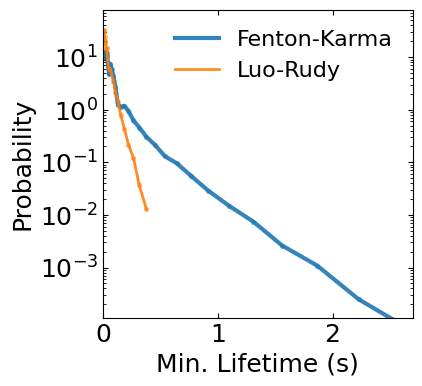

In [13]:
#DONE: compute the minimum lifetimes of particles
#TODO: plot the minimum lifetimes of particles
lw=2
alpha=0.9
fontsize=18
# use_loglog=True
use_loglog=False
# figsize=(6,4)
figsize=(4,4)
#check if msd=0 at lagt=0
fig,ax=plt.subplots(figsize=figsize)
ax.plot(x_fk,barheights_fk,c='C0',lw=lw+1,alpha=alpha,label='Fenton-Karma')
ax.scatter(x_fk,barheights_fk,c='C0',s=8,alpha=alpha/2,zorder=0)
# boolr=barheights_lr>1e-5
# ax.plot(x_lr[boolr],barheights_lr[boolr],c='C1',lw=lw,alpha=alpha,label='Luo-Rudy')
# ax.scatter(x_lr[boolr],barheights_lr[boolr],c='C1',s=8,alpha=alpha/2,zorder=0)
ax.plot(x_lr,barheights_lr,c='C1',lw=lw,alpha=alpha,label='Luo-Rudy')
ax.scatter(x_lr,barheights_lr,c='C1',s=8,alpha=alpha/2,zorder=0)

# xv1=np.linspace(0.01,0.5,10)
# xv2=np.linspace(0.1,5,10)
# ax.plot(xv1,dict_fit_lr['M']*xv1+0.,'k-',lw=2,alpha=0.7)
# ax.plot(xv2,dict_fit_fk['M']*xv2+0.,'k-',lw=2,alpha=0.7)

#format_plot
ax.set_yscale('log')
# ax.set_xlim([0,3.5])
ax.set_xlim([0,2.7])
ax.set_ylim((11*1.0178650359332904e-05, 80))
format_plot(ax=ax,xlabel=r'Min. Lifetime (s)',ylabel=r'Probability',fontsize=fontsize,use_loglog=use_loglog)
# format_plot(ax=ax,xlabel=r'$\Gamma$ (s)',ylabel=r'PDF',fontsize=fontsize,use_loglog=use_loglog)
ax.tick_params(top=True, right=True,direction='in',which='both')
ax.legend(fontsize=fontsize-2,frameon=False)
#format_plot
plt.show()

In [14]:
dict_Gamma_pdf={
    'Fenton-Karma':{'Gamma':x_fk,'Prob':barheights_fk},
    'Luo-Rudy':{'Gamma':x_lr,'Prob':barheights_lr},
}
dict_Gamma_pdf

{'Fenton-Karma': {'Gamma': array([0.01096888, 0.0130944 , 0.01563178, 0.01866086, 0.0222769 ,
         0.02659364, 0.03174687, 0.03789867, 0.04524255, 0.05400949,
         0.06447527, 0.07696907, 0.09188388, 0.10968883, 0.13094397,
         0.15631785, 0.1866086 , 0.22276898, 0.26593641, 0.31746867,
         0.37898668, 0.45242545, 0.54009494, 0.64475272, 0.76969073,
         0.91883882, 1.09688832, 1.30943966, 1.56317848, 1.86608595,
         2.22768982, 2.65936407, 3.17468671, 3.78986684, 4.52425451,
         5.40094935, 6.44752718, 7.69690734, 9.1883882 ]),
  'Prob': array([1.11288458e+01, 1.23874726e+01, 1.13114409e+01, 1.02186994e+01,
         1.17232649e+01, 9.27087992e+00, 1.21238292e+01, 1.04096352e+01,
         7.06014976e+00, 4.67788131e+00, 7.44124140e+00, 5.82725587e+00,
         4.33787010e+00, 2.67429538e+00, 1.24298471e+00, 1.12759447e+00,
         1.18342649e+00, 9.48986674e-01, 6.23854410e-01, 4.57920700e-01,
         3.05505467e-01, 2.15034092e-01, 1.30473849e-01, 9.5

In [15]:
#extract xy values from full
x_values_fk=df_msr_fk['tdeath_avg'].values
y_values_fk=df_msr_fk['MSR'].values
yerr_values_fk=df_msr_fk['Delta_MSR'].values
x_values_lr=df_msr_lr['tdeath_avg'].values
y_values_lr=df_msr_lr['MSR'].values
yerr_values_lr=df_msr_lr['Delta_MSR'].values

In [16]:
mpu_fk = 100.*np.mean((yerr_values_fk/y_values_fk)[x_values_fk<300])
mpu_lr = 100.*np.mean((yerr_values_lr/y_values_lr)[x_values_lr<100])
print(f"mean percent uncertainty in MSR for the full models:")
print(f"{mpu_fk=:.4f}%")
print(f"{mpu_lr=:.4f}%")

mean percent uncertainty in MSR for the full models:
mpu_fk=0.9368%
mpu_lr=1.4348%


In [17]:
tscale=1e-3
df_msr_fk['tprime']=df_msr_fk['tdeath_avg']*tscale
df_msr_lr['tprime']=df_msr_lr['tdeath_avg']*tscale

In [18]:
for df_msr,model in zip([df_msr_fk,df_msr_lr],
                        ['Fenton-Karma','Luo-Rudy']):
    df_gamma = pd.DataFrame(dict_Gamma_pdf[model])
    R_rms = comp_avg_range_rms(df_msr,df_gamma,tcol='tprime',msrcol='MSR',lcol='Gamma',model_name=model,printing=True)#,**kwargs)


R_rms=0.9569 cm (Fenton-Karma)
R_rms=1.3852 cm (Luo-Rudy)


In [19]:
(df_msr_fk['tprime'].diff()*df_msr_fk['pdf_lifetime']).sum()

1.0164609885539782

In [20]:
model='Fenton-Karma'
# model='Luo-Rudy'
df_msr = df_msr_fk
#TODO: wrap up esimation of R_rms to foo
#GOAL(later): dev function that automates the whole annihilation analysis from tracked files
#TODO: move esimation of R_rms to lib
#TODO: hook esimation of R_rms onto end of estimation of MSR pipeline
#TODO: make ^this executable and print the R_rms
#TODO: make ^this executable and generate a .pdf with plots in it.

In [21]:
#DONE: use df_gamma as a lookup table to estimate gamma(t)
#DONT: abstract ^that and wrap as foo. likelihood of reuse versus simple, self-documenting local implementation in <10 lines of legible python.
#TODO: estimate R_rms by using dict_Gamma_pdf as a linear lookup table


In [22]:
##################################################################
# compute simulated annealing fits of oscillatory particle model
##################################################################
D=0.
print(f"fixed {D=:.4f} cm^2/s.")
print(f"computing simulated annealing fits of oscillatory particle model to the Fenton-Karma model (estimated run time ~2.3 minutes)...")
# select msr from the full models for fitting
x_values=x_values_fk.copy()
y_values=y_values_fk.copy()
minlifetime_values=minlifetime_values_fk.copy()

#### 

# max_tdeath=100. #ms #for lr
max_tdeath=300. #ms #for fk
meanx,Delta_meanx,num_obsx,p_normalx=comp_mean_bootstrap_uncertainty(minlifetime_values)
Gamma=float(meanx)
# testing=False 
testing=True # True adds ~60 - 6.27 seconds to runtime
if printing:
    print(f"mean lifetime: {meanx:.4f} +/- {Delta_meanx:.4f} ms (N={num_obsx}, p_normal: {p_normalx:.4f}) from {minlifetime_values.shape[0]} observations")
#fit using simulated annealing
a0,a1,period,phase,rmse = fit_msr_oscillatory(x_values,y_values,max_tdeath,
                                    D=0.,maxiter=10000,seed=42,printing=printing)
alinear = comp_alinear(a0,a1,period,Gamma,phase)
omega = 2*np.pi/period
z = Gamma*omega
print(f"\tattraction coefficient: {a0=:.4f}, {a1=:.4f}, {z=:.4f}, {phase=:.4f} --> {alinear=:.4f} cm^2/s")
dict_fit=dict(a0=a0,a1=a1,period=period,phase=phase,rmse=rmse,
              alinear=alinear,omega=omega,z=z,Gamma=Gamma, Delta_Gamma=Delta_meanx, num_obs=num_obsx, p_normal=p_normalx)
if not testing:
    print_dict(dict_fit)

if testing:
    print(f"performing fit using simulated annealing with 10X the number of learning rounds...")
    a0,a1,period,phase,rmse = fit_msr_oscillatory(x_values,y_values,max_tdeath,
                                        D=0.,maxiter=2500,#maxiter=100000, 
                                                  seed=43,printing=printing)
    alinear = comp_alinear(a0,a1,period,Gamma,phase)
    omega = 2*np.pi/period
    z = Gamma*omega
    print(f"\tattraction coefficient: {a0=:.4f}, {a1=:.4f}, {z=:.4f}, {phase=:.4f} --> {alinear=:.4f} cm^2/s")
    dict_fit=dict(a0=a0,a1=a1,period=period,phase=phase,rmse=rmse,
                  alinear=alinear,omega=omega,z=z,Gamma=Gamma, Delta_Gamma=Delta_meanx, num_obs=num_obsx, p_normal=p_normalx)
    print_dict(dict_fit)    
    
dict_osc_fit_fk=dict(dict_fit)

#### 
print(f"\ncomputing simulated annealing fits of oscillatory particle model to the Luo-Rudy model...")
# select msr from the full models for fitting
x_values=x_values_lr.copy()
y_values=y_values_lr.copy()
minlifetime_values=minlifetime_values_lr.copy()
# max_tdeath=100. #ms #for lr
max_tdeath=100. #ms #for lr
# max_tdeath=300. #ms #for fk
meanx,Delta_meanx,num_obsx,p_normalx=comp_mean_bootstrap_uncertainty(minlifetime_values)
Gamma=float(meanx)
# testing=False 
# testing=True # True adds ~60 - 6.27 seconds to runtime
if printing:
    print(f"mean lifetime: {meanx:.4f} +/- {Delta_meanx:.4f} ms (N={num_obsx}, p_normal: {p_normalx:.4f}) from {minlifetime_values.shape[0]} observations")
#fit using simulated annealing
a0,a1,period,phase,rmse = fit_msr_oscillatory(x_values,y_values,max_tdeath,
                                    D=0.,maxiter=10000,seed=42,printing=printing)
alinear = comp_alinear(a0,a1,period,Gamma,phase)
omega = 2*np.pi/period
z = Gamma*omega
print(f"\tattraction coefficient: {a0=:.4f}, {a1=:.4f}, {z=:.4f}, {phase=:.4f} --> {alinear=:.4f} cm^2/s")
dict_fit=dict(a0=a0,a1=a1,period=period,phase=phase,rmse=rmse,
              alinear=alinear,omega=omega,z=z,Gamma=Gamma, Delta_Gamma=Delta_meanx, num_obs=num_obsx, p_normal=p_normalx)
if not testing:
    print_dict(dict_fit)

if testing:
    print(f"performing fit using simulated annealing with 10X the number of learning rounds...")
    a0,a1,period,phase,rmse = fit_msr_oscillatory(x_values,y_values,max_tdeath,
                                        D=0.,maxiter=2500,#maxiter=100000, 
                                                  seed=43,printing=printing)
    alinear = comp_alinear(a0,a1,period,Gamma,phase)
    omega = 2*np.pi/period
    z = Gamma*omega
    print(f"\tattraction coefficient: {a0=:.4f}, {a1=:.4f}, {z=:.4f}, {phase=:.4f} --> {alinear=:.4f} cm^2/s")
    dict_fit=dict(a0=a0,a1=a1,period=period,phase=phase,rmse=rmse,
                  alinear=alinear,omega=omega,z=z,Gamma=Gamma, Delta_Gamma=Delta_meanx, num_obs=num_obsx, p_normal=p_normalx)
    print_dict(dict_fit)    

dict_osc_fit_lr=dict(dict_fit)

fixed D=0.0000 cm^2/s.
computing simulated annealing fits of oscillatory particle model to the Fenton-Karma model (estimated run time ~2.3 minutes)...
mean lifetime: 105.3196 +/- 1.6438 ms (N=36179, p_normal: 0.4648) from 36179 observations
performing simulated annealing with D=0 fixed (num. epochs: 10000)...
simulated annealing fit: a0=1.6362, a1=1.2822, period=115.9413, phase=-0.5415 --> rmse=0.0284 cm^2
	attraction coefficient: a0=1.6362, a1=1.2822, z=5.7076, phase=-0.5415 --> alinear=1.7812 cm^2/s
performing fit using simulated annealing with 10X the number of learning rounds...
performing simulated annealing with D=0 fixed (num. epochs: 2500)...
simulated annealing fit: a0=1.6357, a1=1.2827, period=115.9141, phase=-0.5452 --> rmse=0.0284 cm^2
	attraction coefficient: a0=1.6357, a1=1.2827, z=5.7089, phase=-0.5452 --> alinear=1.7814 cm^2/s
a0=1.635743662970114
a1=1.282697880836082
period=115.91405754199059
phase=-0.5452135473156354
rmse=0.02843439286374579
alinear=1.7814449270588557

In [23]:
# 1.8454,1.8453
# 1.8492,1.8494
# ax.plot(xlr,ylr,lw=2,alpha=0.8,c='C1')
# ax.fill_between(xlr,ylr-yerrlr,ylr+yerrlr,lw=lw,alpha=alpha,color='C1')

In [24]:
# Fenton-Karma
# performing simulated annealing with D=0 fixed (num. epochs: 10000)...
# simulated annealing fit: a0=1.6362, a1=1.2822, period=115.9413, phase=-0.5415 --> rmse=0.0284 cm^2
# 	attraction coefficient: a0=1.6362, a1=1.2822, z=5.7076, phase=-0.5415 --> alinear=1.7812 cm^2/s
#         performing simulated annealing with D=0 fixed (num. epochs: 2500)...
# simulated annealing fit: a0=1.6357, a1=1.2827, period=115.9141, phase=-0.5452 --> rmse=0.0284 cm^2
# 	attraction coefficient: a0=1.6357, a1=1.2827, z=5.7089, phase=-0.5452 --> alinear=1.7814 cm^2/s

In [25]:
1.2822-1.2827

-0.0004999999999999449

In [26]:
-0.5452--0.5415
115.9141-115.9413

-0.02719999999999345

In [27]:
# 		               & Fenton-Karma              &  Luo-Rudy               \\
# 		\toprule
# $a_0$ (cm$^2$/s)      &  1.407 $\pm$ 0.016,0.0005+2*Delta_D        & 4.2 $\pm$ 0.3,0.0007+2*Delta_D \\
# $a_1$ (cm$^2$/s)      &  1.28222 $\pm$ 0.00011,0.000499   & 12.1798 $\pm$ 0.0008,0.0119   \\
# $\phi_f$ (radians)    & -0.5410 $\pm$ 0.0008,0.0037     & -1.165 $\pm$ 0.002,0.00340    \\
# $T_{OPM}$ (ms)              & 115.941 $\pm$ 0.012,0.0272      & 97.359 $\pm$ 0.015,0.1162     \\

In [28]:
# Luo-Rudy model
# performing simulated annealing with D=0 fixed (num. epochs: 10000)...
# simulated annealing fit: a0=5.0191, a1=12.1798, period=97.3593, phase=-1.1655 --> rmse=0.0642 cm^2
# 	attraction coefficient: a0=5.0191, a1=12.1798, z=2.1533, phase=-1.1655 --> alinear=10.1470 cm^2/s
# performing simulated annealing with D=0 fixed (num. epochs: 2500)...
# simulated annealing fit: a0=5.0184, a1=12.1679, period=97.4755, phase=-1.1621 --> rmse=0.0642 cm^2
# 	attraction coefficient: a0=5.0184, a1=12.1679, z=2.1507, phase=-1.1621 --> alinear=10.1468 cm^2/s

		               & Fenton-Karma              &  Luo-Rudy               \\
		\toprule
$a_0$ (cm$^2$/s)      &  1.407 $\pm$ 0.016        & 4.2 $\pm$ 0.3 \\
$a_1$ (cm$^2$/s)      &  1.2822 $\pm$ 0.0005   & 12.180 $\pm$ 0.012   \\
$\phi_f$ (radians)    & -0.541 $\pm$ 0.004     & -1.165 $\pm$ 0.003    \\
$T_{OPM}$ (ms)              & 115.94 $\pm$ 0.03      & 97.36 $\pm$ 0.12     \\

In [29]:
#TODO: estimate updated uncertainties from the maxabsdiff of OPM parameters 
1.6362-1.6357

5.0184-5.0191
# 12.1798-12.1679
# 97.4755-97.3593
# -1.1655--1.1621 


-0.000700000000000145

In [30]:
# #nota bene: the contents of fit_msr_oscillatory:
# maxiter=100000
# print(f"num. epochs: {maxiter}")
# res = anneal_msr_fit(t_values,msr_values,D,
#                    bounds = ((0, 100), (0, 100), (50, 300), (-3.15,3.15)),
#                    maxiter=maxiter,seed=42+1, no_local_search=True)#,**kwargs)
# rmse= np.sqrt(res.fun/t_values.shape[0])
# a0,a1,period,phase=res.x
# print(f"simulated annealing fit: {a0=:.4f}, {a1=:.4f}, {period=:.4f}, {phase=:.4f} --> {rmse=:.4f} cm^2")

In [31]:
# initial_phase_orientation
# #what param setting to use for the FK model?
# phi_f=initial_phase_orientation
# period=period_of_oscillation*1e3 #seconds
# # constant=0.15
# omega=2*np.pi/period
# # constant=-8*D*np.sin(phi_f)/omega#0.15

In [32]:
amax_fk = 1.781
amax_lr = 10.147
# amax_fk = 1.9252 # - 1.9252 ==> uncert <0.0001
# amax_lr = 11.2437 # 11.2265 ==> uncert = 0.0172

In [33]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

approximate time window: 0.13 seconds


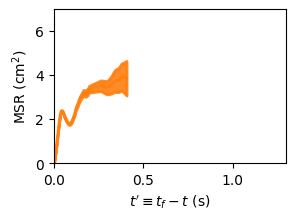

In [34]:
#DONE: increase the apparent bin size for LR at large time scales
#HINT: using moving average is valid!
# tmaxlr=0.42 #sec
tmaxlr=0.92 #sec
miny_lr = np.min(y_values_lr)
boo_lr=x_values_lr*tscale<tmaxlr
xlr = x_values_lr[boo_lr]*tscale
ylr = y_values_lr[boo_lr]-miny_lr
yerrlr = yerr_values_lr[boo_lr].copy()

#moving time average where t > tminlr_avg 
tminlr_avg=0.2 #sec
navg=25
# navg=1
boo = xlr>tminlr_avg
xlr = np.concatenate([xlr[~boo],moving_average(xlr[boo],navg)])
ylr = np.concatenate([ylr[~boo],moving_average(ylr[boo],navg)])
yerrlr = np.concatenate([yerrlr[~boo],moving_average(yerrlr[boo],navg)])
#filter by max time
tmaxlr=0.42 #sec
boo_lr=xlr<tmaxlr
xlr = xlr[boo_lr].copy()
ylr = ylr[boo_lr].copy()
yerrlr = yerrlr[boo_lr].copy()
print(f"approximate time window: {navg*(0.00692723-0.00186675):.2f} seconds")
#DONT: add the variances?
#DONE: or better, average the variances. 

fig,ax=plt.subplots(figsize=(3,2))
ax.plot(xlr,ylr,lw=2,alpha=0.8,c='C1')
ax.fill_between(xlr,ylr-yerrlr,ylr+yerrlr,lw=lw,alpha=alpha,color='C1')
format_plot(ax=ax,xlabel=r"$t'\equiv t_f-t$ (s)",ylabel=r'MSR (cm$^2$)',fontsize=10)
plt.xlim([0,1.3])
plt.ylim([0,7])
plt.show()

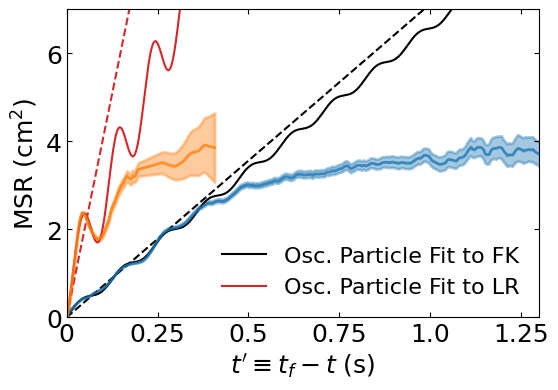

In [35]:
#plot MSR_Osc over the direct simulation results
lw=2
alpha=0.4
# fontsize=16
fontsize=18
# # figsize=(8,4.2)
# figsize=(4,4.2)
# figsize=(6,4)
figsize=(6.1,4)
# fontsize=15
### plot expected
# fontsize=20
tscale=1e-3

fig,ax=plt.subplots(figsize=figsize)

#plot simulated annealing fits of oscillatory particle model
phi_f = dict_osc_fit_fk['phase']
omega = dict_osc_fit_fk['omega']*1e3
a = dict_osc_fit_fk['a1']
D = dict_osc_fit_fk['a0']/2
# t_values=np.linspace(0,1,1000)
t_values=np.linspace(0,1.1,1000)
# MSR_values_oscillatory=4*(a*t_values+(2*D/omega)*(np.sin(omega*t_values+phi_f))+constant
MSR_values_oscillatory=4*(2*D*t_values+(a/omega)*(np.sin(omega*t_values+phi_f)-np.sin(phi_f)))
# MSR_values_oscillatory_fk = MSR_values_oscillatory.copy()
ax.plot(t_values,MSR_values_oscillatory,c='k',#'C2',
                label=r'Osc. Particle Fit to FK')



#plot simulated annealing fits of oscillatory particle model
phi_f = dict_osc_fit_lr['phase']
omega = dict_osc_fit_lr['omega']*1e3
a = dict_osc_fit_lr['a1']
D = dict_osc_fit_lr['a0']/2
t_values=np.linspace(0,1,1000)
# MSR_values_oscillatory=4*(a*t_values+(2*D/omega)*(np.sin(omega*t_values+phi_f))+constant
MSR_values_oscillatory=4*(2*D*t_values+(a/omega)*(np.sin(omega*t_values+phi_f)-np.sin(phi_f)))
# MSR_values_oscillatory_lr = MSR_values_oscillatory.copy()
ax.plot(t_values,MSR_values_oscillatory,c='C3',
                label=r'Osc. Particle Fit to LR')
#                 label=r'$MSR_{Osc.}(a=a_{FK},\phi_f=-\frac{\pi}{2})$')

#plot the linear particle model
ax.plot(t_values,4*amax_fk*t_values,c='k',linestyle='dashed')
ax.plot(t_values,4*amax_lr*t_values,c='C3',linestyle='dashed')
# ax.plot(t_values,4*amax_fk*t_values,c='C0',linestyle='dashed')
# ax.plot(t_values,4*amax_lr*t_values,c='C1',linestyle='dashed')

# #plot the direct simulation of the oscillatory particle model under these same parameter settings
# stepsize=2500
# plt.scatter(dict_fit_fk['tdeath'][::stepsize],dict_fit_fk['MSR'][::stepsize],lw=2,alpha=.7,c='k',#'C2',
#             marker='x')#,label='Simulation of Osc. (FK)')
# stepsize=1000
# plt.scatter(dict_fit_lr['tdeath'][::stepsize],dict_fit_lr['MSR'][::stepsize],lw=2,alpha=.7,c='C3',
#             marker='x')#,label='Simulation of Osc. (LR)')
 
# #plot msd data from full (works worse)
# ax.plot(x_values_fk*tscale,y_values_fk,lw=2,alpha=0.8,c='C0')
# ax.fill_between(x_values_fk*tscale,y_values_fk-yerr_values_fk,y_values_fk+yerr_values_fk,lw=lw,alpha=alpha,color='C0')
# ax.plot(x_values_lr*tscale,y_values_lr,lw=2,alpha=0.8,c='C1')
# ax.fill_between(x_values_lr*tscale,y_values_lr-yerr_values_lr,y_values_lr+yerr_values_lr,lw=lw,alpha=alpha,color='C1')

#plot msd data from full with minimum subtracted (works better)
miny = np.min(y_values_fk)
ax.plot(x_values_fk*tscale,y_values_fk-miny,lw=2,alpha=0.8,c='C0')
ax.fill_between(x_values_fk*tscale,y_values_fk-yerr_values_fk-miny,y_values_fk+yerr_values_fk-miny,lw=lw,alpha=alpha,color='C0')

ax.plot(xlr,ylr,lw=2,alpha=0.8,c='C1')
ax.fill_between(xlr,ylr-yerrlr,ylr+yerrlr,lw=lw,alpha=alpha,color='C1')
# miny_lr = np.min(y_values_lr)
# tmaxlr=0.42 #sec
# boo_lr=x_values_lr*tscale<tmaxlr
# ax.plot(x_values_lr[boo_lr]*tscale,y_values_lr[boo_lr]-miny_lr,lw=2,alpha=0.8,c='C1')
# ax.fill_between(x_values_lr[boo_lr]*tscale,y_values_lr[boo_lr]-yerr_values_lr[boo_lr]-miny_lr,
#                 y_values_lr[boo_lr]+yerr_values_lr[boo_lr]-miny_lr,lw=lw,alpha=alpha,color='C1')
# # ax.plot(x_values_lr*tscale,y_values_lr-miny_lr,lw=2,alpha=0.8,c='C1')
# # ax.fill_between(x_values_lr*tscale,y_values_lr-yerr_values_lr-miny_lr,y_values_lr+yerr_values_lr-miny_lr,lw=lw,alpha=alpha,color='C1')

#format_plot
# format_plot(ax=ax,xlabel=r'$t_f-t$ (seconds)',ylabel=r'MSR (cm$^2$)',fontsize=fontsize)
format_plot(ax=ax,xlabel=r"$t'\equiv t_f-t$ (s)",ylabel=r'MSR (cm$^2$)',fontsize=fontsize)

# plt.xlim([0,1])
# plt.xlim([0,1.1])
plt.xlim([0,1.3])
# plt.ylim([0,4.6])
# plt.ylim([0,6])
plt.ylim([0,7])

ax.tick_params(bottom=True,left=True,top=True, right=True,direction='in',which='both')
ax.legend(fontsize=16,frameon=False)
xticklabels = [str(x) for x in ax.get_xticks()]
xticklabels[0] = '0'
# xticklabels[3] = '0.6'
ax.set_xticklabels(xticklabels)
plt.show()

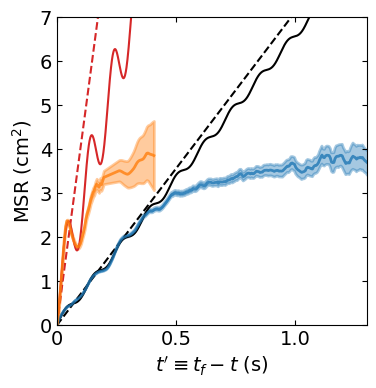

In [36]:
#plot MSR_Osc over the direct simulation results
lw=2
alpha=0.4
fontsize=14
# fontsize=18
# # figsize=(8,4.2)
# figsize=(4,4.2)
# figsize=(6,4)
# figsize=(6.1,4)
figsize=(4,4)
# fontsize=15
### plot expected
# fontsize=20
tscale=1e-3

fig,ax=plt.subplots(figsize=figsize)

#plot simulated annealing fits of oscillatory particle model
phi_f = dict_osc_fit_fk['phase']
omega = dict_osc_fit_fk['omega']*1e3
a = dict_osc_fit_fk['a1']
D = dict_osc_fit_fk['a0']/2
# t_values=np.linspace(0,1,1000)
t_values=np.linspace(0,1.1,1000)
# MSR_values_oscillatory=4*(a*t_values+(2*D/omega)*(np.sin(omega*t_values+phi_f))+constant
MSR_values_oscillatory=4*(2*D*t_values+(a/omega)*(np.sin(omega*t_values+phi_f)-np.sin(phi_f)))
# MSR_values_oscillatory_fk = MSR_values_oscillatory.copy()
ax.plot(t_values,MSR_values_oscillatory,c='k',#'C2',
                label=r'Osc. Particle Fit to FK')



#plot simulated annealing fits of oscillatory particle model
phi_f = dict_osc_fit_lr['phase']
omega = dict_osc_fit_lr['omega']*1e3
a = dict_osc_fit_lr['a1']
D = dict_osc_fit_lr['a0']/2
t_values=np.linspace(0,1,1000)
# MSR_values_oscillatory=4*(a*t_values+(2*D/omega)*(np.sin(omega*t_values+phi_f))+constant
MSR_values_oscillatory=4*(2*D*t_values+(a/omega)*(np.sin(omega*t_values+phi_f)-np.sin(phi_f)))
# MSR_values_oscillatory_lr = MSR_values_oscillatory.copy()
ax.plot(t_values,MSR_values_oscillatory,c='C3',
                label=r'Osc. Particle Fit to LR')
#                 label=r'$MSR_{Osc.}(a=a_{FK},\phi_f=-\frac{\pi}{2})$')

#plot the linear particle model
ax.plot(t_values,4*amax_fk*t_values,c='k',linestyle='dashed')
ax.plot(t_values,4*amax_lr*t_values,c='C3',linestyle='dashed')
# ax.plot(t_values,4*amax_fk*t_values,c='C0',linestyle='dashed')
# ax.plot(t_values,4*amax_lr*t_values,c='C1',linestyle='dashed')

# #plot the direct simulation of the oscillatory particle model under these same parameter settings
# stepsize=2500
# plt.scatter(dict_fit_fk['tdeath'][::stepsize],dict_fit_fk['MSR'][::stepsize],lw=2,alpha=.7,c='k',#'C2',
#             marker='x')#,label='Simulation of Osc. (FK)')
# stepsize=1000
# plt.scatter(dict_fit_lr['tdeath'][::stepsize],dict_fit_lr['MSR'][::stepsize],lw=2,alpha=.7,c='C3',
#             marker='x')#,label='Simulation of Osc. (LR)')
 
# #plot msd data from full (works worse)
# ax.plot(x_values_fk*tscale,y_values_fk,lw=2,alpha=0.8,c='C0')
# ax.fill_between(x_values_fk*tscale,y_values_fk-yerr_values_fk,y_values_fk+yerr_values_fk,lw=lw,alpha=alpha,color='C0')
# ax.plot(x_values_lr*tscale,y_values_lr,lw=2,alpha=0.8,c='C1')
# ax.fill_between(x_values_lr*tscale,y_values_lr-yerr_values_lr,y_values_lr+yerr_values_lr,lw=lw,alpha=alpha,color='C1')

#plot msd data from full with minimum subtracted (works better)
miny = float(np.min(y_values_fk))
ax.plot(x_values_fk*tscale,y_values_fk-miny,lw=2,alpha=0.8,c='C0')
ax.fill_between(x_values_fk*tscale,y_values_fk-yerr_values_fk-miny,y_values_fk+yerr_values_fk-miny,lw=lw,alpha=alpha,color='C0')
# ax.plot(x_values_fk*tscale,y_values_fk,lw=2,alpha=0.8,c='C0')
# ax.fill_between(x_values_fk*tscale,y_values_fk-yerr_values_fk,y_values_fk+yerr_values_fk,lw=lw,alpha=alpha,color='C0')

ax.plot(xlr,ylr,lw=2,alpha=0.8,c='C1')
ax.fill_between(xlr,ylr-yerrlr,ylr+yerrlr,lw=lw,alpha=alpha,color='C1')
# miny_lr = np.min(y_values_lr)
# tmaxlr=0.42 #sec
# boo_lr=x_values_lr*tscale<tmaxlr
# ax.plot(x_values_lr[boo_lr]*tscale,y_values_lr[boo_lr]-miny_lr,lw=2,alpha=0.8,c='C1')
# ax.fill_between(x_values_lr[boo_lr]*tscale,y_values_lr[boo_lr]-yerr_values_lr[boo_lr]-miny_lr,
#                 y_values_lr[boo_lr]+yerr_values_lr[boo_lr]-miny_lr,lw=lw,alpha=alpha,color='C1')
# # ax.plot(x_values_lr*tscale,y_values_lr-miny_lr,lw=2,alpha=0.8,c='C1')
# # ax.fill_between(x_values_lr*tscale,y_values_lr-yerr_values_lr-miny_lr,y_values_lr+yerr_values_lr-miny_lr,lw=lw,alpha=alpha,color='C1')

#format_plot
# format_plot(ax=ax,xlabel=r'$t_f-t$ (seconds)',ylabel=r'MSR (cm$^2$)',fontsize=fontsize)
format_plot(ax=ax,xlabel=r"$t'\equiv t_f-t$ (s)",ylabel=r'MSR (cm$^2$)',fontsize=fontsize)

# plt.xlim([0,1])
# plt.xlim([0,1.1])
plt.xlim([0,1.3])
# plt.ylim([0,4.6])
# plt.ylim([0,6])
plt.ylim([0,7])

ax.tick_params(bottom=True,left=True,top=True, right=True,direction='in',which='both')
# ax.legend(fontsize=10,frameon=False)
xticklabels = [str(x) for x in ax.get_xticks()]
xticklabels[0] = '0'
# xticklabels[3] = '0.6'
ax.set_xticklabels(xticklabels)
plt.show()

In [37]:


# ax.plot(xlr,ylr,lw=2,alpha=0.8,c='C1')
# plt.fill_between(xlr,ylr-yerrlr,ylr+yerrlr,lw=lw,alpha=alpha,color='C1')
# # ax.plot(x_values_lr*tscale,y_values_lr-miny_lr,lw=2,alpha=0.8,c='C1')
# # ax.fill_between(x_values_lr*tscale,y_values_lr-yerr_values_lr-miny_lr,y_values_lr+yerr_values_lr-miny_lr,lw=lw,alpha=alpha,color='C1')

# #format_plot
# # format_plot(ax=ax,xlabel=r'$t_f-t$ (seconds)',ylabel=r'MSR (cm$^2$)',fontsize=fontsize)
# format_plot(ax=ax,xlabel=r"$t'\equiv t_f-t$ (s)",ylabel=r'MSR (cm$^2$)',fontsize=fontsize)

# # plt.xlim([0,1])
# # plt.xlim([0,1.1])
# format_plot(ax=ax,xlabel=r"$t'\equiv t_f-t$ (s)",ylabel=r'MSR (cm$^2$)',fontsize=fontsize)
# plt.xlim([0,1.3])
# plt.ylim([0,7])
# # plt.ylim([0,4.6])
# # plt.ylim([0,6])

# ax.tick_params(bottom=True,left=True,top=True, right=True,direction='in',which='both')
# ax.legend(fontsize=16,frameon=False)
# xticklabels = [str(x) for x in ax.get_xticks()]
# xticklabels[0] = '0'
# # xticklabels[3] = '0.6'
# ax.set_xticklabels(xticklabels)

# plt.show()

In [38]:
# t_values
# x_values_lr*tscale

In [39]:
#extract xy values from full
x_values_fk=df_msr_fk['tdeath_avg'].values
y_values_fk=df_msr_fk['MSR'].values
yerr_values_fk=df_msr_fk['Delta_MSR'].values
x_values_lr=df_msr_lr['tdeath_avg'].values
y_values_lr=df_msr_lr['MSR'].values
yerr_values_lr=df_msr_lr['Delta_MSR'].values

In [40]:
#DONE: compute mean percent error (MPE) for both fits in their respective zone of fitting
print(*dict_osc_fit_fk)
print(*dict_osc_fit_lr)
t_values_fk = x_values_fk.copy()
t_values_lr = x_values_lr.copy()

MSR_values_fk = y_values_fk-miny
MSR_values_lr = y_values_lr-miny_lr
# MSR_values_fk = y_values_fk
# MSR_values_lr = y_values_lr

a0 a1 period phase rmse alinear omega z Gamma Delta_Gamma num_obs p_normal
a0 a1 period phase rmse alinear omega z Gamma Delta_Gamma num_obs p_normal


In [41]:
tmax=300 # ms
t_values = t_values_fk*tscale
boo = (tmax*tscale>=t_values)&(0<t_values)
# e_values = np.abs(MSR_values_oscillatory[boo] - MSR_values_fk[boo])
MSR_values_fk[boo]

array([0.        , 0.10579867, 0.1680177 , 0.21707227, 0.26183835,
       0.30353826, 0.34130213, 0.37637927, 0.40671204, 0.42895122,
       0.44207785, 0.45161347, 0.47075874, 0.49893595, 0.52827316,
       0.55458512, 0.57506513, 0.59565499, 0.61429375, 0.63783575,
       0.66634909, 0.70045824, 0.74067291, 0.78553206, 0.83406652,
       0.88644165, 0.9414867 , 0.99440959, 1.04045447, 1.0782875 ,
       1.11264341, 1.14193259, 1.16665485, 1.18519296, 1.20378142,
       1.21556021, 1.22288703, 1.23219877, 1.23569843, 1.24402797,
       1.25822424, 1.27160119, 1.29823905, 1.33540417, 1.38083803,
       1.43767859, 1.49543798, 1.55836275, 1.63079943, 1.6978907 ,
       1.76186422, 1.82077642, 1.87356321, 1.92308835, 1.95585853,
       1.98241007, 2.00396132, 2.01312506, 2.02691871, 2.03420716])

In [42]:
#######################
# mpe for FK model
#######################
t_values = t_values_fk*tscale
dict_osc_fit = dict(dict_osc_fit_fk)
#recall fit
phi_f = dict_osc_fit['phase']
omega = dict_osc_fit['omega']*1e3
a = dict_osc_fit['a1']
D = dict_osc_fit['a0']/2
MSR_values_oscillatory=4*(2*D*t_values+(a/omega)*(np.sin(omega*t_values+phi_f)-np.sin(phi_f)))
#compute the mean percent error
boo = (tmax*tscale>=t_values)&(0<t_values)
e_values = np.abs(MSR_values_oscillatory[boo] - MSR_values_fk[boo])
pe_values = 100.*e_values/MSR_values_fk[boo]
pe_values[0]=0. #the first datum is set to zero to enforce MSR(0)=0
x_values_fk_ = t_values[boo].copy()
pe_values_fk = pe_values.copy()
mpe_fk = np.mean(pe_values)
print(f"{mpe_fk=:.4f}% for osc. fit to MSR of FK")


#######################
# mpe for LR model
#######################
tmax=100
t_values = t_values_lr*tscale
dict_osc_fit = dict(dict_osc_fit_lr)
#recall fit
phi_f = dict_osc_fit['phase']
omega = dict_osc_fit['omega']*1e3
a = dict_osc_fit['a1']
D = dict_osc_fit['a0']/2
MSR_values_oscillatory=4*(2*D*t_values+(a/omega)*(np.sin(omega*t_values+phi_f)-np.sin(phi_f)))
#compute the mean percent error
boo = (tmax*tscale>=t_values)&(0<t_values)
e_values = np.abs(MSR_values_oscillatory[boo] - MSR_values_lr[boo])
pe_values = 100.*e_values/MSR_values_lr[boo]

pe_values[0]=0. #the first datum is set to zero to enforce MSR(0)=0

x_values_lr_ = t_values[boo].copy()
pe_values_lr = pe_values.copy()
mpe_lr = np.mean(pe_values)
print(f"{mpe_lr=:.4f}% for osc. fit to MSR of LR")


mpe_fk=3.5077% for osc. fit to MSR of FK
mpe_lr=3.7172% for osc. fit to MSR of LR


In [43]:
# plt.plot(MSR_values_lr[boo])
# plt.plot(MSR_values_oscillatory[boo])

In [44]:
# MSR_values_fk[0]

In [45]:
# plt.plot(t_values_fk,MSR_values_oscillatory)
# plt.plot(t_values_fk,MSR_values_fk)

In [46]:
print(f"NOTE: there is this jump in mpe near the temporal origin...")
print(f"Q: does LR have this too? A: yes.")
print(f"Q: does getting rid of the zero subtraction improve MPE near origin? A: no. shifting time left/right is probably a better way to estimate amax...")

NOTE: there is this jump in mpe near the temporal origin...
Q: does LR have this too? A: yes.
Q: does getting rid of the zero subtraction improve MPE near origin? A: no. shifting time left/right is probably a better way to estimate amax...


In [47]:
#Q: what is the mean percent uncertainty for the full models over the same regime?


In [48]:
# when using 1.78,10.147
# mpe=3.5016% for osc. fit to MSR of FK
# Q: how much smaller is mpe when not subtracting the first value?
# A: its not. not not subtracting the first value is much worse...

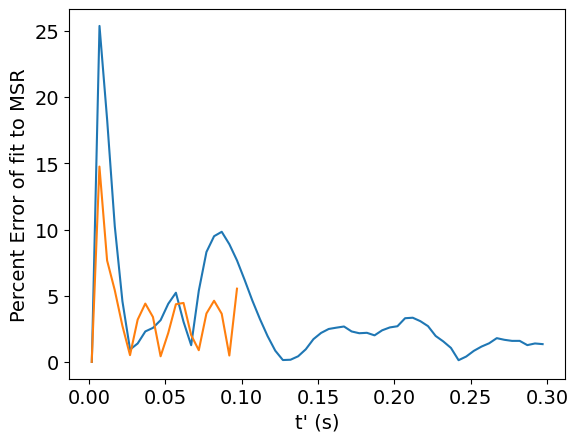

In [49]:
plt.plot(x_values_fk_,pe_values_fk,label='FK')
plt.plot(x_values_lr_,pe_values_lr,label='LR')
format_plot(xlabel="t' (s)", ylabel="Percent Error of fit to MSR",fontsize=14)
plt.show()

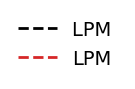

bool

In [50]:
# label_lst=["Lin. ", "Lin."]
label_lst=["LPM ", "LPM"]
# color_lst=['C3', 'k']
color_lst=['k','C3']
kwargs_legend={
    'frameon':False,
    'loc':'center',
    'ncol':1,
    'fontsize':14}
rv = PlotLegend_lines(label_lst=label_lst,color_lst=color_lst,figsize=(1,1),**kwargs_legend);
    
type(rv)

In [51]:
# PlotLegend_lines

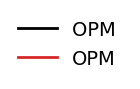

bool

In [52]:
label_lst=["OPM ", "OPM"]
# label_lst=["Osc. ", "Osc."]
# color_lst=['C3', 'k']
color_lst=['k','C3']
kwargs_legend={
    'frameon':False,
    'loc':'center',
    'ncol':1,
    'fontsize':14}
rv = PlotLegend_lines(label_lst=label_lst,color_lst=color_lst,
                      linestyle='solid',
                      figsize=(1,1),**kwargs_legend);
    
type(rv)

In [53]:
dffk=pd.DataFrame([dict_osc_fit_fk])
dflr=pd.DataFrame([dict_osc_fit_lr])
dffk['model']='Fenton-Karma'
dflr['model']='Luo-Rudy'
df_osc_fits = pd.concat((dffk,dflr))
df_osc_fits['amax'] = df_osc_fits['alinear'] 
# list(df_osc_fits.columns)
# df_osc_fits = df_osc_fits[['model', 'amax', 'a0', 'a1', 'period', 'phase', 'rmse', 'omega', 'z']].copy().T
df_osc_fits = df_osc_fits[['model', 'amax', 'a0', 'a1', 'period', 'phase', 'z', 'rmse']].copy().T
print("%simulated annealing fits:")
print(df_osc_fits.to_latex())

%simulated annealing fits:
\begin{tabular}{lll}
\toprule
{} &             0 &          0 \\
\midrule
model  &  Fenton-Karma &   Luo-Rudy \\
amax   &      1.781445 &  10.146773 \\
a0     &      1.635744 &   5.018436 \\
a1     &      1.282698 &  12.167933 \\
period &    115.914058 &  97.475481 \\
phase  &     -0.545214 &  -1.162092 \\
z      &      5.708904 &    2.15074 \\
rmse   &      0.028434 &   0.064175 \\
\bottomrule
\end{tabular}



## plot MSR versus time until annihilation with direct simulations of the affine oscillatory particle model

In [54]:
##################################################################################################
# compute the direct simulation of the oscillatory particle model under these parameter settings
##################################################################################################

In [55]:
print(f"integrating oscillatory stochastic differential equation directly (estimated run time ~45 seconds)...")
a=dict_osc_fit_fk['a1']
D=dict_osc_fit_fk['a0']/2
initial_phase_orientation=dict_osc_fit_fk['phase']
period_of_oscillation=dict_osc_fit_fk['period']
#compute the oscillatory particle model
kwargs_fk=dict(a=a, D=D, initial_phase_orientation=initial_phase_orientation, period_of_oscillation=period_of_oscillation, num_pairs=1000, rstart=0.0001, Dt=1e-05, 
               xmin=0, xmax=0.1, ymin=0, ymax=0.6, alpha=0.7, show_inputted_a=False, show_title=False, show_legend=True, use_xylim=True, show_label_black_dotted=False, printing=False, plotting=True)#, c='C3', label='Simulation')
dict_fit_fk=visualize_model_oscillatory_reversed(ax=None,c='C0',label='Simulation of Osc. (FK)', **kwargs_fk)
plt.close()
print(*dict_fit_fk)

print(f"integrating oscillatory stochastic differential equation directly (estimated run time 1 minutes and 40 seconds)...")
# print(f"integrating oscillatory stochastic differential equation directly (estimated run time ~40 seconds)...")
a=dict_osc_fit_lr['a1']
D=dict_osc_fit_lr['a0']/2
initial_phase_orientation=dict_osc_fit_lr['phase']
period_of_oscillation=dict_osc_fit_lr['period']
#compute the oscillatory particle model
kwargs_lr=dict(a=a, D=D, initial_phase_orientation=initial_phase_orientation, period_of_oscillation=period_of_oscillation, 
               num_pairs=1000,  # no clear difference for num_pairs=2000, ...
               rstart=0.0001, 
               Dt=1e-05, 
               xmin=0, xmax=0.1, ymin=0, ymax=0.6, alpha=0.7, show_inputted_a=False, show_title=False, show_legend=True, use_xylim=True, show_label_black_dotted=False, printing=False, plotting=True)#, c='C3', label='Simulation')
dict_fit_lr=visualize_model_oscillatory_reversed(ax=None,c='C1',label='Simulation of Osc. (LR)', **kwargs_lr)
plt.close()
print(*dict_fit_lr)

integrating oscillatory stochastic differential equation directly (estimated run time ~45 seconds)...
m Delta_m b Delta_b Rsquared title tdeath MSR
integrating oscillatory stochastic differential equation directly (estimated run time 1 minutes and 40 seconds)...
m Delta_m b Delta_b Rsquared title tdeath MSR


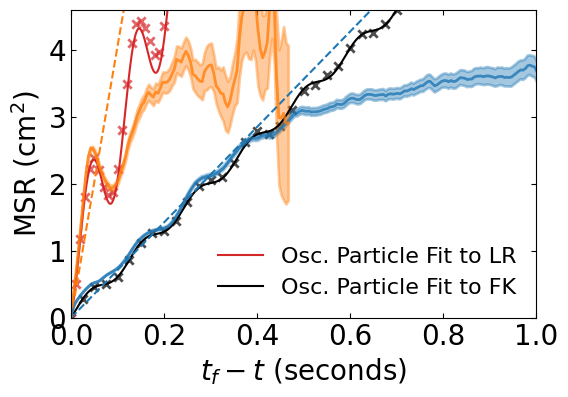

In [56]:
#plot MSR_Osc over the direct simulation results
lw=2
alpha=0.4
fontsize=16
# # figsize=(8,4.2)
# figsize=(4,4.2)
figsize=(6,4)
fontsize=15
### plot expected
fontsize=20
tscale=1e-3
fig,ax=plt.subplots(figsize=(6,4))
#plot simulated annealing fits of oscillatory particle model
phi_f = dict_osc_fit_lr['phase']
omega = dict_osc_fit_lr['omega']*1e3
a = dict_osc_fit_lr['a1']
D = dict_osc_fit_lr['a0']/2
t_values=np.linspace(0,1,1000)
# MSR_values_oscillatory=4*(a*t_values+(2*D/omega)*(np.sin(omega*t_values+phi_f))+constant
MSR_values_oscillatory=4*(2*D*t_values+(a/omega)*(np.sin(omega*t_values+phi_f)-np.sin(phi_f)))
ax.plot(t_values,MSR_values_oscillatory,c='C3',
                label=r'Osc. Particle Fit to LR')
#                 label=r'$MSR_{Osc.}(a=a_{FK},\phi_f=-\frac{\pi}{2})$')
phi_f = dict_osc_fit_fk['phase']
omega = dict_osc_fit_fk['omega']*1e3
a = dict_osc_fit_fk['a1']
D = dict_osc_fit_fk['a0']/2
# t_values=np.linspace(0,1,1000)
# MSR_values_oscillatory=4*(a*t_values+(2*D/omega)*(np.sin(omega*t_values+phi_f))+constant
MSR_values_oscillatory=4*(2*D*t_values+(a/omega)*(np.sin(omega*t_values+phi_f)-np.sin(phi_f)))
ax.plot(t_values,MSR_values_oscillatory,c='k',#'C2',
                label=r'Osc. Particle Fit to FK')

#plot the linear particle model
amax_fk = 1.781
amax_lr = 10.147
ax.plot(t_values,4*amax_fk*t_values,c='C0',linestyle='dashed')
ax.plot(t_values,4*amax_lr*t_values,c='C1',linestyle='dashed')


#plot the direct simulation of the oscillatory particle model under these same parameter settings
stepsize=2500
plt.scatter(dict_fit_fk['tdeath'][::stepsize],dict_fit_fk['MSR'][::stepsize],lw=2,alpha=.7,c='k',#'C2',
            marker='x')#,label='Simulation of Osc. (FK)')
stepsize=1000
plt.scatter(dict_fit_lr['tdeath'][::stepsize],dict_fit_lr['MSR'][::stepsize],lw=2,alpha=.7,c='C3',
            marker='x')#,label='Simulation of Osc. (LR)')


#plot msd data from full
ax.plot(x_values_fk*tscale,y_values_fk,lw=2,alpha=0.8,c='C0')
ax.fill_between(x_values_fk*tscale,y_values_fk-yerr_values_fk,y_values_fk+yerr_values_fk,lw=lw,alpha=alpha,color='C0')
ax.plot(x_values_lr*tscale,y_values_lr,lw=2,alpha=0.8,c='C1')
ax.fill_between(x_values_lr*tscale,y_values_lr-yerr_values_lr,y_values_lr+yerr_values_lr,lw=lw,alpha=alpha,color='C1')

#


#format_plot
format_plot(ax=ax,xlabel=r'$t_f-t$ (seconds)',ylabel=r'MSR (cm$^2$)',fontsize=20)
ax.tick_params(bottom=True,left=True,top=True, right=True,direction='in',which='both')
ax.legend(fontsize=16,frameon=False)

# plt.title('mean squared ranges agree\n',fontsize=18)
plt.xlim([0,1])
plt.ylim([0,4.6])
# plt.ylim([0,5.1])
# plt.ylim([0,14.1])
plt.show()

In [57]:
#extract xy values from full
x_values_fk=df_msr_fk['tdeath_avg'].values
y_values_fk=df_msr_fk['MSR'].values
yerr_values_fk=df_msr_fk['Delta_MSR'].values
x_values_lr=df_msr_lr['tdeath_avg'].values
y_values_lr=df_msr_lr['MSR'].values
yerr_values_lr=df_msr_lr['Delta_MSR'].values

In [58]:
#TODO: insert moving_average of y

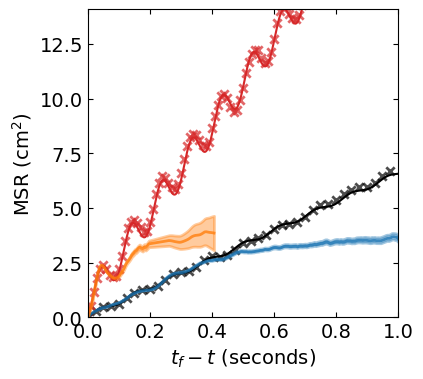

In [59]:
#plot MSR_Osc over the direct simulation results
# lw=2
# alpha=0.4
# fontsize=16
# # # figsize=(8,4.2)
# # figsize=(4,4.2)
# figsize=(6,4)
# fontsize=15
# ### plot expected
# fontsize=20
# tscale=1e-3


#plot MSR_Osc over the direct simulation results
lw=2
alpha=0.4
fontsize=14
# fontsize=18
# # figsize=(8,4.2)
# figsize=(4,4.2)
# figsize=(6,4)
# figsize=(6.1,4)
# figsize=(6,4)
figsize=(4,4)
# fontsize=15
### plot expected
# fontsize=20
tscale=1e-3

fig,ax=plt.subplots(figsize=figsize)
#plot simulated annealing fits of oscillatory particle model
phi_f = dict_osc_fit_lr['phase']
omega = dict_osc_fit_lr['omega']*1e3
a = dict_osc_fit_lr['a1']
D = dict_osc_fit_lr['a0']/2
t_values=np.linspace(0,1,1000)
# MSR_values_oscillatory=4*(a*t_values+(2*D/omega)*(np.sin(omega*t_values+phi_f))+constant
MSR_values_oscillatory=4*(2*D*t_values+(a/omega)*(np.sin(omega*t_values+phi_f)-np.sin(phi_f)))
ax.plot(t_values,MSR_values_oscillatory,c='C3')#,
#                 label=r'Osc. Particle Fit to LR')
#                 label=r'$MSR_{Osc.}(a=a_{FK},\phi_f=-\frac{\pi}{2})$')
phi_f = dict_osc_fit_fk['phase']
omega = dict_osc_fit_fk['omega']*1e3
a = dict_osc_fit_fk['a1']
D = dict_osc_fit_fk['a0']/2
# t_values=np.linspace(0,1,1000)
# MSR_values_oscillatory=4*(a*t_values+(2*D/omega)*(np.sin(omega*t_values+phi_f))+constant
MSR_values_oscillatory=4*(2*D*t_values+(a/omega)*(np.sin(omega*t_values+phi_f)-np.sin(phi_f)))
ax.plot(t_values,MSR_values_oscillatory,c='k')#,'C2', #,label=r'Osc. Particle Fit to FK')

#plot the linear particle model
amax_fk = 1.781
amax_lr = 10.147
# ax.plot(t_values,4*amax_fk*t_values,c='C0',linestyle='dashed')
# ax.plot(t_values,4*amax_lr*t_values,c='C1',linestyle='dashed')


#plot the direct simulation of the oscillatory particle model under these same parameter settings
stepsize=2500
plt.scatter(dict_fit_fk['tdeath'][::stepsize],dict_fit_fk['MSR'][::stepsize],lw=2,alpha=.7,c='k',#'C2',
            marker='x')#,label='Simulation of Osc. (FK)')
stepsize=1000
plt.scatter(dict_fit_lr['tdeath'][::stepsize],dict_fit_lr['MSR'][::stepsize],lw=2,alpha=.7,c='C3',
            marker='x')#,label='Simulation of Osc. (LR)')


# #plot msd data from full
# ax.plot(x_values_fk*tscale,y_values_fk,lw=2,alpha=0.8,c='C0',label='Fenton-Karma')
# ax.fill_between(x_values_fk*tscale,y_values_fk-yerr_values_fk,y_values_fk+yerr_values_fk,lw=lw,alpha=alpha,color='C0')
# # boo2 = x_values_lr<470
# # boo2 = x_values_lr<500
# boo2 = x_values_lr<200
# ax.plot(x_values_lr[boo2]*tscale,y_values_lr[boo2],lw=2,alpha=0.8,c='C1',label='Luo-Rudy')
# ax.fill_between(x_values_lr[boo2]*tscale,y_values_lr[boo2]-yerr_values_lr[boo2],y_values_lr[boo2]+yerr_values_lr[boo2],lw=lw,alpha=alpha,color='C1')
# # ax.plot(x_values_lr*tscale,y_values_lr,lw=2,alpha=0.8,c='C1',label='Luo-Rudy')
# # ax.fill_between(x_values_lr*tscale,y_values_lr-yerr_values_lr,y_values_lr+yerr_values_lr,lw=lw,alpha=alpha,color='C1')

#plot msd data from full with minimum subtracted (works better)
miny = float(np.min(y_values_fk))
ax.plot(x_values_fk*tscale,y_values_fk-miny,lw=2,alpha=0.8,c='C0')
ax.fill_between(x_values_fk*tscale,y_values_fk-yerr_values_fk-miny,y_values_fk+yerr_values_fk-miny,lw=lw,alpha=alpha,color='C0')
# ax.plot(x_values_fk*tscale,y_values_fk,lw=2,alpha=0.8,c='C0')
# ax.fill_between(x_values_fk*tscale,y_values_fk-yerr_values_fk,y_values_fk+yerr_values_fk,lw=lw,alpha=alpha,color='C0')

ax.plot(xlr,ylr,lw=2,alpha=0.8,c='C1')
ax.fill_between(xlr,ylr-yerrlr,ylr+yerrlr,lw=lw,alpha=alpha,color='C1')


#format_plot
format_plot(ax=ax,xlabel=r'$t_f-t$ (seconds)',ylabel=r'MSR (cm$^2$)',fontsize=fontsize)
ax.tick_params(bottom=True,left=True,top=True, right=True,direction='in',which='both')
# ax.legend(fontsize=fontsize-2,frameon=False)

# plt.title('mean squared ranges agree\n',fontsize=18)
plt.xlim([0,1])
# plt.xlim([0,4])
# plt.ylim([0,4.6])
# plt.ylim([0,5.1])
plt.ylim([0,14.1])
plt.show()

In [60]:
beep(3)

-n 
-n 
-n 


0

# plot the phases for an inset pie chart icon indicating the final phases

In [61]:
from matplotlib.lines import Line2D
from matplotlib.patches import Arc
# from math import degrees
import math

In [62]:
phase_fk = dict_osc_fit_fk['phase']
phase_lr = dict_osc_fit_lr['phase']
print(f"{phase_fk=} radians")
print(f"{phase_lr=} radians")

phase_fk=-0.5452135473156354 radians
phase_lr=-1.1620918326819276 radians


In [63]:
# phase_fk=np.pi/2
# phase_lr=np.pi/2
# 7*np.pi/24

In [64]:
from matplotlib.patches import Arc

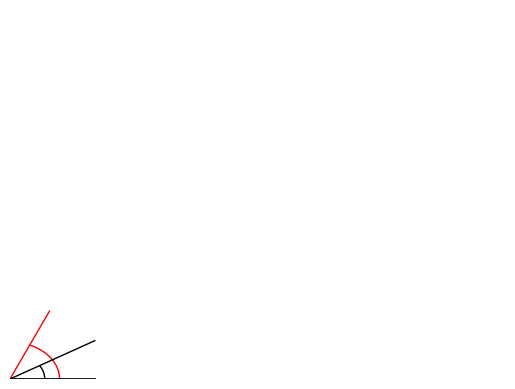

In [65]:
fig = plt.figure()
line_0 = Line2D([0,.85], [0,0], linewidth=2, linestyle = "-", color="k")

x1=np.cos(phase_fk)
y1=np.sin(-phase_fk)
line_1 = Line2D([0,x1], [0,y1], linewidth=1, linestyle = "-", color='k')#"C0")
x2=np.cos(phase_lr)
y2=np.sin(-phase_lr)
line_2 = Line2D([0,x2], [0,y2], linewidth=1, linestyle = "-", color='r')#"C1")

ax = fig.add_subplot(1,1,1)

ax.add_line(line_2)
ax.add_line(line_1)
ax.add_line(line_0)

angle_plot1 = get_angle_plot(line_1, line_0, .7)
angle_text1 = get_angle_text(angle_plot1) 
angle_plot2 = get_angle_plot(line_2, line_0, 1)
angle_text2 = get_angle_text(angle_plot2) 

ax.add_patch(angle_plot1) # To display the angle arc
# ax.text(*angle_text1) # To display the angle value
ax.add_patch(angle_plot2) # To display the angle arc
# ax.text(*angle_text2) # To display the angle value
# ax.set_xlim(-7,7)
ax.set_xlim(0,5)
ax.set_ylim(0,5)
ax.axis('off')
plt.show()

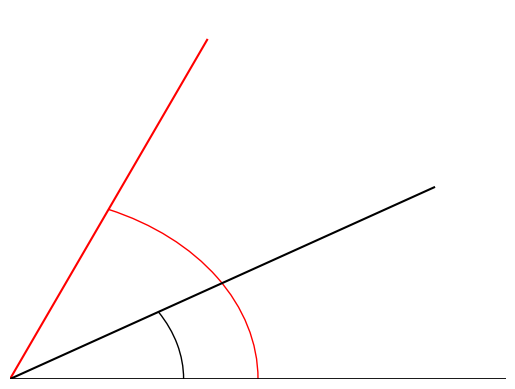

In [66]:
fig = plt.figure()
line_0 = Line2D([0,1], [0,0], linewidth=2, linestyle = "-", color="k")

x1=np.cos(phase_fk)
y1=np.sin(-phase_fk)
line_1 = Line2D([0,x1], [0,y1], linewidth=1.5, linestyle = "-", color='k')#"C0")
x2=np.cos(phase_lr)
y2=np.sin(-phase_lr)
line_2 = Line2D([0,x2], [0,y2], linewidth=1.5, linestyle = "-", color='r')#"C1")

ax = fig.add_subplot(1,1,1)

ax.add_line(line_2)
ax.add_line(line_1)
ax.add_line(line_0)

angle_plot1 = get_angle_plot(line_1, line_0, .7)
angle_text1 = get_angle_text(angle_plot1) 
angle_plot2 = get_angle_plot(line_2, line_0, 1)
angle_text2 = get_angle_text(angle_plot2) 

ax.add_patch(angle_plot1) # To display the angle arc
# ax.text(*angle_text1) # To display the angle value
ax.add_patch(angle_plot2) # To display the angle arc
# ax.text(*angle_text2) # To display the angle value
# ax.set_xlim(-7,7)
# ax.set_xlim(0,5)
# ax.set_ylim(0,5)
ax.axis('off')
plt.show()

In [67]:
# anglenp
# ax = plt.gca()
# line, = ax.plot([0, 0, 2], [np.cos(angle), np.sin(angle), 0], 'ro-', lw=2)
# add_corner_arc(ax, line, text=u'%d\u00b0' % 90)

# plot the universal fit

In [68]:
dict_osc_fit = dict(dict_osc_fit_fk)
alinear_fk = comp_alinear(a0=dict_osc_fit['a0'],
                       a1=dict_osc_fit['a1'],
                       period=dict_osc_fit['period'],
                       Gamma=dict_osc_fit['Gamma'],
                       phase=dict_osc_fit['phase'])
alinear_fk_min= comp_alinear(a0=dict_osc_fit['a0'],a1=dict_osc_fit['a1'],period=dict_osc_fit['period'],
                       Gamma=dict_osc_fit['Gamma']+dict_osc_fit['Delta_Gamma'],
                       phase=dict_osc_fit['phase'])
alinear_fk_max= comp_alinear(a0=dict_osc_fit['a0'],a1=dict_osc_fit['a1'],period=dict_osc_fit['period'],
                       Gamma=dict_osc_fit['Gamma']-dict_osc_fit['Delta_Gamma'],
                       phase=dict_osc_fit['phase'])
alinear_fk_min,alinear_fk,alinear_fk_max

#with gamma values as x
Gamma_values = np.linspace(1,3000,10000)
x_lst=[]
y_lst=[]
for Gamma in Gamma_values:
    phase=dict_osc_fit['phase']
    period=dict_osc_fit['period']
    alinear = comp_alinear(a0=dict_osc_fit['a0'],
                       a1=dict_osc_fit['a1'],
                       period=period,
                       Gamma=Gamma,
                       phase=phase)
    z = 2*np.pi*Gamma/(period)
    #record
    x_lst.append(z) #z
    y_lst.append(alinear) #alinear
z_values_fk=np.array(x_lst)
alinear_values_fk=np.array(y_lst)

In [69]:
period=dict_osc_fit['period']
Gamma=dict_osc_fit['Gamma']
Delta_Gamma=dict_osc_fit['Delta_Gamma']
z_fk = 2*np.pi*Gamma/period
z_fk_min = 2*np.pi*(Gamma-Delta_Gamma)/period
z_fk_max = 2*np.pi*(Gamma+Delta_Gamma)/period

In [70]:
dict_osc_fit = dict(dict_osc_fit_lr)
alinear_lr = comp_alinear(a0=dict_osc_fit['a0'],
                       a1=dict_osc_fit['a1'],
                       period=dict_osc_fit['period'],
                       Gamma=dict_osc_fit['Gamma'],
                       phase=dict_osc_fit['phase'])
alinear_lr_min= comp_alinear(a0=dict_osc_fit['a0'],a1=dict_osc_fit['a1'],period=dict_osc_fit['period'],
                       Gamma=dict_osc_fit['Gamma']+dict_osc_fit['Delta_Gamma'],
                       phase=dict_osc_fit['phase'])
alinear_lr_max= comp_alinear(a0=dict_osc_fit['a0'],a1=dict_osc_fit['a1'],period=dict_osc_fit['period'],
                       Gamma=dict_osc_fit['Gamma']-dict_osc_fit['Delta_Gamma'],
                       phase=dict_osc_fit['phase'])

#with gamma values as x
Gamma_values = np.linspace(1,3000,10000)
x_lst=[]
y_lst=[]
for Gamma in Gamma_values:
    phase=dict_osc_fit['phase']
    period=dict_osc_fit['period']
    alinear = comp_alinear(a0=dict_osc_fit['a0'],
                       a1=dict_osc_fit['a1'],
                       period=period,
                       Gamma=Gamma,
                       phase=phase)
    z = 2*np.pi*Gamma/(period)
    #record
    x_lst.append(z) #z
    y_lst.append(alinear) #alinear
z_values_lr=np.array(x_lst)
alinear_values_lr=np.array(y_lst)

period=dict_osc_fit['period']
Gamma=dict_osc_fit['Gamma']
Delta_Gamma=dict_osc_fit['Delta_Gamma']
z_lr = 2*np.pi*Gamma/period
z_lr_min = 2*np.pi*(Gamma-Delta_Gamma)/period
z_lr_max = 2*np.pi*(Gamma+Delta_Gamma)/period

In [71]:
y_values_fk = (alinear_values_fk - dict_osc_fit_fk['a0'])/dict_osc_fit_fk['a1']
y_values_lr = (alinear_values_lr - dict_osc_fit_lr['a0'])/dict_osc_fit_lr['a1']

y_fk = (alinear_fk - dict_osc_fit_fk['a0'])/dict_osc_fit_fk['a1']
y_fk_min = (alinear_fk_min - dict_osc_fit_fk['a0'])/dict_osc_fit_fk['a1']
y_fk_max = (alinear_fk_max - dict_osc_fit_fk['a0'])/dict_osc_fit_fk['a1']

y_lr = (alinear_lr - dict_osc_fit_lr['a0'])/dict_osc_fit_lr['a1']
y_lr_min = (alinear_lr_min - dict_osc_fit_lr['a0'])/dict_osc_fit_lr['a1']
y_lr_max = (alinear_lr_max - dict_osc_fit_lr['a0'])/dict_osc_fit_lr['a1']

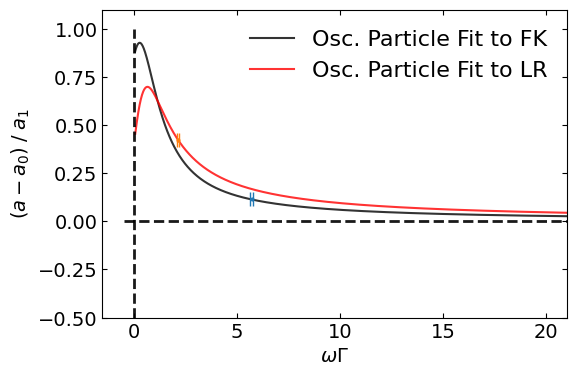

In [72]:
fig,ax=plt.subplots(figsize=(6,4))
# xlabel='z'
xlabel=r'$\omega\Gamma$'
ylabel=r'$( a-a_0 )\;/\; a_1$'
# ylabel=r'$\frac{a-a_0}{a_1}$'

ax.plot(z_values_fk,y_values_fk,c='k',alpha=0.8,label=r'Osc. Particle Fit to FK')#)#,c='C0')
ax.plot(z_values_lr,y_values_lr,c='r',alpha=0.8,label=r'Osc. Particle Fit to LR')#)#,c='C1')


#plot measurement + errorbar uncertainty for the FK model (blue)
ax.errorbar(x=z_fk, 
            y=y_fk, 
            xerr=0.5*(z_fk_max-z_fk_min), 
#             yerr=0.5*(y_fk_max-y_fk_min), 
            fmt='o',markersize=2,capsize=5,lw=2,
            color='C0')
#             label='Fenton-Karma')
#             label=r'Osc. Particle Fit to FK')

#plot measurement + errorbar uncertainty for the LR model (orange)
ax.errorbar(x=z_lr, 
            y=y_lr, 
            xerr=0.5*(z_lr_max-z_lr_min), 
#             yerr=0.5*(y_lr_max-y_lr_min), 
            fmt='o',markersize=2,capsize=5,lw=2,
            color='C1')
# #             label='Luo-Rudy')
#             label=r'Osc. Particle Fit to LR')

#plot dotted line at y-axis=0 (black)
xv=np.linspace(-0.5,40,10)
ax.plot(xv,0.*xv,'k--',alpha=0.9,lw=2)
#plot dotted line at x-axis=0 (black)
xv=np.linspace(-0.5,1,10)
ax.plot(0.*xv,xv,'k--',alpha=0.9,lw=2)


#format_plot
format_plot(ax=ax,xlabel=r'$t_f-t$ (seconds)',ylabel=r'MSR (cm$^2$)',fontsize=20)
ax.legend(fontsize=16,frameon=False)
ax.tick_params(bottom=True,left=True,top=True, right=True,direction='in',which='both')
ax.set_xlim((-1.5250000000000001, 21.025))

format_plot(ax=ax,xlabel=xlabel, ylabel=ylabel,fontsize=fontsize)
ax.set_ylim(-0.5,1.1)
plt.show()
# plt.yscale('log')

In [73]:
beep(3)

-n 
-n 
-n 


0

# print table of particle properties

In [74]:
#DONE: add symbols for full models
#DONE: update Fig. 4
#TODO: update table in main text in the form
# ----------------------------------------------------------------------
# symbol | description | Fenton-Karma measurement | Luo-Rudy Measurement
# ----------------------------------------------------------------------
# Gamma | Mean minimum lifetime | ?? | ?? etc...

In [75]:
kwargs_table_1_level=dict(float_format="{:0.4f}".format,
#                           multicolumn_format='c',
                           column_format='c',
#                            caption=('Table. ?? shows full\_caption', 'Table. ?? short\_caption.'),
#                            longtable=True #Requires adding a usepackage{longtable} to your LaTeX preamble.
                          )
kwargs_table_2_levels=dict(float_format="{:0.4f}".format,
                          multicolumn_format='c',
#                            column_format='c',
#                            caption=('Table. ?? shows full\_caption', 'Table. ?? short\_caption.'),
#                            longtable=True #Requires adding a usepackage{longtable} to your LaTeX preamble.
                          )

In [76]:
dffk=pd.DataFrame([dict_osc_fit_fk])
dflr=pd.DataFrame([dict_osc_fit_lr])
dffk['model']='Fenton-Karma'
dflr['model']='Luo-Rudy'
df_osc_fits = pd.concat((dffk,dflr))
df_osc_fits['amax'] = df_osc_fits['alinear'] 
# list(df_osc_fits.columns)
# df_osc_fits = df_osc_fits[['model', 'amax', 'a0', 'a1', 'period', 'phase', 'rmse', 'omega', 'z']].copy().T
# df_osc_fits = df_osc_fits[['model', 'amax', 'a0', 'a1', 'period', 'phase', 'z', 'rmse']].copy().T
df_osc_fits = df_osc_fits.set_index('model',drop=True)[['amax', 'a0', 'a1', 'period', 'phase', 'z', 'rmse']].copy().T
print("%simulated annealing fits:")
print("% \\begin{ruledtabular}")
print("% \\begin{tabular}{cccccc}")
print(df_osc_fits.to_latex(index=True, 
                                caption='Table of oscillatory particle properties for spiral tip from the full models.}\label{tab:properties}',
                                     **kwargs_table_1_level))

%simulated annealing fits:
% \begin{ruledtabular}
% \begin{tabular}{cccccc}
\begin{table}
\centering
\caption{Table of oscillatory particle properties for spiral tip from the full models.}\label{tab:properties}}
\begin{tabular}{c}
\toprule
model &  Fenton-Karma &  Luo-Rudy \\
\midrule
amax   &        1.7814 &   10.1468 \\
a0     &        1.6357 &    5.0184 \\
a1     &        1.2827 &   12.1679 \\
period &      115.9141 &   97.4755 \\
phase  &       -0.5452 &   -1.1621 \\
z      &        5.7089 &    2.1507 \\
rmse   &        0.0284 &    0.0642 \\
\bottomrule
\end{tabular}
\end{table}



In [77]:
#format table of fitted parameter values
L=5.0
D=0
dict_osc_fit_fk['num_termination_events']=num_termination_events_fk
dict_osc_fit_lr['num_termination_events']=num_termination_events_lr
dict_properties_fk=dict(dict_osc_fit_fk)
dict_properties_lr=dict(dict_osc_fit_lr)
dict_properties_fk['L']=L
dict_properties_lr['L']=L
dict_properties_fk.update(dict_SR_fk)
dict_properties_lr.update(dict_SR_lr)
dict_properties_fk['model']='Fenton-Karma'
dict_properties_lr['model']='Luo-Rudy'
df_properties = pd.DataFrame([dict_properties_fk,dict_properties_lr])
df_properties['amax']=df_properties['alinear'] + 2*D

print(f"Table of simulated annealing fits of oscillatory particle model to full models.")
print(df_properties[['model','amax','L','rmse']])

Table of simulated annealing fits of oscillatory particle model to full models.
          model       amax    L      rmse
0  Fenton-Karma   1.781445  5.0  0.028434
1      Luo-Rudy  10.146773  5.0  0.064175


In [78]:
annihil_fits_dir='/Users/timothytyree/Documents/GitHub/bgmc/python/data/annihil_fits.25.29.csv'
df_annihil_fits = pd.read_csv(annihil_fits_dir)
df_annihil_fits
print(f"Table of maximum likelihood fits of linear particle model to full models.")
print(df_annihil_fits[['model','amax','L','rmse']])

Table of maximum likelihood fits of linear particle model to full models.
          model    amax     L      rmse
0  Fenton-Karma   1.781   5.0  0.140241
1  Fenton-Karma   1.780  10.0  0.190422
2      Luo-Rudy  10.149   5.0  0.194177
3      Luo-Rudy  10.147  10.0  0.119033


In [79]:
print("\n% df_table_properties")
print(f"% \caption{{Table of spiral tip properties for the full models.}}")
df_table_properties=df_properties.sort_values(by='model')\
                .set_index('model')[['amax','L','rmse','meanSR','Delta_meanSR']].T
print(df_table_properties)


% df_table_properties
% \caption{Table of spiral tip properties for the full models.}
model         Fenton-Karma   Luo-Rudy
amax              1.781445  10.146773
L                 5.000000   5.000000
rmse              0.028434   0.064175
meanSR            0.443453   0.739637
Delta_meanSR      0.006676   0.015766


In [80]:
print("\n% df_table_properties_brief")
print(f"% \caption{{Brief table of spiral tip properties for the full models.}}")
df_table_properties_brief=df_properties.sort_values(by='model')\
                .set_index('model')[['amax','L','rmse']]
# print(df_table_properties_brief)
print("% \\begin{ruledtabular}")
print("% \\begin{tabular}{cccccc}")
print(df_table_properties_brief.reset_index().to_latex(index=False, 
                                                   caption='Brief table of spiral tip properties for the full models.}\label{tab:df_table_properties_complete}',
                                                   **kwargs_table_1_level))#kwargs_table_2_levels))



% df_table_properties_brief
% \caption{Brief table of spiral tip properties for the full models.}
% \begin{ruledtabular}
% \begin{tabular}{cccccc}
\begin{table}
\centering
\caption{Brief table of spiral tip properties for the full models.}\label{tab:df_table_properties_complete}}
\begin{tabular}{c}
\toprule
       model &    amax &      L &   rmse \\
\midrule
Fenton-Karma &  1.7814 & 5.0000 & 0.0284 \\
    Luo-Rudy & 10.1468 & 5.0000 & 0.0642 \\
\bottomrule
\end{tabular}
\end{table}



In [81]:
# #format as pandas table
mindex_lst=['model', 'L']
df_fit = df_annihil_fits.sort_values(by=mindex_lst,ascending=False)\
               .set_index(mindex_lst)
df_fit['delta'] = np.pi*df_fit['r']**2*df_fit['kappa']
df_params_linear=df_fit[['r','kappa', 'delta','D']].T
# print(df_params_linear)
print("\n% df_params_linear")
print("% \begin{ruledtabular}")
print("% \begin{tabular}{cccccc}")
print(df_params_linear.reset_index().to_latex(index=False, 
                                                   caption='Table of properties of the linear particle model fit to mean pair-annihilation rates of the full models.}\label{tab:df_table_properties_complete',
                                                   **kwargs_table_2_levels))#kwargs_table_1_level))#


% df_params_linear
% egin{ruledtabular}
% egin{tabular}{cccccc}
\begin{table}
\centering
\caption{Table of properties of the linear particle model fit to mean pair-annihilation rates of the full models.}\label{tab:df_table_properties_complete}
\begin{tabular}{lrrrr}
\toprule
index & \multicolumn{2}{c}{Luo-Rudy} & \multicolumn{2}{c}{Fenton-Karma} \\
      &     10.0 &      5.0 &         10.0 &      5.0 \\
\midrule
    r &   0.1400 &   0.1000 &       0.0950 &   0.0200 \\
kappa & 350.0000 & 370.0000 &     250.0000 & 880.0000 \\
delta &  21.5513 &  11.6239 &       7.0882 &   1.1058 \\
    D &   0.0500 &   0.0900 &       0.0500 &   0.1140 \\
\bottomrule
\end{tabular}
\end{table}



In [82]:
np.sqrt(0.443453)     , np.sqrt(0.739637)

(0.6659226681830256, 0.860021511358873)

In [83]:
print("\n% df_table_properties_complete")
print(f"% \caption{{Supplementary table of spiral tip properties for the full models.}}")
df_table_properties_complete=df_properties.sort_values(by='model')\
                .set_index('model').T
print(df_table_properties_complete)


% df_table_properties_complete
% \caption{Supplementary table of spiral tip properties for the full models.}
model                   Fenton-Karma      Luo-Rudy
a0                          1.635744      5.018436
a1                          1.282698     12.167933
period                    115.914058     97.475481
phase                      -0.545214     -1.162092
rmse                        0.028434      0.064175
alinear                     1.781445     10.146773
omega                       0.054206      0.064459
z                           5.708904      2.150740
Gamma                     105.319550     33.365940
Delta_Gamma                 1.643831      0.713267
num_obs                 36179.000000  15273.000000
p_normal                    0.464807      0.444701
num_termination_events     80.000000    595.000000
L                           5.000000      5.000000
meanSR                      0.443453      0.739637
Delta_meanSR                0.006676      0.015766
num_obsSR              

In [84]:
print("\n% df_table_properties_complete")
print("% \begin{ruledtabular}")
print("% \begin{tabular}{cccccc}")
print(df_table_properties_complete.reset_index().to_latex(index=False, 
                                                   caption='Supplementary table of spiral tip properties for the full models.}\label{tab:df_table_properties_complete',
                                                   **kwargs_table_1_level))#kwargs_table_2_levels))



% df_table_properties_complete
%egin{ruledtabular}
%egin{tabular}{cccccc}
\begin{table}
\centering
\caption{Supplementary table of spiral tip properties for the full models.}\label{tab:df_table_properties_complete}
\begin{tabular}{c}
\toprule
                 index &  Fenton-Karma &   Luo-Rudy \\
\midrule
                    a0 &        1.6357 &     5.0184 \\
                    a1 &        1.2827 &    12.1679 \\
                period &      115.9141 &    97.4755 \\
                 phase &       -0.5452 &    -1.1621 \\
                  rmse &        0.0284 &     0.0642 \\
               alinear &        1.7814 &    10.1468 \\
                 omega &        0.0542 &     0.0645 \\
                     z &        5.7089 &     2.1507 \\
                 Gamma &      105.3196 &    33.3659 \\
           Delta\_Gamma &        1.6438 &     0.7133 \\
               num\_obs &    36179.0000 & 15273.0000 \\
              p\_normal &        0.4648 &     0.4447 \\
num\_termination\_events &   

### fits of D from MSD

(Fenton-Karma) msd powerlaw fit of msd from lagt=0.1 to 3:
- m = 1.001994 +/- 0.015057
- M = 0.005766 +/- 0.000384 Hz/cm^2; B=0.005826 +/- 0.000076
- RMSE=0.0008 Hz/cm^2; R^2=0.9921; N=138
- D = 0.0014 +/- 0.0001 cm^2/s

(Luo-Rudy) msd powerlaw fit of msd from lagt=0.06 to 0.2:
- m = 0.981067 +/- 0.044880
- M = 0.148857 +/- 0.005591 Hz/cm^2; B=0.143485 +/- 0.007501
- RMSE=0.0011 Hz/cm^2; R^2=0.9750; N=49
- D = 0.0372 +/- 0.0014 cm^2/s

src: http://localhost:8889/notebooks/demonstration%20of%20brownian%20behaviour.ipynb



### fits of alinear from dR/dt 

(Fenton-Karma) linear fit of dRdt from 1/R=0.0 to 10:
- m=-4.550823917522961
- Delta_m=0.8299672832720622
- b=-0.7883724177008169
- Delta_b=1.5044154352605568
- Rsquared=0.7674370424368964
- num_obs=37
- rmse=3.1625294434003433
- Rsq=0.7674370424368964
- ahat = 2.2754 +/- 0.4150 cm^2/s

(Luo-Rudy) linear fit of dRdt from 1/R=0.0 to 10:
- m=-8.087927742495596
- Delta_m=0.4593631505563615
- b=-2.310333356275457
- Delta_b=0.7439196689530453
- Rsquared=0.9635892116333213
- num_obs=47
- rmse=1.8623782485431748
- Rsq=0.9635892116333213
- ahat = 4.0440 +/- 0.2297 cm^2/s

src: http://localhost:8889/notebooks/demonstration%20of%20brownian%20behaviour.ipynb

### estimates of rotational period from instantaneous period timeseries

- mean median rotational periods: 117.0490 ms (FK)
- period from simulated annealing: 115.94 ms (FK)

- mean median rotational periods: 144.3268 ms (LR)
- period from simulated annealing: 97.36 ms (LR)

src: http://localhost:8889/notebooks/computing%20rotational%20period%20of%20mean%20fortranic%20spiral%20trajectories.ipynb

### estimates of rotational period from total self-crossings

Fenton-Karma:
- number_termination_events_considered: 20
- total number of loops observed longer than 10ms: 11293
- (number of particles considered: 22694)
- (mean number of loops per particle lifetime: 0.4976)
- number of particles considered with at least 1 loop: 12368
- mean number of loops per particle lifetime (at least 1 loop): 0.9131
- expected num. revolutions per lifetime: lifetime_fk/period_fk=0.9082

Luo-Rudy:
- number_termination_events_considered: 639
- total number of loops observed longer than 10ms: 10108
- (number of particles considered with at least 1 loop: 3644)
- (mean number of loops per particle lifetime (at least 1 loop): 2.7739)
- number of particles considered: 29402
- mean number of loops per particle lifetime: 0.3438
- expected num. revolutions per lifetime: lifetime_lr/period_lr=0.3427

src: http://localhost:8889/notebooks/computing%20rotational%20period%20of%20mean%20fortranic%20spiral%20trajectories.ipynb

# fit powerlaws to birth rates

In [85]:
# input_fn = search_for_file()
# input_fn
kwargs = dict(data_fk_dir=f'{nb_dir}/data/full_results/data_fig4_vidmar_fk_tt.csv',
              data_lr_dir=f'{nb_dir}/data/full_results/data_fig4_vidmar_lr_tt.csv',
             min_num_particles=9)
dict_wjr = recall_death_rates_vidmar_rappel(**kwargs)
fk=dict_wjr['fk'].sort_values(by='q')
lr=dict_wjr['lr'].sort_values(by='q')


In [86]:
nb_dir

'/Users/timothytyree/Documents/GitHub/bgmc/python'

In [87]:
# birth_rate_dir_fk = '/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/data_fig4_timothy_fk_up2_rescaled_per_tt.csv'
# birth_rate_dir_lr = '/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/data_fig4_timothy_lr_up2_rescaled_per_tt.csv'
birth_rate_dir_fk = f'{nb_dir}//data/full_results/data_fig4_timothy_fk_up2_rescaled_per_tt.csv'
birth_rate_dir_lr = f'{nb_dir}//data/full_results/data_fig4_timothy_lr_up2_rescaled_per_tt.csv'
# death_rate_dir_fk = '/Users/timothytyree/Documents/GitHub/bgmc/python/data/full_results/data_fig4_vidmar_fk_rescaled_rates.csv'
# death_rate_dir_lr = '/Users/timothytyree/Documents/GitHub/bgmc/python/data/full_results/data_fig4_vidmar_lr_rescaled_rates.csv'
# df_death = pd.read_csv(death_rate_dir_fk)
df_birth_fk = pd.read_csv(birth_rate_dir_fk)
# df_death = pd.read_csv(death_rate_dir_lr)
df_birth_lr = pd.read_csv(birth_rate_dir_lr)

#scale from kHz to Hz
df_birth_fk['w']*=1e3
df_birth_lr['w']*=1e3

In [88]:
# DONE: compute powerlaw fits of birth rates wjr
dict_fit_birth_fk = print_fit_power_law(x=df_birth_fk['q'].values,y=df_birth_fk['w'].values)
dict_fit_birth_lr = print_fit_power_law(x=df_birth_lr['q'].values,y=df_birth_lr['w'].values)

print(f"\nwjr['fk_pbc']:")
print_dict(wjr['fk_pbc'])
print(f"\nwjr['lr_pbc']:")
print_dict(wjr['lr_pbc'])

print(f"\nwjr['fk_pbc']:")
print_dict(wjr['fk_pbc'])
print(f"\nwjr['lr_pbc']:")
print_dict(wjr['lr_pbc'])

m = 0.229594 +/- 0.010098
M = 0.864210 +/- 0.002349 Hz/cm^2; B=0.529597 +/- 0.020570
RMSE=0.0215 Hz/cm^2; R^2=0.9655; MPE=3.0209%; N=73
m = 0.714755 +/- 0.009768
M = 3.277073 +/- 0.102643 Hz/cm^2; B=5.262676 +/- 0.107278
RMSE=0.0417 Hz/cm^2; R^2=0.9971; MPE=4.2323%; N=62

wjr['fk_pbc']:
m=1.8772341309722325
Delta_m=0.02498750277237229
M=5.572315674840435
Delta_M=0.3053120355191732
b=1.665608066257863
Delta_b=0.029341409948945123

wjr['lr_pbc']:
m=1.6375562704001745
Delta_m=0.017190912126700632
M=16.73559858353835
Delta_M=0.8465090320196467
b=2.86877101880514
Delta_b=0.0311865277365552

wjr['fk_pbc']:
m=1.8772341309722325
Delta_m=0.02498750277237229
M=5.572315674840435
Delta_M=0.3053120355191732
b=1.665608066257863
Delta_b=0.029341409948945123

wjr['lr_pbc']:
m=1.6375562704001745
Delta_m=0.017190912126700632
M=16.73559858353835
Delta_M=0.8465090320196467
b=2.86877101880514
Delta_b=0.0311865277365552


In [89]:
xv = np.arange(0.02, 1,0.01)
# evaluate powerlaw fits of birth rates wjr
yv_birth_lr = dict_fit_birth_lr['M']*xv**dict_fit_birth_lr['m']
yv_death_lr = wjr['lr_pbc']['M']*xv**wjr['lr_pbc']['m']
# evalutate plot powerlaw fits of death rates wjr
yv_birth_fk = dict_fit_birth_fk['M']*xv**dict_fit_birth_fk['m']
yv_death_fk = wjr['fk_pbc']['M']*xv**wjr['fk_pbc']['m']
# yv_birth_lr.shape,yv_birth_fk.shape

#compute the intersection point for both of the full models
index_fk = np.argmin(np.exp(np.log(yv_birth_fk/yv_death_fk)**2))
qstar_fk = xv[index_fk]
wstar_fk = yv_birth_fk[index_fk]
# index_lr = np.argmin(np.log(yv_birth_lr/yv_death_lr)**2)
index_lr = np.argmin(np.exp(np.log(yv_birth_lr/yv_death_lr)**2))
qstar_lr = xv[index_lr]
wstar_lr = yv_birth_lr[index_lr]
qstar_lr

0.16999999999999996

In [90]:
# plt.plot(xv,(yv_birth_lr-yv_death_lr)**2)
# plt.show()
qstar_fk,qstar_lr

(0.31999999999999995, 0.16999999999999996)

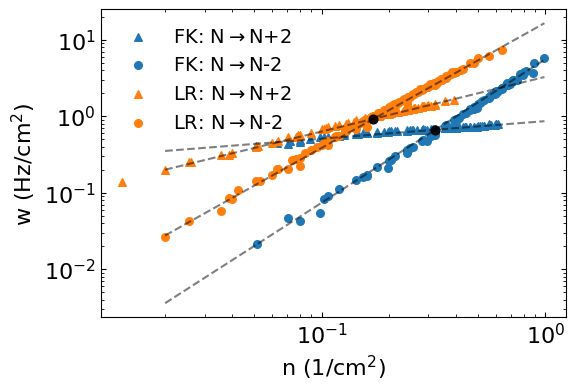

In [91]:
# fig,ax=plt.subplots()
fig,ax=plt.subplots(figsize=(6,4))
fontsize=16
# fontsize=20
alpha=0.9

# df_birth_fk.plot(x='q',y='w',ax=ax,c='C0',alpha=0.5,label=r'FK: N$\rightarrow$N+2',lw=4)
# fk.plot(x='q',y='w',ax=ax,c='C0',label=r'FK: N$\rightarrow$N-2',lw=4)
# df_birth_lr.plot(x='q',y='w',ax=ax,c='C1',alpha=0.5,label=r'LR: N$\rightarrow$N+2',lw=4)
# lr.plot(x='q',y='w',ax=ax,c='C1',label=r'LR: N$\rightarrow$N-2',lw=4)
markersize=30
df_birth_fk.plot.scatter(x='q',y='w',ax=ax,c='C0',#'gray',#
                         marker='^',
                         alpha=1.,label=r'FK: N$\rightarrow$N+2',s=markersize)
fk.plot.scatter(x='q',y='w',ax=ax,c='C0',label=r'FK: N$\rightarrow$N-2',s=markersize)
df_birth_lr.plot.scatter(x='q',y='w',ax=ax,c='C1',#'r',#
                        marker='^',
                         alpha=1.,label=r'LR: N$\rightarrow$N+2',s=markersize)
lr.plot.scatter(x='q',y='w',ax=ax,c='C1',label=r'LR: N$\rightarrow$N-2',s=markersize)


#plot the powerlaw fits
ax.plot(xv,yv_death_fk,'k--',alpha=0.5)
ax.plot(xv,yv_death_lr,'k--',alpha=0.5)
ax.plot(xv,yv_birth_fk,'k--',alpha=0.5)
ax.plot(xv,yv_birth_lr,'k--',alpha=0.5)

#draw vertical dotted line up to the intersection point for both of the full models
ax.scatter([qstar_fk],[wstar_fk],c='k',s=40,alpha=0.9,zorder=100)
ax.scatter([qstar_lr],[wstar_lr],c='k',s=40,alpha=0.9,zorder=100)
# ax.plot([qstar_fk,qstar_fk],[0.001,wstar_fk],'k:',alpha=0.9)
# ax.plot([qstar_lr,qstar_lr],[0.001,wstar_lr],'k:',alpha=0.9)


# format_plot
format_plot(ax=ax,xlabel=r'n (1/cm$^2$)',ylabel=r'w (Hz/cm$^2$)',fontsize=fontsize)#,use_loglog=True)
# format_plot(ax=ax,xlabel=r'q (1/cm$^2$)',ylabel=r'w (Hz/cm$^2$)',fontsize=fontsize)#,use_loglog=True)
# plt.legend(fontsize=16,frameon=False,loc='upper left')
plt.legend(fontsize=14,frameon=False,loc='upper left')
# AddLegend(loc='upper left')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim((0.0023641776732192935, 25.08908114695242))
ax.tick_params(top=True, right=True,direction='in',which='both')

plt.show()

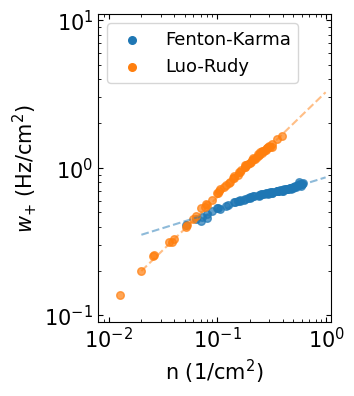

In [92]:
# figsize=(6,4)
figsize=(3,4)
fig,ax=plt.subplots(figsize=figsize)
# fontsize=16
fontsize=15
# x1lim=[0.008, 11]
x1lim=[0.008, 1.1]
# x2lim=[0.01, 250]
x2lim=[0.09, 11]
legend_alpha=1.0
minx=0.1
alpha=0.2
s=40
# fontsize=18
use_loglog=True
frameon_legend=False
show_fk=True
show_lr=True
zorder=0
# df_birth_fk.plot(x='q',y='w',ax=ax,c='C0',alpha=0.5,label=r'FK: N$\rightarrow$N+2',lw=4)
# fk.plot(x='q',y='w',ax=ax,c='C0',label=r'FK: N$\rightarrow$N-2',lw=4)
# df_birth_lr.plot(x='q',y='w',ax=ax,c='C1',alpha=0.5,label=r'LR: N$\rightarrow$N+2',lw=4)
# lr.plot(x='q',y='w',ax=ax,c='C1',label=r'LR: N$\rightarrow$N-2',lw=4)
markersize=30
df_birth_fk.plot.scatter(x='q',y='w',ax=ax,c='C0',#'gray',#
#                          marker='^',label=r'FK: N$\rightarrow$N+2',
                         label=r'Fenton-Karma',
                         alpha=0.7,#1.,
                         s=markersize)
# fk.plot.scatter(x='q',y='w',ax=ax,c='C0',label=r'FK: N$\rightarrow$N-2',s=markersize)
df_birth_lr.plot.scatter(x='q',y='w',ax=ax,c='C1',#'r',#
#                         marker='^',label=r'LR: N$\rightarrow$N+2',
                         label=r'Luo-Rudy',
                         alpha=0.7,#1.,
                         s=markersize)
# lr.plot.scatter(x='q',y='w',ax=ax,c='C1',label=r'LR: N$\rightarrow$N-2',s=markersize)

#plot the powerlaw fits
# ax.plot(xv,yv_death_fk,'k--',alpha=0.5)
# ax.plot(xv,yv_death_lr,'k--',alpha=0.5)
# ax.plot(xv,yv_birth_fk,'k--',alpha=0.5)
# ax.plot(xv,yv_birth_lr,'k--',alpha=0.5)
ax.plot(xv,yv_birth_fk,'C0--',alpha=0.5)
ax.plot(xv,yv_birth_lr,'C1--',alpha=0.5)

# #draw vertical dotted line up to the intersection point for both of the full models
# ax.scatter([qstar_fk],[wstar_fk],c='k',s=40,alpha=0.9,zorder=100)
# ax.scatter([qstar_lr],[wstar_lr],c='k',s=40,alpha=0.9,zorder=100)
# ax.plot([qstar_fk,qstar_fk],[0.001,wstar_fk],'k:',alpha=0.9)
# ax.plot([qstar_lr,qstar_lr],[0.001,wstar_lr],'k:',alpha=0.9)

ax.tick_params(top=True, right=True,direction='in',which='both')
format_plot(ax=ax,xlabel=r'$n$ (1/cm$^2$)',ylabel=r'$w_-$ (Hz/cm$^2$)',fontsize=fontsize,use_loglog=True)
# format_plot(ax=ax,xlabel=r'$q$ (1/cm$^2$)',ylabel=r'$w_-$ (Hz/cm$^2$)',fontsize=fontsize,use_loglog=True)
# ax.legend(loc='upper left',fontsize=fontsize-2)
# ax.legend(loc='lower right',fontsize=fontsize-2.,frameon=False,ncol=2)
# leg = ax.legend(loc=(1.04,0.2),fontsize=fontsize-2.,frameon=False)
# figsize=(3,4)
# fontsize=15
leg = ax.legend(loc='upper left',fontsize=fontsize-2.)#,frameon=False,ncol=1)
# leg = ax.legend(loc='lower right',fontsize=fontsize-3.,frameon=False,ncol=1)
for lh in leg.legendHandles: 
    lh.set_alpha(1)

# format_plot
format_plot(ax=ax,xlabel=r'n (1/cm$^2$)',ylabel=r'$w_{+}$ (Hz/cm$^2$)',fontsize=fontsize)#,use_loglog=True)
# format_plot(ax=ax,xlabel=r'n (1/cm$^2$)',ylabel=r'w (Hz/cm$^2$)',fontsize=fontsize)#,use_loglog=True)
# format_plot(ax=ax,xlabel=r'q (1/cm$^2$)',ylabel=r'w (Hz/cm$^2$)',fontsize=fontsize)#,use_loglog=True)
# plt.legend(fontsize=14,frameon=False,loc='upper left')
# ax.get_legend().remove()
# AddLegend(loc='upper left')
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim((0.0023641776732192935, 25.08908114695242))
ax.tick_params(top=True, right=True,direction='in',which='both')
# ax.set_xlim((0.008, 11.0))
# ax.set_ylim((0.01, 250.0))
ax.set_xlim(x1lim)
ax.set_ylim(x2lim)
plt.show()

In [93]:
fontsize

15

In [94]:
# fk.plot.scatter(x='q',y='w',ax=ax,c='C0',label=r'FK: N$\rightarrow$N-2',s=markersize)
# df_birth_lr.plot.scatter(x='q',y='w',ax=ax,c='r',#'C1',
#                          alpha=0.5,label=r'LR: N$\rightarrow$N+2',s=markersize)
# lr.plot.scatter(x='q',y='w',ax=ax,c='C1',label=r'LR: N$\rightarrow$N-2',s=markersize)


In [95]:
x_values = fk['q'].values
y_values = fk['w'].values
yhat_values = wjr['fk_pbc']['M']*x_values**wjr['fk_pbc']['m']
rmse_fk = np.sqrt(np.mean(yhat_values - y_values)**2)
num_obs = yhat_values.shape[0]
print(f"for powerlaw fit of annihil. rates of Fenton-Karma, RMSE = {rmse_fk:.4f} ({num_obs=}).")


x_values = lr['q'].values
y_values = lr['w'].values
yhat_values = wjr['lr_pbc']['M']*x_values**wjr['lr_pbc']['m']
rmse_fk = np.sqrt(np.mean(yhat_values - y_values)**2)
num_obs = yhat_values.shape[0]
print(f"for powerlaw fit of annihil. rates of Luo-Rudy, RMSE = {rmse_fk:.4f} ({num_obs=}).")

for powerlaw fit of annihil. rates of Fenton-Karma, RMSE = 0.0530 (num_obs=73).
for powerlaw fit of annihil. rates of Luo-Rudy, RMSE = 0.0684 (num_obs=100).


In [96]:
#TODO: compute rmse of birth rates
#TODO: print powerlaw fits of birth rates
#TODO: add to table 1


In [97]:
model_name_lst=['Fenton-Karma','Luo-Rudy']
s_lst=[0.0530, 0.0684]

# Analysis Following Master Equation Ansatz


$$
\frac{dP (n,t)}{dt} = \sum_r [W_r(n-r)P(n-r,t)-W_r(n)P(n,t)].
$$

For periodic boundary conditions, we are only concerned with $r=\pm2$.

$$
\frac{dP (n,t)}{dt} = W_{-2}(n-(-2))P(n-(-2),t)-W_{-2}(n)P(n,t) \\
    + W_{+2}(n-(+2))P(n-(+2),t)-W_{+2}(n)P(n,t)
$$

$$
\frac{dP (n,t)}{dt} = W_{-2}(n+2)P(n+2,t)-W_{-2}(n)P(n,t) \\
    + W_{+2}(n-2)P(n-2,t)-W_{+2}(n)P(n,t)
$$

The quasistationary state is defined by setting the left hand side to zero and solving for $P_{qs}(n)=P(n)$.

Base Case: n=2 particles

$$
0 \overset{!}{=} \frac{dP (2,t)}{dt} = W_{-2}(2+2)P(2+2)-W_{-2}(2)P(2) \\
    + W_{+2}(2-2)P(2-2)-W_{+2}(2)P(2) \\
    = W_{-2}(4)P(4)-W_{-2}(2)P(2) + 0-W_{+2}(2)P(2)
$$

Therefore, 

$$P(4) = P(2) \bigg(\frac{W_{-2}(2)+W_{+2}(2)}{W_{-2}(4)}\bigg).$$


the next case is just as simple:
$$
P(n+2) =\frac{1}{W_{-2}(n+2)}\bigg( (W_{+2}(n) + W_{-2}(n))P(n) - W_{+2}(n-2)P(n-2)  \bigg)
$$


The predicted mean termination time is given using the quasistatic distribution to compute the net rate of reactions that result in immediate termination.
For us,

$$
\frac{1}{\tau} = W_{-2}(2)P(2)
$$


In general,
$$
\frac{1}{\tau} = \sum_{r<0}W_r(-r)P(-r).
$$

In [98]:
#DONE: get token inputs prepared
dict_fit_death_lr = dict(wjr['lr_pbc'])
dict_fit_death_fk = dict(wjr['fk_pbc'])
Mp = dict_fit_birth_fk['M']
nup = dict_fit_birth_fk['m']
Mm = dict_fit_death_fk['M']
num = dict_fit_death_fk['m']
model_name='Fenton-Karma'

# Mp = dict_fit_birth_lr['M']
# nup = dict_fit_birth_lr['m']
# Mm = dict_fit_death_lr['M']
# num = dict_fit_death_lr['m']
# model_name='Luo-Rudy'


#estimate the quasistatic distribution
L=5 #cm
A=L**2
num_iter=20
comp_Wp = get_comp_W(A,nup,Mp)
comp_Wm = get_comp_W(A,num,Mm)
n_qs,prob_qs = comp_quasistatic_distrib_paired_bdrates(comp_Wm,comp_Wp,num_iter=num_iter,freq_prev=1.) #correct qs
# n_qs,prob_qs = comp_quasistatic_distrib_paired_bdrates(comp_Wm,comp_Wp,num_iter=num_iter,freq_prev=100.) #correct qs

Fenton-Karma (A=25 cm^2):
- mean num particles (qstar*A): 8.075000000000006
- mean num particles (correct qs distr): 7.624837359362673
- mean num particles (incorrect qs distr): 4.5287077772353275
- b.o.e. est. of mean termination time (correct qs distr): 15.1593 s
- b.o.e. est. of mean termination time (incorrect qs distr): 4.4074 s


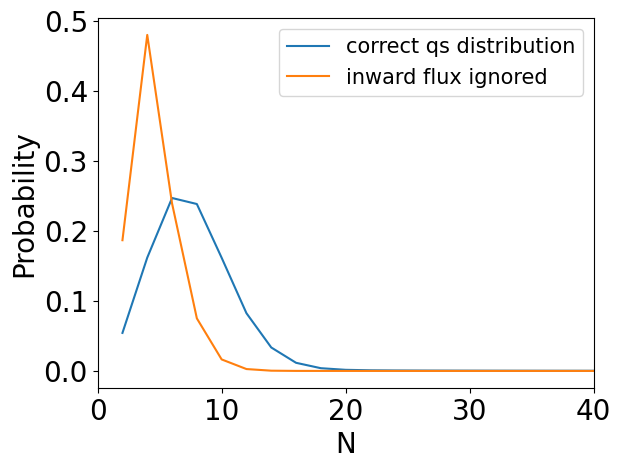

In [99]:
printing=True
#Warning: this recurrance relation appears to give the wrong qs distribution.
#DONE: dev function from powerlaw fits of birth-death rates to mean termination time
#inputs: nup,num,Mp,Mm
#output: MTThat
max_n_over_2 = int(num_iter)
#HINT: average tau conditioned on n by averaging over the quasistationary distribution
#DONE: estimate the quasistationary distribution
#HINT: test that quasistationary distribution ends up normalized
product_lst=[1]
n_lst = [2]
for n_over_2 in range(2,max_n_over_2+1):
    product = 1.
    for j in range(2,2*n_over_2+2,2):
        product *= comp_Wp(2*j-2)/comp_Wm(2*j)
    product_lst.append(product)
    n_lst.append(2*n_over_2)

n_values_qs = np.array(n_lst)
prob_values_qs = np.array(product_lst)
#normalize the quasistationary distribution
prob_values_qs /=np.sum(prob_values_qs)

#plot the wrong qs distribution (published) vs. the correct qs distribution
plt.plot(n_qs,prob_qs,label='correct qs distribution')
plt.plot(n_values_qs,prob_values_qs,label='inward flux ignored')
format_plot(xlabel='N',ylabel='Probability')
plt.legend(fontsize=fontsize)
plt.xlim([0,40])

#print summary
xv = np.arange(0.02, 1,0.001)
qstar,wstar = comp_powerlaw_intersection(Mp,nup,Mm,num,xv=xv)
if printing:
    print(f"{model_name} ({A=:.0f} cm^2):")
    print(f"- mean num particles (qstar*A): {qstar*A}") 
    print(f"- mean num particles (correct qs distr): {np.sum(prob_qs*n_qs)}")
    print(f"- mean num particles (incorrect qs distr): {np.sum(prob_values_qs*n_values_qs)}")
    n=2
    tau = 1/(comp_Wm(2)*prob_qs[n_qs==n])[0]
    print(f"- b.o.e. est. of mean termination time (correct qs distr): {tau:.4f} s")
    tau = 1/(comp_Wm(2)*prob_values_qs[n_values_qs==n])[0]
    print(f"- b.o.e. est. of mean termination time (incorrect qs distr): {tau:.4f} s")

plt.show()

In [100]:
#TODO: dev unit test on qs distribution generating function
comp_Wp = get_comp_W(A,nup,Mp)
comp_Wm = get_comp_W(A,num,Mm)
n_qs,prob_qs = comp_quasistatic_distrib_paired_bdrates(comp_Wm,comp_Wp,num_iter=num_iter)
np.sum(prob_qs*n_qs),np.sum(prob_qs),prob_qs.shape[0]

(7.624837359362673, 0.9999999999999999, 20)

In [101]:
n_qs

array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34,
       36, 38, 40])

In [102]:
# Fenton-Karma:
# Actual MTT: 27.7966 +/- 6.5012 s  
# correct qs avg: 21.9621 s
# incorrect qs avg: 4.4074 s
# 27.7966 - 6.5012
# ==> correct qs avg underestimates insignificantly

# Luo-Rudy:
# Actual MTT: 0.7422 +/- 0.0586 s
# correct qs avg: 5.2276 s
# incorrect qs avg: MTT= 0.2137 s
# ==> correct qs avg overestiamtesstimates 

In [103]:
# print("Q: is it one?") 
# # print(prob_qs[n_qs==2]**-1*prob_qs[n_qs==4]*comp_Wm(4)/(comp_Wm(2)+comp_Wp(2)))
# # n=4
# # print(prob_qs[n_qs==n]**-1*(comp_Wp(n-2)*prob_qs[n_qs==n-2] + comp_Wp(n+2)*prob_qs[n_qs==n+2])/(comp_Wm(n)+comp_Wp(n)))
# freq_prev  = prob_qs[n_qs==n-2]#[0]
# freq_cur   = prob_qs[n_qs==n]#[0]
# # freq_next  = (comp_Wp(n) + comp_Wm(n))*freq_cur - comp_Wm(n-2)*freq_prev
# freq_next  = (comp_Wp(n) + comp_Wm(n))*freq_cur - comp_Wp(n-2)*freq_prev
# freq_next /= comp_Wm(n+2) 
# print(f"{prob_qs[n_qs==n+2][0]/freq_next=}")

# # #test for base case of recurance relation
# # prob_values_qs[n_values_qs==2], comp_Wm(4)*prob_values_qs[n_values_qs==4]/(comp_Wm(2)+comp_Wp(2))
# # print(prob_qs[n_qs==2], prob_qs[n_qs==4]*comp_Wm(4)/(comp_Wm(2)+comp_Wp(2)))

# # #test for next case of recurance relation
# # n=4
# # prob_values_qs[n_values_qs==n], (comp_Wp(n-2)*prob_values_qs[n_values_qs==n-2] + comp_Wp(n+2)*prob_values_qs[n_values_qs==n+2])/(comp_Wm(n)+comp_Wp(n))
# # print(prob_qs[n_qs==n], (comp_Wp(n-2)*prob_qs[n_qs==n-2] + comp_Wp(n+2)*prob_qs[n_qs==n+2])/(comp_Wm(n)+comp_Wp(n)))

# #TODO: test recurrance relation is satisfied for all terms 
# for n in n_qs:
#     pass

Fenton-Karma:
- mean number of particles (direct): 10.5836 +/- 0.0312 (num_obs: 36179, p_normal: 0.5298)
- mean num particles (qstar*A): 7.999999999999999
- mean num particles (correct qs distr): 7.8934895769909845
- mean num particles (incorrect qs distr): 4.5287077772353275
- predicted mean termination time: 33.6558 s

Luo-Rudy:
- mean number of particles (direct): 10.5836 +/- 0.0305 (num_obs: 36179, p_normal: 0.0240)
- mean num particles (qstar*A): 4.249999999999999
- mean num particles (correct qs distr): 4.853111490143855
- mean num particles (incorrect qs distr): 2.84902260365808
- predicted mean termination time: 3.3068 s

## find a formula for a consistent mean value of termination time
#DONE: try out each of the 6 hypotheses I guessed to avoid reading the 400 page handbook WJ used to cite his "analytic solution"

We have an expressions for $\tau(n)$ in terms of the action variable, $\phi$:
 
$$
\tau(n) = \sum_{k=1}^{n/2} \phi(2(k-1)) \sum_{j=k}^\infty \frac{1}{\phi(2j)W_{+2}(2j)},
$$
and 
$$
\phi(k) = \Pi_{i=1}^{k/2} \frac{W_{-2}(2i)}{W_{+2}(2i)}.
$$

Given the mean termination time conditioned on n particles existing, we estimate the mean termination time according to:
$$
\mathbb{E}[\tau] = \sum_{n=0}^\infty \tau(n) P(n)
$$



Given the mean termination time conditioned on n particles existing, we estimate the mean termination time according to:
$$
\mathbb{E}[\tau] = \sum_{n=0}^\infty \tau(n) P(n)
$$



we have 6 hypotheses composed of two expressions for $\tau(n)$ and three expressions for the action variable, $\phi$.
 
Expression A for $\tau(n)$:
$$
\tau(n) = \sum_{k=1}^{n/2} \phi(2(k-1)) \sum_{j=k}^\infty \frac{1}{\phi(2j)W_{+2}(2j)}
$$

Expression B for $\tau(n)$:
$$
\tau(n) = \sum_{k=1}^{n/2} \phi(2(k-1)) \sum_{j=k}^\infty \frac{1}{\phi(2j)W_{+2}(2j)}
$$

In any case $\phi(0)\equiv 1$.  The 3 hypothetical forms of $\phi$ are the following:

Guess A:

$$
\phi(k) = \Pi_{i=1}^{k/2} \frac{W_{-2}(2i) + W_{+2}(2i)}{W_{-2}(2i)}
$$

Guess B:

$$
\phi(k) = \Pi_{i=1}^{k/2} \frac{W_{-2}(2i)}{W_{-2}(2i) + W_{+2}(2i)} 
$$

Guess C:

$$
\phi(k) = \Pi_{i=1}^{k/2} \frac{W_{-2}(2i)}{W_{+2}(2i)} 
$$

Guess D:

$$
\phi(k) = \Pi_{i=1}^{k/2} \frac{W_{+2}(2i)}{W_{-2}(2i) + W_{+2}(2i)} 
$$



### define hypothesis module

In [64]:
int(1/2),int(2/2),int(3/2),int(4/2)

(0, 1, 1, 2)

In [43]:
#DONE: implement each action variables
def get_phi_A(comp_Wm,comp_Wp):
    """
    
    Example Usage:
phi_A = get_phi_A(comp_Wm,comp_Wp)
    """
    def phi(k):
        product=1.
        for i in range(int(k/2)):
            #print(f"{k=}: {i=}  <-- does that look reasonable?")
            ii=i+1 #correct for 0 indexing
            product *= comp_Wm(2*ii) + comp_Wp(2*ii) #A
#             product *= comp_Wm(2*ii)                 #B
#             product *= comp_Wm(2*ii)                 #C
#             product *= comp_Wp(2*ii)                 #D
            product /= comp_Wp(2*ii)                 #A
#             product /= comp_Wm(2*ii) + comp_Wp(2*ii) #B
#             product /= comp_Wp(2*ii)                 #C
#             product /= comp_Wm(2*ii) + comp_Wp(2*ii) #D
        return product
    return phi

In [44]:
#DONE: implement each action variables
def get_phi_B(comp_Wm,comp_Wp):
    """
    
    Example Usage:
phi_B = get_phi_B(comp_Wm,comp_Wp)
    """
    def phi(k):
        product=1.
        for i in range(int(k/2)):
            #print(f"{k=}: {i=}  <-- does that look reasonable?")
            ii=i+1 #correct for 0 indexing
#             product *= comp_Wm(2*ii) + comp_Wp(2*ii) #A
            product *= comp_Wm(2*ii)                 #B
#             product *= comp_Wm(2*ii)                 #C
#             product *= comp_Wp(2*ii)                 #D
#             product /= comp_Wp(2*ii)                 #A
            product /= comp_Wm(2*ii) + comp_Wp(2*ii) #B
#             product /= comp_Wp(2*ii)                 #C
#             product /= comp_Wm(2*ii) + comp_Wp(2*ii) #D
        return product
    return phi

In [45]:
#DONE: implement each action variables
def get_phi_C(comp_Wm,comp_Wp):
    """
    
    Example Usage:
phi_C = get_phi_C(comp_Wm,comp_Wp)
    """
    def phi(k):
        product=1.
        for i in range(int(k/2)):
            #print(f"{k=}: {i=}  <-- does that look reasonable?")
            ii=i+1 #correct for 0 indexing
#             product *= comp_Wm(2*ii) + comp_Wp(2*ii) #A
#             product *= comp_Wm(2*ii)                 #B
            product *= comp_Wm(2*ii)                 #C
#             product *= comp_Wp(2*ii)                 #D
#             product /= comp_Wp(2*ii)                 #A
#             product /= comp_Wm(2*ii) + comp_Wp(2*ii) #B
            product /= comp_Wp(2*ii)                 #C
#             product /= comp_Wm(2*ii) + comp_Wp(2*ii) #D
        return product
    return phi

In [46]:
#DONE: implement each action variables
def get_phi_D(comp_Wm,comp_Wp):
    """
    
    Example Usage:
phi_D = get_phi_D(comp_Wm,comp_Wp)
    """
    def phi(k):
        product=1.
        for i in range(int(k/2)):
            #print(f"{k=}: {i=}  <-- does that look reasonable?")
            ii=i+1 #correct for 0 indexing
#             product *= comp_Wm(2*ii) + comp_Wp(2*ii) #A
#             product *= comp_Wm(2*ii)                 #B
#             product *= comp_Wm(2*ii)                 #C
            product *= comp_Wp(2*ii)                 #D
#             product /= comp_Wp(2*ii)                 #A
#             product /= comp_Wm(2*ii) + comp_Wp(2*ii) #B
#             product /= comp_Wp(2*ii)                 #C
            product /= comp_Wm(2*ii) + comp_Wp(2*ii) #D
        return product
    return phi

In [47]:
#DONE: implement the hypotheses
def eval_tau_expression_a(n_over_2, phi, comp_Wm, comp_Wp, maxinf_num_inner_sum=20,printing=True, **kwargs):
    """compute mean first passage time conditioned on initial number of particles.
    phi, comp_Wm, comp_Wp evaluate to the action variable, death rate, and birth rate, respectively. 
    
    Example Usage:
n_over_2 = int(np.floor(n/2)
tau = eval_tau_expression_a(n_over_2,phi, comp_Wm, comp_Wp, maxinf_num_inner_sum=20)
    """
    assert n_over_2<=maxinf_num_inner_sum#
    outer_sum=0.
    for k in range(n_over_2):
        inner_sum=0.
        for j in range(k,maxinf_num_inner_sum):
            jj = j+1 #correct for 1 indexing
            summand = 1. 
            summand/= phi(2*jj)*comp_Wp(2*jj)  #1
            #summand/= phi(2*jj)*comp_Wm(2*(jj-1))  #2
            #print(f"{k=}: {j=}: {summand=}\r")
            inner_sum += summand
        inner_sum *= phi(2*(k-1)) 
        outer_sum += inner_sum
        if printing:
            print(f"{k=}: {j=}: {outer_sum=:.4f} from {inner_sum=:.4f}")
            #print(f"{k=}: {j=}: {outer_sum=:.4f} from {inner_sum=:.4f}\r")
    return outer_sum

#DONE: implement the hypotheses
def eval_tau_expression_b(n_over_2, phi, comp_Wm, comp_Wp, maxinf_num_inner_sum=20,printing=True, **kwargs):
    """compute mean first passage time conditioned on initial number of particles.
    phi, comp_Wm, comp_Wp evaluate to the action variable, death rate, and birth rate, respectively. 
    
    Example Usage:
n_over_2 = int(np.floor(n/2))
tau = eval_tau_expression_b(n_over_2,phi, comp_Wm, comp_Wp, maxinf_num_inner_sum=20)
    """
    assert n_over_2<=maxinf_num_inner_sum#
    outer_sum=0.
    for k in range(n_over_2):
        k+=1
        inner_sum=0.
        for j in range(k,maxinf_num_inner_sum):
            jj = j+1 #correct for 1 indexing
            summand = 1. 
            #summand/= phi(2*jj)*comp_Wp(2*jj)  #1
            summand/= phi(2*jj)*comp_Wm(2*(jj-1))  #2
            #print(f"{k=}: {j=}: {summand=}\r")
            inner_sum += summand
        inner_sum *= phi(2*(k-1)) 
        outer_sum += inner_sum
        if printing:
            print(f"{k=}: {j=}: {outer_sum=:.4f} from {inner_sum=:.4f}")
            #print(f"{k=}: {j=}: {outer_sum=:.4f} from {inner_sum=:.4f}\r")
    return outer_sum

### test module

In [122]:
#DONE: implement each of the hypothetical action variables
phi_A = get_phi_A(comp_Wm,comp_Wp)
phi_B = get_phi_B(comp_Wm,comp_Wp)
phi_C = get_phi_C(comp_Wm,comp_Wp)
phi_D = get_phi_D(comp_Wm,comp_Wp)


In [123]:
#DONE: implement each of the hypotheses
#DONE: compute tau conditioned on n as a test case
k=5
maxinf_num_inner_sum=20
n_over_2 = int(np.floor(n/2))
tau = eval_tau_expression_a(n_over_2 ,phi_A, comp_Wm, comp_Wp, maxinf_num_inner_sum=20,printing=True)
tau

k=0: j=19: outer_sum=0.1716 from inner_sum=0.1716


0.1716335120897946

In [124]:

eval_tau_a=get_eval_tau(eval_tau_expression_a)
eval_tau_b=get_eval_tau(eval_tau_expression_b)

tau = eval_tau_a(n_qs, prob_qs, phi_A, comp_Wm, comp_Wp, maxinf_num_inner_sum=20, printing=False,**kwargs)
# tau = eval_tau_a(n_qs=n_qs, prob_qs=prob_qs, phi=phi_A, comp_Wm=comp_Wm, comp_Wp=comp_Wp, maxinf_num_inner_sum=max_num_inner_sum, printing=
# eval_tau(phi_A, comp_Wm, comp_Wp, maxinf_num_inner_sum=maxinf_num_inner_sum, printing=printing))
tau

0.32702595552375807

In [125]:
tau_gt_fk =  27.7966 #+/- 6.5012 s 
tau_gt_lr =  0.7422 # +/- 0.0586 s
tau_gt = tau_gt_fk
# tau_gt = tau_gt_lr

In [126]:
maxinf_num_inner_sum=20
printing=True
#TODO: compute tau conditioned on n for each of the hypotheses
n_over_2 = int(np.floor(n/2))
#exppression a
tau_aA = eval_tau_a(n_qs, prob_qs, phi_A, comp_Wm, comp_Wp, printing=False)#, **kwargs)
tau_aB = eval_tau_a(n_qs, prob_qs, phi_B, comp_Wm, comp_Wp, printing=False)#, **kwargs)
tau_aC = eval_tau_a(n_qs, prob_qs, phi_C, comp_Wm, comp_Wp, printing=False)#, **kwargs)
tau_aD = eval_tau_a(n_qs, prob_qs, phi_D, comp_Wm, comp_Wp, printing=False)#, **kwargs)
#exppression b
tau_bA = eval_tau_b(n_qs, prob_qs, phi_A, comp_Wm, comp_Wp, printing=False)#, **kwargs)
tau_bB = eval_tau_b(n_qs, prob_qs, phi_B, comp_Wm, comp_Wp, printing=False)#, **kwargs)
tau_bC = eval_tau_b(n_qs, prob_qs, phi_C, comp_Wm, comp_Wp, printing=False)#, **kwargs)
tau_bD = eval_tau_b(n_qs, prob_qs, phi_D, comp_Wm, comp_Wp, printing=False)#, **kwargs)


# #exppression a (tau2 only)
# tau_aA = eval_tau_expression_a(n_over_2 ,phi_A, comp_Wm, comp_Wp, maxinf_num_inner_sum=maxinf_num_inner_sum, printing=printing)
# tau_aB = eval_tau_expression_a(n_over_2 ,phi_B, comp_Wm, comp_Wp, maxinf_num_inner_sum=maxinf_num_inner_sum, printing=printing)
# tau_aC = eval_tau_expression_a(n_over_2 ,phi_C, comp_Wm, comp_Wp, maxinf_num_inner_sum=maxinf_num_inner_sum, printing=printing)
# tau_aD = eval_tau_expression_a(n_over_2 ,phi_D, comp_Wm, comp_Wp, maxinf_num_inner_sum=maxinf_num_inner_sum, printing=printing)
# #exppression b (tau2 only)
# tau_bA = eval_tau_expression_b(n_over_2 ,phi_A, comp_Wm, comp_Wp, maxinf_num_inner_sum=maxinf_num_inner_sum, printing=printing)
# tau_bB = eval_tau_expression_b(n_over_2 ,phi_B, comp_Wm, comp_Wp, maxinf_num_inner_sum=maxinf_num_inner_sum, printing=printing)
# tau_bC = eval_tau_expression_b(n_over_2 ,phi_C, comp_Wm, comp_Wp, maxinf_num_inner_sum=maxinf_num_inner_sum, printing=printing)
# tau_bD = eval_tau_expression_b(n_over_2 ,phi_D, comp_Wm, comp_Wp, maxinf_num_inner_sum=maxinf_num_inner_sum, printing=printing)


print(f"""
Ground Truth:
{tau_gt=:.4f} s

Predictions:
{tau_aA=:.4f} s
{tau_aB=:.4f} s
{tau_aC=:.4f} s
{tau_aD=:.4f} s

{tau_bA=:.4f} s
{tau_bB=:.4f} s
{tau_bC=:.4f} s
{tau_bD=:.4f} s
""")


Ground Truth:
tau_gt=27.7966 s

Predictions:
tau_aA=0.3270 s
tau_aB=4088.2137 s
tau_aC=25.8562 s
tau_aD=16819615567759.2676 s

tau_bA=0.8692 s
tau_bB=488.3640 s
tau_bC=48.4476 s
tau_bD=1131645679785.8123 s



In [75]:
model_name

'Fenton-Karma'

In [76]:
#TODO: sum their product over n_qs


In [77]:
#TODO: wrap ^this to function
#TODO: estimate MTT from the power law fits to the full model's birth/death rates

In [78]:
#TODO(bonus): estimate 95% CI using max abs diff of arguments +/- their uncertainty
#TODO(bonus): wrap ^this as foo. 
# HINT:
# dict_fit_birth = dict(nu_plus = nup_fk, 
#                       Delta_nu_plus = Delta_nup_fk, 
#                       M_plus = Mp_fk, 
#                       Delta_M_plus = Delta_Mp_fk, 
#                      )
#Q: is my MTT significantly different from the values observed from the full models?

# plot the mean termination times predicted by the paired birth death model

In [104]:
#DONE: get token inputs prepared
dict_fit_death_lr = dict(wjr['lr_pbc'])
dict_fit_death_fk = dict(wjr['fk_pbc'])

In [105]:
# input size of computational domain with pbc
L=5 #cm
# L=10 #cm
A=L**2 #cm^2
num_iter=20 # max num particles to consider divided by two.

In [106]:
printing=True
################################
# estimate mtt for Fenton-Karma
################################
Mp = dict_fit_birth_fk['M']
nup = dict_fit_birth_fk['m']
Mm = dict_fit_death_fk['M']
num = dict_fit_death_fk['m']
model_name='Fenton-Karma'

# Mp = dict_fit_birth_lr['M']
# nup = dict_fit_birth_lr['m']
# Mm = dict_fit_death_lr['M']
# num = dict_fit_death_lr['m']
# model_name='Luo-Rudy'

#implement model
comp_Wp = get_comp_W(A,nup,Mp)
comp_Wm = get_comp_W(A,num,Mm)
phi = get_phi(comp_Wm,comp_Wp)
eval_tau= get_eval_tau(eval_tau_expression)
#estimate the quasistatic distribution
n_qs,prob_qs = comp_quasistatic_distrib_paired_bdrates(comp_Wm,comp_Wp,num_iter=num_iter)
#estimate the mean termination time
tau = eval_tau(n_qs, prob_qs, phi, comp_Wm, comp_Wp, maxinf_num_inner_sum=num_iter, printing=False)#,**kwargs)
#estimate the mean number of particles
nbar = np.sum(prob_qs*n_qs)
nsqbar = np.sum(prob_qs*(n_qs**2))

# print_dict(dict_results_master_fk)
#print summary
xv = np.arange(0.02, 1,0.001)
qstar,wstar = comp_powerlaw_intersection(Mp,nup,Mm,num,xv=xv)

#record
dict_results_master_fk = dict(
    model=model_name,
    tau=tau,
    nbar=nbar,
    qstarA=qstar*A,
    A=A,
    Mp=Mp,nup=nup,
    Mm=Mm,num=num,
    qstar=qstar,wstar=wstar,
    num_iter=num_iter,
    nsqbar=nsqbar)
if printing:
    print(f"{model_name} ({A=:.0f} cm^2):")
    print(f"- mean termination time (correct qs distr): {tau:.4f} s")    
    print(f"- mean num particles (correct qs distr): {nbar:.4f}")
    print(f"- mean num particles (qstar*A): {qstar*A:.4f}") 

################################
# estimate mtt for Luo-Rudy
################################
Mp = dict_fit_birth_lr['M']
nup = dict_fit_birth_lr['m']
Mm = dict_fit_death_lr['M']
num = dict_fit_death_lr['m']
model_name='Luo-Rudy'

#implement model
comp_Wp = get_comp_W(A,nup,Mp)
comp_Wm = get_comp_W(A,num,Mm)
phi = get_phi(comp_Wm,comp_Wp)
eval_tau= get_eval_tau(eval_tau_expression)
#estimate the quasistatic distribution
n_qs,prob_qs = comp_quasistatic_distrib_paired_bdrates(comp_Wm,comp_Wp,num_iter=num_iter)
#estimate the mean termination time
tau = eval_tau(n_qs, prob_qs, phi, comp_Wm, comp_Wp, maxinf_num_inner_sum=num_iter, printing=False)#,**kwargs)
#estimate the mean number of particles
nbar = np.sum(prob_qs*n_qs)
nsqbar = np.sum(prob_qs*(n_qs**2))

#print summary
xv = np.arange(0.02, 1,0.001)
qstar,wstar = comp_powerlaw_intersection(Mp,nup,Mm,num,xv=xv)

#record
dict_results_master_lr = dict(
    model=model_name,
    tau=tau,
    nbar=nbar,
    qstarA=qstar*A,
    A=A,
    Mp=Mp,nup=nup,
    Mm=Mm,num=num,
    qstar=qstar,wstar=wstar,
    num_iter=num_iter,
    nsqbar=nsqbar)
if printing:
    print(f"\n{model_name} ({A=:.0f} cm^2):")
    print(f"- mean termination time (correct qs distr): {tau:.4f} s")    
    print(f"- mean num particles (correct qs distr): {nbar:.4f}")
    print(f"- mean num particles (qstar*A): {qstar*A:.4f}") 


Fenton-Karma (A=25 cm^2):
- mean termination time (correct qs distr): 14.7335 s
- mean num particles (correct qs distr): 7.6248
- mean num particles (qstar*A): 8.0750

Luo-Rudy (A=25 cm^2):
- mean termination time (correct qs distr): 0.4406 s
- mean num particles (correct qs distr): 6.5878
- mean num particles (qstar*A): 4.2750


In [107]:

#heretim
1733123724.9095/1e9

1.7331237249095

In [109]:
#recall termination times observed from full
# term_dir_fk='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_termination_times.csv'
# term_dir_lr='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr/200x200/tippos_per_001_termination_times.csv'
# term_dir_fk='/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_termination_times.csv'
# term_dir_lr='/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr/200x200/tippos_per_001_termination_times.csv'
term_dir_fk=f'{nb_dir}/../../care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_termination_times.csv'
term_dir_lr=f'{nb_dir}/../..//care/notebooks/Data/from_wjr/positions_lr/200x200/tippos_per_001_termination_times.csv'
df_term_fk = pd.read_csv(term_dir_fk)
df_term_lr = pd.read_csv(term_dir_lr)


#estimate mean termination time directly
#bootstrap mean +/- 95% CI
t_term_values_fk = df_term_fk['t_term'].values
meanx,Delta_meanx,num_obsx,p_normalx=comp_mean_bootstrap_uncertainty(t_term_values_fk,num_samples=100)
printing=True
if printing:
    print(f"Fenton-Karma:")
    print(f" - mean termination time: {meanx:.4f} +/- {Delta_meanx:.4f} s (N_term_events={num_obsx}, p_normal: {p_normalx:.4f})")

dict_mtt_fk = dict(model='Fenton-Karma',
                mtt=meanx,
                Delta_mtt=Delta_meanx,
                num_term_events=num_obsx,
                p_normal_mtt=p_normalx)

#bootstrap mean +/- 95% CI
t_term_values_lr = df_term_lr['t_term'].values
meanx,Delta_meanx,num_obsx,p_normalx=comp_mean_bootstrap_uncertainty(t_term_values_lr,num_samples=100)
printing=True
if printing:
    print(f"Luo-Rudy:")
    print(f" - mean termination time: {meanx:.4f} +/- {Delta_meanx:.4f} s (N_term_events={num_obsx}, p_normal: {p_normalx:.4f})")

dict_mtt_lr = dict(model='Luo-Rudy',
                mtt=meanx,
                Delta_mtt=Delta_meanx,
                num_term_events=num_obsx,
                p_normal_mtt=p_normalx)

print(f"termination times from:")
print(f"{term_dir_fk=}")
print(f"{term_dir_lr=}")
# print(df_mtt)

#statistical test comparing values to full
err_mtt_values_fk = t_term_values_fk - dict_results_master_fk['tau']
err_mtt_values_lr = t_term_values_lr - dict_results_master_lr['tau']

print(f"comparing error from apparent mean termination times.")
print(f"\nFenton-Karma:")
dict_ptests_fk = print_statistical_tests(err_mtt_values_fk,printing=True)
print(f"\nLuo-Rudy:")
dict_ptests_lr = print_statistical_tests(err_mtt_values_lr,printing=True)
#update dicts
dict_mtt_fk.update(**dict_ptests_fk)
dict_mtt_lr.update(**dict_ptests_lr)
#format results
df_mtt = pd.DataFrame([dict_mtt_fk,dict_mtt_lr])

Fenton-Karma:
 - mean termination time: 27.7966 +/- 5.6304 s (N_term_events=81, p_normal: 0.1277)
Luo-Rudy:
 - mean termination time: 0.7422 +/- 0.0553 s (N_term_events=641, p_normal: 0.6540)
termination times from:
term_dir_fk='/Users/timothytyree/Documents/GitHub/bgmc/python/../../care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_termination_times.csv'
term_dir_lr='/Users/timothytyree/Documents/GitHub/bgmc/python/../..//care/notebooks/Data/from_wjr/positions_lr/200x200/tippos_per_001_termination_times.csv'
comparing error from apparent mean termination times.

Fenton-Karma:
statistical tests:
        num_obs=81
        p_wilcoxon=0.00029653
        p_ttest=0.00006763
        p_normal=0.00000000
        

Luo-Rudy:
statistical tests:
        num_obs=641
        p_wilcoxon=0.00000000
        p_ttest=0.00000000
        p_normal=0.00000000
        


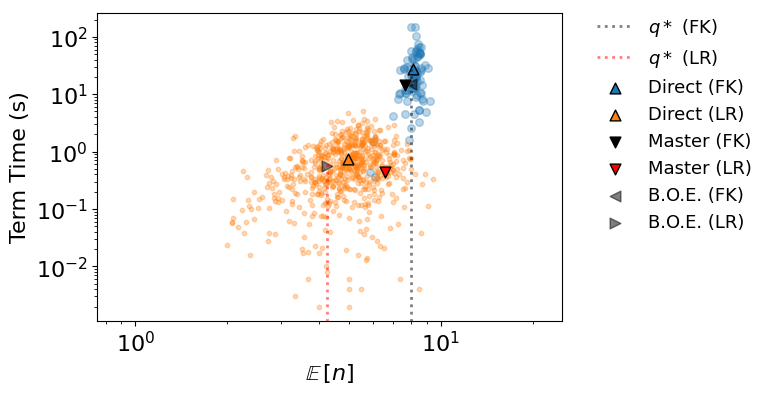

In [110]:
#scatter plot max num particles versus termination time
fig,ax=plt.subplots(figsize=(6,4))
# fontsize=18
fontsize=16
xcol='n_mean'
# xlim=[1,100]
xlim=[0.75,25]

#plot the trials
df_term_fk.plot.scatter(x=xcol,y='t_term',color='C0',alpha=0.3,s=30,ax=ax)
df_term_lr.plot.scatter(x=xcol,y='t_term',color='C1',alpha=0.3,s=10,ax=ax)
#plot true mean values
tau_fk = df_term_fk['t_term'].mean()
tau_lr = df_term_lr['t_term'].mean()
nbar_fk =df_term_fk[xcol].mean()
nbar_lr =df_term_lr[xcol].mean()
#plot the confusing back of envelope estimate that WJ put at the start of his paper in huge font.
ax.scatter([nbar_fk],[tau_fk],c='C0',marker='^',s=60,alpha=1,label='Direct (FK)',edgecolor='k')
ax.scatter([nbar_lr],[tau_lr],c='C1',marker='^',s=60,alpha=1,label='Direct (LR)',edgecolor='k')




#plot hypotheses
tau_fk_hat = dict_results_master_fk['tau']
tau_lr_hat = dict_results_master_lr['tau']
nbar_fk_hat = dict_results_master_fk['nbar']
nbar_lr_hat = dict_results_master_lr['nbar']
ax.scatter([nbar_fk_hat],[tau_fk_hat],c='k',marker='v',s=60,alpha=1.,label='Master (FK)',edgecolor='k')
ax.scatter([nbar_lr_hat],[tau_lr_hat],c='r',marker='v',s=60,alpha=1.,label='Master (LR)',edgecolor='k')

#plot qstar as vertical dotted line
ax.plot([qstar_fk*A,qstar_fk*A
        ],[0, 27.7966 #+/- 6.5012 s 
                                 ],'k:',lw=2,alpha=0.5,label=r'$q*$ (FK)')
ax.plot([qstar_lr*A,qstar_lr*A],[0, 0.7422 #+/- 0.0586 s
                                 ],'r:',lw=2,alpha=0.5,label=r'$q*$ (LR)')

#plot the confusing back of envelope estimate that WJ put at the start of his paper in huge font.
tau_boe_fk = 15.1622 #s
tau_boe_lr = 0.5711 #s
ax.scatter([qstar_fk*A],[tau_boe_fk],c='k',s=60,alpha=0.5,label='B.O.E. (FK)',marker='<',edgecolor='k')
ax.scatter([qstar_lr*A],[tau_boe_lr],c='k',s=60,alpha=0.5,label='B.O.E. (LR)',marker='>',edgecolor='k')


# format_plot
# format_plot(ax=ax,xlabel=xcol,ylabel='Term Time (s)',fontsize=fontsize,use_loglog=True)
format_plot(ax=ax,xlabel=r'$\mathbb{E}\,[n]$',ylabel='Term Time (s)',fontsize=fontsize,use_loglog=True)
ax.set_xlim(xlim)
ax.legend(fontsize=fontsize-3,loc='upper left', bbox_to_anchor = (1.04,1.04), frameon=False)
# with bbox_to_anchor as 
plt.show()

#DONE: root cause analysis removed half of the error, soothing the viewer.
#Q: why is red triangle not on the orange line?
#A: because the qs distribution is not a true steady state

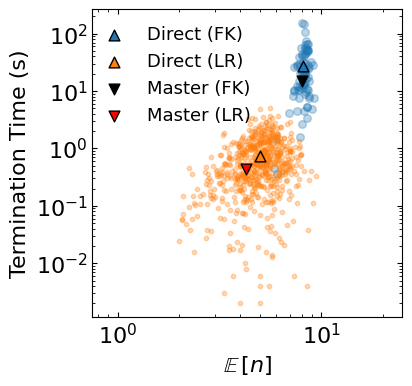

In [111]:
#scatter plot max num particles versus termination time
# fig,ax=plt.subplots(figsize=(6,4))
fig,ax=plt.subplots(figsize=(4,4))
# fontsize=18
fontsize=16
xcol='n_mean'
# xlim=[1,100]
xlim=[0.75,25]

#plot the trials
df_term_fk.plot.scatter(x=xcol,y='t_term',color='C0',alpha=0.3,s=30,ax=ax)
df_term_lr.plot.scatter(x=xcol,y='t_term',color='C1',alpha=0.3,s=10,ax=ax)
#plot true mean values
tau_fk = df_term_fk['t_term'].mean()
tau_lr = df_term_lr['t_term'].mean()
nbar_fk =df_term_fk[xcol].mean()
nbar_lr =df_term_lr[xcol].mean()
#plot the confusing back of envelope estimate that WJ put at the start of his paper in huge font.
ax.scatter([nbar_fk],[tau_fk],c='C0',marker='^',s=60,alpha=1,label='Direct (FK)',edgecolor='k')
ax.scatter([nbar_lr],[tau_lr],c='C1',marker='^',s=60,alpha=1,label='Direct (LR)',edgecolor='k')




#plot hypotheses
tau_fk_hat = dict_results_master_fk['tau']
tau_lr_hat = dict_results_master_lr['tau']
nbar_fk_hat = dict_results_master_fk['nbar']
nbar_lr_hat = dict_results_master_lr['nbar']
ax.scatter([qstar_fk*A,#nbar_fk_hat
           ],[tau_fk_hat],c='k',marker='v',s=60,alpha=1.,label='Master (FK)',edgecolor='k')
ax.scatter([qstar_lr*A,#nbar_lr_hat
           ],[tau_lr_hat],c='r',marker='v',s=60,alpha=1.,label='Master (LR)',edgecolor='k')

# #plot qstar as vertical dotted line
# ax.plot([qstar_fk*A,qstar_fk*A
#         ],[0, 27.7966 #+/- 6.5012 s 
#                                  ],'k:',lw=2,alpha=0.5,label=r'$q*$ (FK)')
# ax.plot([qstar_lr*A,qstar_lr*A],[0, 0.7422 #+/- 0.0586 s
#                                  ],'r:',lw=2,alpha=0.5,label=r'$q*$ (LR)')

# #plot the confusing back of envelope estimate that WJ put at the start of his paper in huge font.
# tau_boe_fk = 15.1622 #s
# tau_boe_lr = 0.5711 #s
# ax.scatter([qstar_fk*A],[tau_boe_fk],c='k',s=60,alpha=0.5,label='B.O.E. (FK)',marker='<',edgecolor='k')
# ax.scatter([qstar_lr*A],[tau_boe_lr],c='k',s=60,alpha=0.5,label='B.O.E. (LR)',marker='>',edgecolor='k')


# format_plot
# format_plot(ax=ax,xlabel=xcol,ylabel='Term Time (s)',fontsize=fontsize,use_loglog=True)
format_plot(ax=ax,xlabel=r'$\mathbb{E}\,[n]$',ylabel='Termination Time (s)',fontsize=fontsize,use_loglog=True)
ax.set_xlim(xlim)
# ax.legend(fontsize=fontsize-3,loc='upper left', bbox_to_anchor = (1.04,1.04), frameon=False)
ax.legend(fontsize=fontsize-3,loc='upper left', bbox_to_anchor = (-0.04,1.0), 
          frameon=False)
ax.tick_params(top=True, right=True,direction='in',which='both')
# with bbox_to_anchor as 
plt.show()

#DONE: root cause analysis removed half of the error, soothing the viewer.
#Q: why is red triangle not on the orange line?
#A: because the qs distribution is not a true steady state

traces of quasistatic distributions:

Fenton-Karma (A=25 cm^2):
- mean num particles (qstar*A): 8.075000000000006
- mean num particles (correct qs distr): 7.624837359362673
- mean num particles (incorrect qs distr): 4.5287077772353275
- b.o.e. est. of mean termination time (correct qs distr): 15.1593 s
- b.o.e. est. of mean termination time (incorrect qs distr): 4.4074 s

Luo-Rudy (A=25 cm^2):
- mean num particles (qstar*A): 4.275000000000003
- mean num particles (correct qs distr): 6.587830396477089
- mean num particles (incorrect qs distr): 4.5287077772353275
- b.o.e. est. of mean termination time (correct qs distr): 0.5700 s
- b.o.e. est. of mean termination time (incorrect qs distr): 0.8011 s


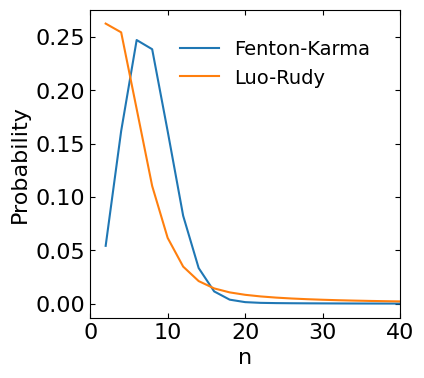

In [114]:
#plot the quasistatic distributions
L=5 #cm
A=L**2
num_iter=20
#set argument values
dict_fit_birth_lst = [dict_fit_birth_fk,dict_fit_birth_lr]
dict_fit_death_lst = [dict_fit_death_fk,dict_fit_death_lr]
model_name_lst     = ['Fenton-Karma', 'Luo-Rudy']
color_lst          = ['C0','C1']

print(f"traces of quasistatic distributions:")
# fig,ax=plt.subplots(figsize=(6,4))
fig,ax=plt.subplots(figsize=(4,4))
# fontsize=18
fontsize=16
for dict_fit_birth,dict_fit_death,model_name,color in zip(dict_fit_birth_lst,dict_fit_death_lst,model_name_lst,color_lst):
    Mp = dict_fit_birth['M']
    nup = dict_fit_birth['m']
    Mm = dict_fit_death['M']
    num = dict_fit_death['m']

    #estimate the quasistatic distribution
    comp_Wp = get_comp_W(A,nup,Mp)
    comp_Wm = get_comp_W(A,num,Mm)
    n_qs,prob_qs = comp_quasistatic_distrib_paired_bdrates(comp_Wm,comp_Wp,num_iter=num_iter)
    
    ax.plot(n_qs,prob_qs,label=model_name)
    #print summary
    xv = np.arange(0.02, 1,0.001)
    qstar,wstar = comp_powerlaw_intersection(Mp,nup,Mm,num,xv=xv)
    if printing:
        print(f"\n{model_name} ({A=:.0f} cm^2):")
        print(f"- mean num particles (qstar*A): {qstar*A}") 
        print(f"- mean num particles (correct qs distr): {np.sum(prob_qs*n_qs)}")
        print(f"- mean num particles (incorrect qs distr): {np.sum(prob_values_qs*n_values_qs)}")
        n=2
        tau = 1/(comp_Wm(2)*prob_qs[n_qs==n])[0]
        print(f"- b.o.e. est. of mean termination time (correct qs distr): {tau:.4f} s")
        tau = 1/(comp_Wm(2)*prob_values_qs[n_values_qs==n])[0]
        print(f"- b.o.e. est. of mean termination time (incorrect qs distr): {tau:.4f} s")

#format_plot
format_plot(xlabel='n',ylabel='Probability',fontsize=fontsize)
leg = AddLegend(ax, fontsize=fontsize-2, xy = (0.96,0.96), loc='upper right', frameon=False)
ax.tick_params(top=True, right=True,direction='in',which='both')
plt.xlim([0,40])
plt.show()

In [115]:
#print latex tables for each set of values i'd like to make into latex tables
df_results_master = pd.DataFrame([dict_results_master_fk,dict_results_master_lr])
df_results_master['L'] = L
#format as pandas table
mindex_lst=['model', 'L']
df_table_master_complete=df_results_master.sort_values(by=mindex_lst,ascending=False)\
               .set_index(mindex_lst).T#[['m', 'Delta_m', 'M', 'Delta_M', 'r','kappa', 'delta', 'a', 'D']].T
print(df_table_master_complete)
#format as pandas table
df_mtt['L'] = L
df_table_mtt_complete=df_mtt.sort_values(by=mindex_lst,ascending=False)\
               .set_index(mindex_lst).T#[['m', 'Delta_m', 'M', 'Delta_M', 'r','kappa', 'delta', 'a', 'D']].T

model      Luo-Rudy Fenton-Karma
L                 5            5
tau        0.440566    14.733454
nbar       6.587830     7.624837
qstarA     4.275000     8.075000
A         25.000000    25.000000
Mp         3.277073     0.864210
nup        0.714755     0.229594
Mm        16.735599     5.572316
num        1.637556     1.877234
qstar      0.171000     0.323000
wstar      0.927398     0.666707
num_iter  20.000000    20.000000
nsqbar    79.036845    69.969231


In [116]:
##############################
# LaTeX table generation
##############################
print("% *********************************")
print("% * Generated LaTeX tables re: MTT")
print("% *********************************")
kwargs_table_1_level=dict(float_format="{:0.4f}".format,
#                           multicolumn_format='c',
                           column_format='c',
#                            caption=('Table. ?? shows full\_caption', 'Table. ?? short\_caption.'),
#                            longtable=True #Requires adding a usepackage{longtable} to your LaTeX preamble.
                          )
kwargs_table_2_levels=dict(float_format="{:0.4f}".format,
                          multicolumn_format='c',
#                            column_format='c',
#                            caption=('Table. ?? shows full\_caption', 'Table. ?? short\_caption.'),
#                            longtable=True #Requires adding a usepackage{longtable} to your LaTeX preamble.
                          )
print("% df_table_mtt_complete")
print("% \begin{ruledtabular}")
print("% \begin{tabular}{cccccc}")
print(df_table_mtt_complete.reset_index().to_latex(index=False, 
                                               caption='shows mean termination times (MTT) estimated from direct simulations of the full models at the relatively small domain length scale ($L=5$ cm).\label{tab:df_table_mtt_complete})',
                                               **kwargs_table_2_levels))

print("% df_table_master_complete")
print("% \begin{ruledtabular}")
print("% \begin{tabular}{cccccc}")
print(df_table_master_complete.reset_index().to_latex(index=False, 
                                               caption='shows mean termination times (MTT) predicted by the paired birth-death model fit to the full models at the same relatively small domain length scale ($L=5$ cm).\label{tab:df_table_master_complete})',
                                               **kwargs_table_2_levels))




% *********************************
% * Generated LaTeX tables re: MTT
% *********************************
% df_table_mtt_complete
% egin{ruledtabular}
% egin{tabular}{cccccc}
\begin{table}
\centering
\caption{shows mean termination times (MTT) estimated from direct simulations of the full models at the relatively small domain length scale ($L=5$ cm).\label{tab:df_table_mtt_complete})}
\begin{tabular}{lrr}
\toprule
          index & Luo-Rudy & Fenton-Karma \\
                &        5 &            5 \\
\midrule
            mtt &   0.7422 &      27.7966 \\
      Delta\_mtt &   0.0553 &       5.6304 \\
num\_term\_events & 641.0000 &      81.0000 \\
   p\_normal\_mtt &   0.6540 &       0.1277 \\
        num\_obs & 641.0000 &      81.0000 \\
     p\_wilcoxon &   0.0000 &       0.0003 \\
        p\_ttest &   0.0000 &       0.0001 \\
       p\_normal &   0.0000 &       0.0000 \\
\bottomrule
\end{tabular}
\end{table}

% df_table_master_complete
% egin{ruledtabular}
% egin{tabular}{cccccc

# estimate probability of termination for a given consistent mean value of termination time

In [118]:
use_cache=True
if use_cache:
    #load from cache
    bootstrapped_termination_times_dir_fk=f'{nb_dir}/../../care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_bootstrapped_termination_times.csv'
    bootstrapped_termination_times_dir_lr=f'{nb_dir}/../../care/notebooks/Data/from_wjr/positions_lr/200x200/tippos_per_001_bootstrapped_termination_times.csv'
#     bootstrapped_termination_times_dir_fk='/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_bootstrapped_termination_times.csv'
#     bootstrapped_termination_times_dir_lr='/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr/200x200/tippos_per_001_bootstrapped_termination_times.csv'
    df_sampled_fk = pd.read_csv(bootstrapped_termination_times_dir_fk)
    df_sampled_lr = pd.read_csv(bootstrapped_termination_times_dir_lr)
else:
    #Warning: this takes a bit to plot
    log_dir_fk=f'{nb_dir}/../../care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_log.parquet'
    log_dir_lr=f'{nb_dir}/../../care/notebooks/Data/from_wjr/positions_lr/200x200/tippos_per_001_log.parquet'
    print(f"{log_dir_fk=}")
    print(f"{log_dir_lr=}")
    # term_dir_fk='/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_termination_times.csv'
    # term_dir_lr='/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr/200x200/tippos_per_001_termination_times.csv'
    # print(f"{term_dir_fk=}")
    # print(f"{term_dir_lr=}")

    # num_samples=1000 #40 ms
    num_samples=10000
    random_state = 42
    tscale=1e-3 #s per ms

    print(f"bootstrapping termination time distribution (estimated run time ~6.33 minutes for 10000 samples, iid)...")
    #FK
    df=pd.read_parquet(log_dir_fk)
    #bootstrap temrintion time distribution
    df_sampled = df.sample(num_samples,random_state=random_state,replace=True)
    df_sampled['tf']=np.nan
    for index,row in df_sampled.iterrows():
        tf = df.loc[row['trial_num']==df['trial_num']]['t'].max()
        df_sampled.loc[index,'tf']=tf
    df_sampled['t_term'] = tscale*(df_sampled['tf'] - df_sampled['t'])
    df_sampled_fk = df_sampled.copy()

    #LR
    df=pd.read_parquet(log_dir_lr)
    df_sampled = df.sample(num_samples,random_state=random_state,replace=True)
    df_sampled['tf']=np.nan
    for index,row in df_sampled.iterrows():
        tf = df.loc[row['trial_num']==df['trial_num']]['t'].max()
        df_sampled.loc[index,'tf']=tf
    df_sampled['t_term'] = tscale*(df_sampled['tf'] - df_sampled['t'])
    df_sampled_lr = df_sampled.copy()

    #save to cache
    bootstrapped_termination_times_dir_fk = log_dir_fk.replace('_log.parquet','_bootstrapped_termination_times.csv')
    bootstrapped_termination_times_dir_lr = log_dir_lr.replace('_log.parquet','_bootstrapped_termination_times.csv')
    df_sampled_fk.to_csv(bootstrapped_termination_times_dir_fk,index=False)
    df_sampled_lr.to_csv(bootstrapped_termination_times_dir_lr,index=False)
    print(f"{bootstrapped_termination_times_dir_fk=}")
    print(f"{bootstrapped_termination_times_dir_lr=}")

In [119]:
#bootstrap mean +/- 95% CI
t_term_values_fk = df_sampled_fk['t_term'].values
# t_term_values_fk = df_term_fk['t_term'].values
meanx,Delta_meanx,num_obsx,p_normalx=comp_mean_bootstrap_uncertainty(t_term_values_fk,num_samples=100)
printing=True
if printing:
    print(f"Fenton-Karma:")
    print(f" - mean termination time: {meanx:.4f} +/- {Delta_meanx:.4f} s (N_term_events={num_obsx}, p_normal: {p_normalx:.4f})")

dict_mtt_fk = dict(model='Fenton-Karma',
                mtt=meanx,
                Delta_mtt=Delta_meanx,
                num_term_events=num_obsx,
                p_normal=p_normalx)

#bootstrap mean +/- 95% CI
t_term_values_lr = df_sampled_lr['t_term'].values
# t_term_values_lr = df_term_lr['t_term'].values
meanx,Delta_meanx,num_obsx,p_normalx=comp_mean_bootstrap_uncertainty(t_term_values_lr,num_samples=100)
printing=True
if printing:
    print(f"Luo-Rudy:")
    print(f" - mean termination time: {meanx:.4f} +/- {Delta_meanx:.4f} s (N_term_events={num_obsx}, p_normal: {p_normalx:.4f})")

dict_mtt_lr = dict(model='Luo-Rudy',
                mtt=meanx,
                Delta_mtt=Delta_meanx,
                num_term_events=num_obsx,
                p_normal=p_normalx)


df_mtt = pd.DataFrame([dict_mtt_fk,dict_mtt_lr])
# print(f"termination times saved in:")
# print(f"{term_dir_fk=}")
# print(f"{term_dir_lr=}")
print(df_mtt)

Fenton-Karma:
 - mean termination time: 28.1166 +/- 0.6170 s (N_term_events=10000, p_normal: 0.1990)
Luo-Rudy:
 - mean termination time: 0.7456 +/- 0.0148 s (N_term_events=10000, p_normal: 0.4216)
          model        mtt  Delta_mtt  num_term_events  p_normal
0  Fenton-Karma  28.116557   0.616992            10000  0.199021
1      Luo-Rudy   0.745636   0.014831            10000  0.421572


In [120]:
from scipy.stats import gamma

#TODO: compute xy values of histogram
# bins_fk=np.arange(0,50,1.6)
# bins_fk=np.arange(0,20,0.4)
bins_fk=np.arange(0,40,0.4)
# bins_fk=np.arange(0,40,1)
#DONE: compute the histograms
barheights_fk,bins_fk = np.histogram(
    t_term_values_fk,
    bins=bins_fk,#10,
    range=None,
    normed=None,
    weights=None,
    density=False,
)
t_term_fk=0.5*(bins_fk[1:]+bins_fk[:-1])

# bins_lr=np.arange(0,16,0.4)
bins_lr=np.arange(0,40,0.4)
# bins_lr=np.arange(0,40,1)
barheights_lr,bins_lr = np.histogram(
    t_term_values_lr,
    bins=bins_lr,#bins[bins<0.45],#10,
    range=None,
    normed=None,
    weights=None,
    density=False,
)
t_term_lr=0.5*(bins_lr[1:]+bins_lr[:-1])
num_samples = t_term_values_lr.shape[0]
prob_fk = barheights_fk/(bins_fk[1:]-bins_fk[:-1])/num_samples
num_samples = t_term_values_fk.shape[0]
prob_lr = barheights_lr/(bins_lr[1:]-bins_lr[:-1])/num_samples
# prob_fk = barheights_fk/num_samples
# prob_lr = barheights_lr/num_samples

#fit analytic functions to these distributions
shpe_fk,loc_fk,scale_fk = gamma.fit(t_term_values_fk,method='MLE')
shpe_lr,loc_lr,scale_lr = gamma.fit(t_term_values_lr,method='MLE')
 # erlang.fit(t_term_values_fk),


print(f"MLE fits of MTT: shape, loc, scale")
print(f"Fenton-Karma: {shpe_fk:.4f},{loc_fk:.4f},{scale_fk:.4f}")
print(f"Luo-Rudy: {shpe_lr:.4f},{loc_lr:.4f},{scale_lr:.4f}")

MLE fits of MTT: shape, loc, scale
Fenton-Karma: 0.9841,0.0080,28.5539
Luo-Rudy: 1.1556,-0.0002,0.6454


# plot the distribution of termination times using the powerlaw substitution in the Masters Equation solution

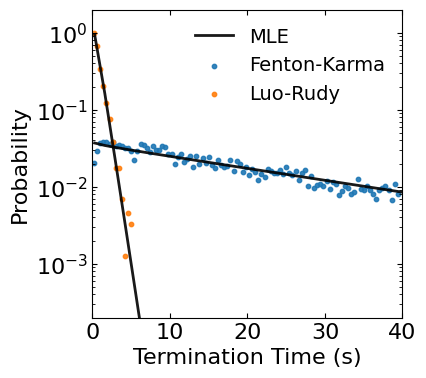

In [124]:
fig,ax=plt.subplots(figsize=(4,4))
fontsize=16
alpha=0.9
# xlim=[0,250]
# xlim=[0,100]
# xlim=[0,20]
xlim=[0,40]

# #plot histograms
# bins = np.arange(0.,220.,1.6)
# ax.hist(t_term_values_fk,color='C0',alpha=alpha,density=True,bins=bins,stacked=True)#,label='Fenton-Karma')
# bins = np.arange(0.,220.,0.4)
# ax.hist(t_term_values_lr,color='C1',alpha=alpha,density=True,bins=bins,stacked=True)#,label='Luo-Rudy')


# #plot line plot traces
x = np.linspace(gamma.ppf(0.01, shpe_fk,loc=loc_fk,scale=scale_fk),
                gamma.ppf(0.99, shpe_fk,loc=loc_fk,scale=scale_fk), 100)
# x = np.arange(0.1,40,0.4)
ax.plot(x, gamma.pdf(x, shpe_fk,loc=loc_fk,scale=scale_fk),
       'k-', lw=2, alpha=alpha, label='_MLE Fit')
ax.plot(x, gamma.pdf(x, shpe_lr,loc=loc_lr,scale=scale_lr),
       'k-', lw=2, alpha=alpha, label='MLE')

#plot line plot traces
ax.scatter(t_term_fk,prob_fk,color='C0',alpha=alpha,label='Fenton-Karma',s=10)
ax.scatter(t_term_lr,prob_lr,color='C1',alpha=alpha,label='Luo-Rudy',s=10)



#format_plot
format_plot(ax=ax,xlabel='Termination Time (s)',ylabel='Probability',fontsize=fontsize)#,use_loglog=True)
# ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(xlim)
# ax.set_ylim((11*1.0178650359332904e-05, 80))
# ax.set_ylim((11*1.0178650359332904e-05, 8))
ax.set_ylim((2e-4, 2))
ax.tick_params(top=True, right=True,direction='in',which='both')
ax.legend(fontsize=fontsize-2,frameon=False)
plt.show()

In [125]:
mtt_fk = dict_results_master_fk['tau']
mtt_lr = dict_results_master_lr['tau']

#input: mtt, (if exponential isn't working) shape of distribution
#output: t_term,prob_t_term
x_values = np.arange(0,41,1) #s.
beta = 1/mtt_fk
prob_t_term_fk = beta*np.exp(-beta*x_values)

beta = 1/mtt_lr
prob_t_term_lr = beta*np.exp(-beta*x_values)

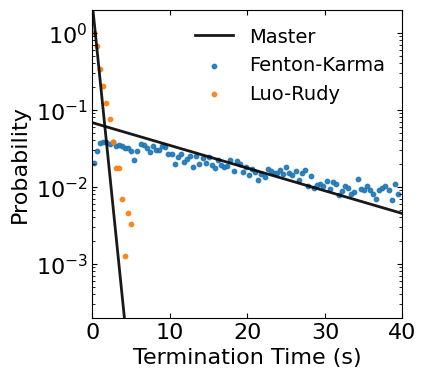

In [126]:
#DONE: plot predicted prob. of term from master eqns instead of the pdf of the gamma fit.
fig,ax=plt.subplots(figsize=(4,4))
fontsize=16
alpha=0.9
# xlim=[0,250]
# xlim=[0,100]
# xlim=[0,20]
xlim=[0,40]

# #plot histograms
# bins = np.arange(0.,220.,1.6)
# ax.hist(t_term_values_fk,color='C0',alpha=alpha,density=True,bins=bins,stacked=True)#,label='Fenton-Karma')
# bins = np.arange(0.,220.,0.4)
# ax.hist(t_term_values_lr,color='C1',alpha=alpha,density=True,bins=bins,stacked=True)#,label='Luo-Rudy')

#plot line plot traces
ax.plot(x_values, prob_t_term_fk,
       'k-', lw=2, alpha=alpha, label='_Master Fit')
ax.plot(x_values, prob_t_term_lr,
       'k-', lw=2, alpha=alpha, label='Master')

#plot scatter plot traces
ax.scatter(t_term_fk,prob_fk,color='C0',alpha=alpha,label='Fenton-Karma',s=10)
ax.scatter(t_term_lr,prob_lr,color='C1',alpha=alpha,label='Luo-Rudy',s=10)

#format_plot
format_plot(ax=ax,xlabel='Termination Time (s)',ylabel='Probability',fontsize=fontsize)#,use_loglog=True)
ax.set_yscale('log')
ax.set_ylim((0.0002, 2.0))
ax.set_xlim(xlim)
ax.set_ylim((2e-4, 2))
ax.tick_params(top=True, right=True,direction='in',which='both')
ax.legend(fontsize=fontsize-2,frameon=False)
plt.show()

In [127]:
#recall termination times observed from full
# term_dir_fk='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_termination_times.csv'
# term_dir_lr='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr/200x200/tippos_per_001_termination_times.csv'
term_dir_fk=f'{nb_dir}/../../care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_termination_times.csv'
term_dir_lr=f'{nb_dir}/../../care/notebooks/Data/from_wjr/positions_lr/200x200/tippos_per_001_termination_times.csv'
df_term_fk = pd.read_csv(term_dir_fk)
df_term_lr = pd.read_csv(term_dir_lr)


In [128]:
#hertim
#TODO: quick kstest of t_term in the full models
# t_term_values_fk.shape, t_term_values_lr.shape
t_term_values_fk_og = df_term_fk['t_term'].values
t_term_values_lr_og = df_term_lr['t_term'].values

#test if exponential
nobs_fk = t_term_values_fk_og.shape[0]
nobs_lr = t_term_values_lr_og.shape[0]
_,p_expon_fk = stats.kstest(rvs=t_term_values_fk_og, 
                cdf=stats.expon.cdf)
#              cdf='expon')#, args=(), N=20, alternative='two-sided', mode='auto')
_,p_expon_lr = stats.kstest(rvs=t_term_values_lr_og, 
                             cdf=stats.expon.cdf)
#              cdf='expon')#, args=(), N=20, alternative='two-sided', mode='auto')
print(f"FK: p_expon = {p_expon_fk} (N={nobs_fk})")
print(f"LR: p_expon = {p_expon_lr} (N={nobs_lr})")



FK: p_expon = 5.346605157767846e-85 (N=81)
LR: p_expon = 4.718292536015835e-08 (N=641)


In [129]:
#test if exponential
nobs_fk = t_term_values_fk.shape[0]
nobs_lr = t_term_values_lr.shape[0]
_,p_expon_fk = stats.kstest(rvs=t_term_values_fk, 
                cdf=stats.expon.cdf)
#              cdf='expon')#, args=(), N=20, alternative='two-sided', mode='auto')
_,p_expon_lr = stats.kstest(rvs=t_term_values_lr, 
                             cdf=stats.expon.cdf)
#              cdf='expon')#, args=(), N=20, alternative='two-sided', mode='auto')
print(f"FK: p_expon = {p_expon_fk} (N={nobs_fk})")
print(f"LR: p_expon = {p_expon_lr} (N={nobs_lr})")



FK: p_expon = 0.0 (N=10000)
LR: p_expon = 5.954717566848026e-125 (N=10000)


In [ ]:
# Q: is the variance signif. diff from the mean?

# estimate pdf of termination for increasing alinear

In [130]:
## DONE: recall annihilation rates for variable alinear0: print a collection of powerlaw fits for various a values, as before
# load  annihilation rates versus aliner from example in figure 3
death_rate_versus_alinear_dir=f'{nb_dir}/data/full_results/data_fig4_tymura_increasing_alinear.pkl'
data_death_rate_versus_alinear = load_from_pickle(death_rate_versus_alinear_dir)
df_death_rate_versus_alinear = data_death_rate_versus_alinear['df_death_rate_versus_alinear']
print(*data_death_rate_versus_alinear)

df_death_rate_versus_alinear df_increasing_alinear


In [131]:
model_name='Fenton-Karma'
Mp = dict_fit_birth_fk['M']
nup = dict_fit_birth_fk['m']
Mm = dict_fit_death_fk['M']
num = dict_fit_death_fk['m']

In [132]:
# comp_Wp

In [133]:
# input size of computational domain with pbc
L=5 #cm
A=L**2 #cm^2
num_iter=20 # max num particles to consider divided by two.
# alinear_lst = [30, 25, 20, 15, 10, 5, 4, 3, 2, 1, 0]
alinear_lst = [30, 25, 20, 15, 10, 5, 4, 3, 2, 1]
printing=True
dict_results_master_lst=[]
for alinear in alinear_lst:
    dg = df_death_rate_versus_alinear [ df_death_rate_versus_alinear['alinear'] == alinear ]
    num = float(dg['nu_minus'])
    Delta_num = float(dg['Delta_nu_minus'])
    Mm = float(dg['M_minus'])
    Delta_Mm = float(dg['Delta_M_minus'])
    ################################
    # estimate mtt 
    ################################
    #implement model
    comp_Wp = get_comp_W(A,nup,Mp)
    comp_Wm = get_comp_W(A,num,Mm)
    phi = get_phi(comp_Wm,comp_Wp)
    eval_tau= get_eval_tau(eval_tau_expression)
    #estimate the quasistatic distribution
    n_qs,prob_qs = comp_quasistatic_distrib_paired_bdrates(comp_Wm,comp_Wp,num_iter=num_iter)
    #estimate the mean termination time
    tau = eval_tau(n_qs, prob_qs, phi, comp_Wm, comp_Wp, maxinf_num_inner_sum=num_iter, printing=False)#,**kwargs)
    
    #not used elsewhere
    # tscale=1e-3
    # tau*=tscale
    
    #estimate the mean number of particles
    nbar = np.sum(prob_qs*n_qs)
    nsqbar = np.sum(prob_qs*(n_qs**2))
    xv = np.arange(0.02, 1,0.001)
    qstar,wstar = comp_powerlaw_intersection(Mp,nup,Mm,num,xv=xv)
    #record
    dict_results_master_ = dict(
        model=model_name,
        alinear=alinear,
        tau=tau,
        nbar=nbar,
        qstarA=qstar*A,
        A=A,
        Mp=Mp,nup=nup,
        Mm=Mm,num=num,
        qstar=qstar,wstar=wstar,
        num_iter=num_iter,
        nsqbar=nsqbar)
    #print summary
    if printing:
        print(f"{model_name} ({A=:.0f} cm^2) with {alinear=:.4f} cm^2/s:")
        print(f"- mean termination time (correct qs distr): {tau:.4f} s")    
        print(f"- mean num particles (correct qs distr): {nbar:.4f}")
        print(f"- mean num particles (qstar*A): {qstar*A:.4f}") 
    #record
    dict_results_master_lst.append(dict_results_master_)

df_results_master = pd.DataFrame(dict_results_master_lst)
df_results_master

Fenton-Karma (A=25 cm^2) with alinear=30.0000 cm^2/s:
- mean termination time (correct qs distr): 0.2044 s
- mean num particles (correct qs distr): 7.6143
- mean num particles (qstar*A): 2.1750
Fenton-Karma (A=25 cm^2) with alinear=25.0000 cm^2/s:
- mean termination time (correct qs distr): 0.2288 s
- mean num particles (correct qs distr): 7.4946
- mean num particles (qstar*A): 2.3500
Fenton-Karma (A=25 cm^2) with alinear=20.0000 cm^2/s:
- mean termination time (correct qs distr): 0.2562 s
- mean num particles (correct qs distr): 7.4687
- mean num particles (qstar*A): 2.5000
Fenton-Karma (A=25 cm^2) with alinear=15.0000 cm^2/s:
- mean termination time (correct qs distr): 0.3162 s
- mean num particles (correct qs distr): 7.2613
- mean num particles (qstar*A): 2.8250
Fenton-Karma (A=25 cm^2) with alinear=10.0000 cm^2/s:
- mean termination time (correct qs distr): 0.4334 s
- mean num particles (correct qs distr): 7.0342
- mean num particles (qstar*A): 3.3250
Fenton-Karma (A=25 cm^2) with 

,model,alinear,tau,nbar,qstarA,A,Mp,nup,Mm,num,qstar,wstar,num_iter,nsqbar
0,Fenton-Karma,30,0.204421,7.614251,2.175,25,0.86421,0.229594,13.391774,1.352150,0.087,0.493332,20,120.559626
1,Fenton-Karma,25,0.228830,7.494627,2.350,25,0.86421,0.229594,12.749082,1.366599,0.094,0.502176,20,116.315857
2,Fenton-Karma,20,0.256157,7.468703,2.500,25,0.86421,0.229594,11.849194,1.367244,0.100,0.509361,20,114.588400
3,Fenton-Karma,15,0.316155,7.261339,2.825,25,0.86421,0.229594,10.927803,1.394628,0.113,0.523856,20,106.894671
4,Fenton-Karma,10,0.433402,7.034220,3.325,25,0.86421,0.229594,9.673138,1.428133,0.133,0.543827,20,97.361857
5,Fenton-Karma,5,1.017562,6.576106,4.675,25,0.86421,0.229594,7.810438,1.542839,0.187,0.588083,20,74.726603
6,Fenton-Karma,4,1.367206,6.582178,5.125,25,0.86421,0.229594,7.210349,1.569050,0.205,0.600623,20,70.873975
7,Fenton-Karma,3,2.264153,6.626210,5.850,25,0.86421,0.229594,6.633941,1.633093,0.234,0.619149,20,65.373616
8,Fenton-Karma,2,5.934423,7.049171,7.100,25,0.86421,0.229594,5.876869,1.751465,0.284,0.647299,20,64.364663
9,Fenton-Karma,1,52.880871,8.715360,9.375,25,0.86421,0.229594,4.892471,1.996513,0.375,0.689953,20,87.113622


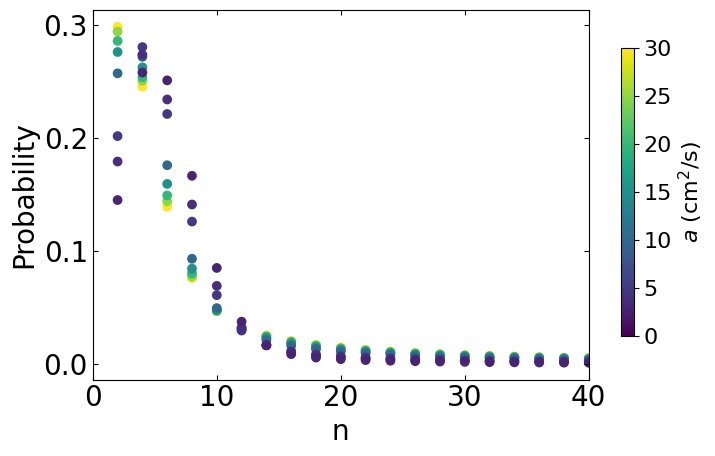

In [134]:
vmin=0
vmax=30
cmap='viridis'
fig,ax=plt.subplots()
alinear_lst_selected = [30, 25, 20, 15, 10, 5, 4, 3, ]
# alinear_lst_selected = [30, 25, 20, 15, 10, 5, 4, 3, 2, 1, 0]
# for alinear in alinear_lst:
for alinear in alinear_lst_selected:
    dg = df_death_rate_versus_alinear [ df_death_rate_versus_alinear['alinear'] == alinear ]
    num = float(dg['nu_minus'])
    Delta_num = float(dg['Delta_nu_minus'])
    Mm = float(dg['M_minus'])
    Delta_Mm = float(dg['Delta_M_minus'])
    ################################
    # estimate mtt 
    ################################
    #implement model
    comp_Wp = get_comp_W(A,nup,Mp)
    comp_Wm = get_comp_W(A,num,Mm)
    n_qs,prob_qs = comp_quasistatic_distrib_paired_bdrates(comp_Wm,comp_Wp,num_iter=num_iter)
    #plot the qs distrib.
    ax.scatter(n_qs,prob_qs,c=alinear+0.*n_qs,cmap=cmap,vmin=vmin,vmax=vmax)
    

norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
# norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
cmap_obj = mpl.cm.get_cmap(cmap)
cax = fig.add_axes([0.95, 0.2, 0.02, 0.6])
cb = mpl.colorbar.ColorbarBase(cax,
                               cmap=cmap_obj,
                               norm=norm,
                               spacing='proportional')
cb.set_label(r'$a$ (cm$^{2}/$s)', fontsize=fontsize)
cb.ax.tick_params(labelsize=fontsize)
ax.tick_params(top=True, right=True,direction='in',which='both')

#format_plot
format_plot(ax=ax,xlabel='n',ylabel='Probability')
# ax.legend(fontsize=fontsize)


ax.set_xlim([0,40])
plt.show()

In [135]:
df_results_master.head()

,model,alinear,tau,nbar,qstarA,A,Mp,nup,Mm,num,qstar,wstar,num_iter,nsqbar
0,Fenton-Karma,30,0.204421,7.614251,2.175,25,0.86421,0.229594,13.391774,1.352150,0.087,0.493332,20,120.559626
1,Fenton-Karma,25,0.228830,7.494627,2.350,25,0.86421,0.229594,12.749082,1.366599,0.094,0.502176,20,116.315857
2,Fenton-Karma,20,0.256157,7.468703,2.500,25,0.86421,0.229594,11.849194,1.367244,0.100,0.509361,20,114.588400
3,Fenton-Karma,15,0.316155,7.261339,2.825,25,0.86421,0.229594,10.927803,1.394628,0.113,0.523856,20,106.894671
4,Fenton-Karma,10,0.433402,7.034220,3.325,25,0.86421,0.229594,9.673138,1.428133,0.133,0.543827,20,97.361857


alinear=5.0000 cm^2/s yieled tau=1.0176 s
alinear=4.0000 cm^2/s yieled tau=1.3672 s
alinear=3.0000 cm^2/s yieled tau=2.2642 s
alinear=2.0000 cm^2/s yieled tau=5.9344 s
alinear=1.0000 cm^2/s yieled tau=52.8809 s


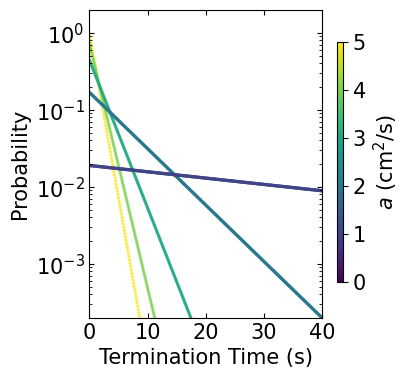

In [136]:
#DONE: plot predicted prob. of term from master eqns instead of the pdf of the gamma fit.
fontsize=15
alpha=0.9
cmap='viridis'
figsize=(3,4)
# xlim=[0,250]
# xlim=[0,100]
# xlim=[0,20]
xlim=[0,40]

# df_results_master

x_values = np.arange(0,41,0.1) #s.
alpha=0.7
alinear_lst_selected = [5, 4, 3, 2, 1]
# alinear_lst_selected = [30, 25, 20, 15, 10, 5, 4, 3, ]
# alinear_lst_selected = [30, 25, 20, 15, 10, 5, 4, 3, 2, 1]
# alinear_lst_selected = [30, 25, 20, 15, 10, 5, 4, 3, 2, 1, 0]

vmin=0
vmax=np.max(alinear_lst_selected)

fig,ax=plt.subplots(figsize=figsize)

# for alinear in alinear_lst:
for alinear in alinear_lst_selected:
    dg = df_results_master[df_results_master['alinear']==alinear]
    tau = float(dg['tau'])
    print(f"{alinear=:.4f} cm^2/s yieled {tau=:.4f} s")

    beta = 1/tau
    prob_t_term = beta*np.exp(-beta*x_values) 
    #plot line plot traces
    ax.scatter(x_values, prob_t_term, c=alinear+0.*x_values,s=2, alpha=alpha, label='_Master Fit',cmap=cmap,vmin=vmin,vmax=vmax)

#format_plot
format_plot(ax=ax,xlabel='Termination Time (s)',ylabel='Probability',fontsize=fontsize)#,use_loglog=True)
# ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim((0.0002, 2.0))
ax.set_xlim(xlim)
ax.set_xticks([0,10,20,30,40])
# ax.set_ylim((2e-4, 2))
ax.tick_params(top=True, right=True,direction='in',which='both')

norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
# norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
cmap_obj = mpl.cm.get_cmap(cmap)
cax = fig.add_axes([0.95, 0.2, 0.02, 0.6])
cb = mpl.colorbar.ColorbarBase(cax,
                               cmap=cmap_obj,
                               norm=norm,
                               spacing='proportional')
cb.set_label(r'$a$ (cm$^{2}/$s)', fontsize=fontsize)
cb.ax.tick_params(labelsize=fontsize)

# cax = fig.add_axes([0.17, 0.82, 0.7, 0.02])
# cb = mpl.colorbar.ColorbarBase(cax,
#                                cmap=cmap_obj,
#                                norm=norm,
#                                spacing='proportional',
#                                orientation='horizontal',#'vertical',
#                                ticks=[1,2,3,4,5],
#                               )
# cb.set_label(r'$a$ (cm$^{2}/$s)', fontsize=fontsize-3)
# cb.ax.tick_params(labelsize=fontsize-3)

ax.tick_params(top=True, right=True,direction='in',which='both')
ax.set_xlim([0,40])
plt.show()

m = -2.898983 +/- 0.401422
M = 55.657573 +/- 121.041930 Hz/cm^2; B=0.249968 +/- 0.041469
RMSE=1.8298 Hz/cm^2; R^2=0.9950; MPE=9.0532%; N=3


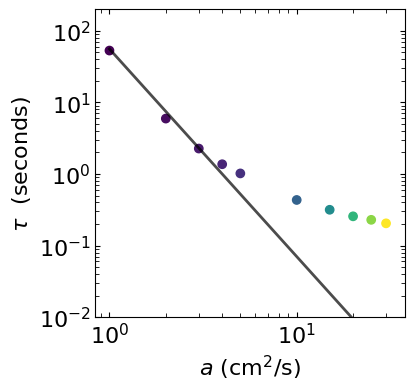

In [140]:
df_results_master.sort_values(by='alinear',inplace=True)
boo = (df_results_master['alinear']<=3)&(df_results_master['alinear']>0)
x=df_results_master['alinear'].values[boo]
y=df_results_master['tau'].values[boo]

dict_fit = print_fit_power_law(x,y)
# print_dict(dict_fit)
    

#DONE: plot predicted prob. of term from master eqns instead of the pdf of the gamma fit.
fig,ax=plt.subplots(figsize=(4,4))
# alinear_lst_selected = [30, 25, 20, 15, 10, 5, 4, 3, 2, 1]
# for alinear in alinear_lst_selected:
#     dg = df_results_master[df_results_master['alinear']==alinear]
#     tau = float(dg['tau'])
#     print(f"{alinear=:.4f} cm^2/s yieled {tau=:.4f} s")
# ax.scatter(x=1/df_results_master['alinear'].values,
ax.scatter(x=df_results_master['alinear'].values,
           y=df_results_master['tau'].values,#**0.5,#**2,#
           c=df_results_master['alinear'].values
          )

#plot powerlaw fit at low alinear values
xv = np.arange(1,32,0.01)
yv = dict_fit['M']*xv**dict_fit['m']
ax.plot(xv, yv,'k-', lw=2, alpha=alpha, label='Master')

# format_plot(ax=ax,xlabel=r'$a$ (cm$^2/$s)',ylabel=r'MTT (s)',fontsize=18)
format_plot(ax=ax,xlabel=r'$a$ (cm$^2/$s)',ylabel=r'$\tau$  (seconds)',fontsize=16)
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_yticks([1e0,1e1,1e2,1e3,1e4,1e5])
ax.tick_params(top=True, right=True,direction='in',which='both')
ax.tick_params(top=True, right=True,direction='in',which='minor',length=3)
# ax.set_xlim([1,30])
ax.set_ylim([1e-2,200])
plt.show()

m = -0.048899 +/- 0.000774
M = 1.226904 +/- 0.005100 Hz/cm^2; B=0.015269 +/- 0.000278
RMSE=0.0003 Hz/cm^2; R^2=0.9999; MPE=0.0191%; N=3
rmse=0.00031066019419616933
mpe=0.01907055353735154
Rsq=0.9999348697396561
num_obs=3
m=-0.0488992088413682
Delta_m=0.0007735055859128346
M=1.2269041289382412
Delta_M=0.005100414109411311
B=0.015268710246864992
Delta_B=0.00027831052339772103


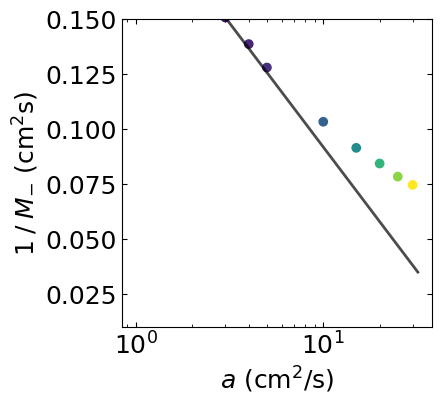

In [141]:
df_results_master.sort_values(by='alinear',inplace=True)
# boo = (df_results_master['alinear']<=30)&(df_results_master['alinear']>0)
boo = (df_results_master['alinear']<=3)&(df_results_master['alinear']>0)
x=df_results_master['alinear'].values[boo]
y=1/df_results_master[boo]['Mm'].values
dict_fit = print_fit_power_law(x,np.exp(y))
print_dict(dict_fit)

#DONE: plot predicted prob. of term from master eqns instead of the pdf of the gamma fit.
fig,ax=plt.subplots(figsize=(4,4))
# ax.scatter(x=1/df_results_master['alinear'].values,
ax.scatter(x=df_results_master['alinear'].values,
           y=1/df_results_master['Mm'].values,#**0.5,#**2,#
           c=df_results_master['alinear'].values)
#plot powerlaw fit at low alinear values
xv = np.arange(1,32,0.01)
yv = np.log(dict_fit['M']*xv**dict_fit['m'])
ax.plot(xv, yv,'k-', lw=2, alpha=alpha, label='Master')
#format_plot
# format_plot(ax=ax,xlabel=r'$a$ (cm$^2/$s)',ylabel=r'$M_{-}^{-1}$ (cm$^2$s)',fontsize=18)
format_plot(ax=ax,xlabel=r'$a$ (cm$^2/$s)',ylabel=r'$1\;/\;M_{-}$ (cm$^2$s)',fontsize=18)
ax.set_xscale('log')
# ax.set_yscale('log')
ax.tick_params(top=True, right=True,direction='in',which='both')
# ax.set_xlim([1,30])
ax.set_ylim([0.01,0.15])
plt.show()

m = 0.067900 +/- 0.009068
M = 1.667146 +/- 0.140001 Hz/cm^2; B=1858.306579 +/- 324.270574
RMSE=0.0411 Hz/cm^2; R^2=0.9642; MPE=1.8795%; N=10
rmse=0.04112535223113464
mpe=1.8795097625839954
Rsq=0.9641904088558584
num_obs=10
m=0.0679001421542148
Delta_m=0.009067760461591847
M=1.6671456123492514
Delta_M=0.1400014136989094
B=1858.3065792377308
Delta_B=324.27057359397594


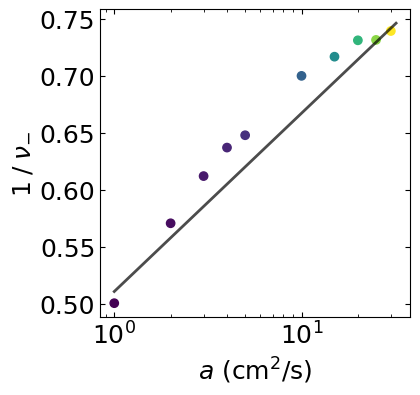

In [142]:
df_results_master.sort_values(by='alinear',inplace=True)
boo = (df_results_master['alinear']<=30)&(df_results_master['alinear']>0)
# boo = (df_results_master['alinear']<=3)&(df_results_master['alinear']>0)
x=df_results_master['alinear'].values[boo]
y=1/df_results_master[boo]['num'].values
dict_fit = print_fit_power_law(x,np.exp(y))
print_dict(dict_fit)

#DONE: plot predicted prob. of term from master eqns instead of the pdf of the gamma fit.
fig,ax=plt.subplots(figsize=(4,4))
# ax.scatter(x=1/df_results_master['alinear'].values,
ax.scatter(x=df_results_master['alinear'].values,
           y=1/df_results_master['num'].values,#**0.5,#**2,#
           c=df_results_master['alinear'].values)
#plot powerlaw fit at low alinear values
xv = np.arange(1,32,0.01)
yv = np.log(dict_fit['M']*xv**dict_fit['m'])
ax.plot(xv, yv,'k-', lw=2, alpha=alpha, label='Master')

#format_plot
# format_plot(ax=ax,xlabel=r'$a$ (cm$^2/$s)',ylabel=r'$M_{-}^{-1}$ (cm$^2$s)',fontsize=18)
# format_plot(ax=ax,xlabel=r'$a$ (cm$^2/$s)',ylabel=r'$1\;/\;\nu_{-}$ (cm$^2$s)',fontsize=18)
format_plot(ax=ax,xlabel=r'$a$ (cm$^2/$s)',ylabel=r'$1\;/\;\nu_{-}$',fontsize=18)
ax.set_xscale('log')
# ax.set_yscale('log')
ax.tick_params(top=True, right=True,direction='in',which='both')
# ax.set_xlim([1,30])
# ax.set_ylim([1,4])
plt.show()

In [143]:
# #inputs: mtt,Delta_mtt
# #outputs: pdf traces w/ resp. 95% CI
# #FK
# # mtt = dict_mtt_fk['mtt']
# # Delta_mtt = dict_mtt_fk['Delta_mtt']
# # #LR
# # mtt = dict_mtt_lr['mtt']
# # Delta_mtt = dict_mtt_lr['Delta_mtt']

# mtt_fk = dict_results_master_fk['tau']
# mtt_lr = dict_results_master_lr['tau']
# #inputs: mtt,Delta_mtt
# #outputs: pdf traces w/ resp. 95% CI

In [144]:

    
#     #TODO: estimate expected mtt
#     mtt = 
#     #TODO: estimate 95% of mtt 
#     mtt_err1 = 
#     mtt_err2 = 

# # mtt_fk = dict_results_master_fk['tau']
# # mtt_lr = dict_results_master_lr['tau']

# # #input: mtt, (if exponential isn't working) shape of distribution
# # #output: t_term,prob_t_term
# # x_values = np.arange(0,41,1) #s.
# # beta = 1/mtt_fk
# # prob_t_term_fk = beta*np.exp(-beta*x_values)

# # beta = 1/mtt_lr
# # prob_t_term_lr = beta*np.exp(-beta*x_values)
    
    
#     #TODO: record
# dg

In [145]:
df_results_master.sort_values(by='alinear',inplace=True)
# boo = (df_results_master['alinear']<=3)&(df_results_master['alinear']>0)
boo = (df_results_master['alinear']<=30)&(df_results_master['alinear']>0)
x=df_results_master['alinear'].values[boo].copy()
y=df_results_master['tau'].values[boo].copy()

tauinfty=y.min()
print(f"tau_infty: {tauinfty:.4f} seconds")
y-=tauinfty

# y-=y.min()
# dict_fit = print_fit_power_law(x,y)
dict_fit = print_fit_power_law(x[:-1],y[:-1]) #  --> ~ 5/2 power
# dict_fit = print_fit_power_law(x=np.array([x[0],x[1],x[-2]]),
#                                y=np.array([y[0],y[1],y[-2]])) #first and last points only --> ~ 8/3 power



tau_infty: 0.2044 seconds
m = -2.191997 +/- 0.187697
M = 32.971298 +/- 21.875339 Hz/cm^2; B=0.202964 +/- 0.017110
RMSE=6.5956 Hz/cm^2; R^2=0.9868; MPE=23.9265%; N=9


In [146]:
# dict_fit=dict(m=,M=)

# plot mean termination time versus alinear

tau_infty: 0.2044 seconds


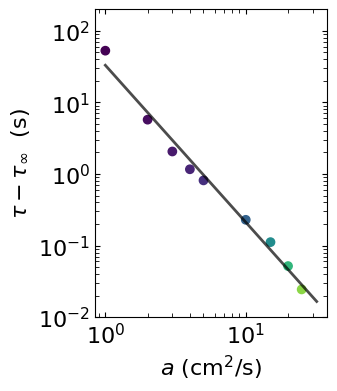

In [147]:

x=df_results_master['alinear'].values.copy()
y=df_results_master['tau'].values.copy()#**0.5,#**2,#
c=df_results_master['alinear'].values
print(f"tau_infty: {y.min():.4f} seconds")
y-=y.min()
# dict_fit = print_fit_power_law(x,y)
 
# y-=y.max()
# y*=-1


figsize=(4,4)
figsize=(3,4)
#DONE: plot predicted prob. of term from master eqns instead of the pdf of the gamma fit.
fig,ax=plt.subplots(figsize=figsize)
# alinear_lst_selected = [30, 25, 20, 15, 10, 5, 4, 3, 2, 1]
# for alinear in alinear_lst_selected:
#     dg = df_results_master[df_results_master['alinear']==alinear]
#     tau = float(dg['tau'])
#     print(f"{alinear=:.4f} cm^2/s yieled {tau=:.4f} s")
# ax.scatter(x=1/df_results_master['alinear'].values,
ax.scatter(x=x,
           y=y,#**0.5,#**2,#
           c=c)

#plot powerlaw fit at low alinear values
xv = np.arange(1,32,0.01)
yv = dict_fit['M']*xv**dict_fit['m']
ax.plot(xv, yv,'k-', lw=2, alpha=alpha, label='Master')

# format_plot(ax=ax,xlabel=r'$a$ (cm$^2/$s)',ylabel=r'MTT (s)',fontsize=18)
# format_plot(ax=ax,xlabel=r'$a$ (cm$^2/$s)',ylabel=r'$\tau$  (seconds)',fontsize=16)
# format_plot(ax=ax,xlabel=r'$a$ (cm$^2/$s)',ylabel=r'$\tau$  (s)',fontsize=16)
format_plot(ax=ax,xlabel=r'$a$ (cm$^2/$s)',ylabel=r'$\tau - \tau_\infty$  (s)',fontsize=16)
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_yticks([1e0,1e1,1e2,1e3,1e4,1e5])
ax.tick_params(top=True, right=True,direction='in',which='both')
ax.tick_params(top=True, right=True,direction='in',which='minor',length=3)
# ax.set_xlim([1,30])
ax.set_ylim([1e-2,200])
# ax.set_ylim([1e-2,100])
plt.show()

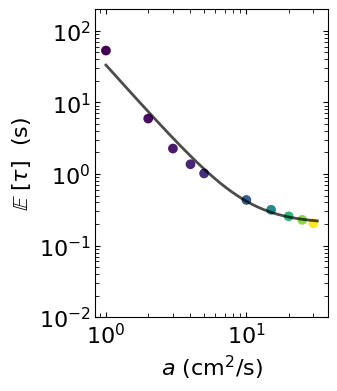

In [148]:

# x=df_results_master['alinear'].values.copy()
# y=df_results_master['tau'].values.copy()#**0.5,#**2,#
# c=df_results_master['alinear'].values
# tauinfty=y.min()
# print(f"tau_infty: {tauinfty:.4f} seconds")
# # y-=tauinfty
# dict_fit = print_fit_power_law(x,y-tauinfty)
 
# y-=y.max()
# y*=-1


figsize=(4,4)
figsize=(3,4)
#DONE: plot predicted prob. of term from master eqns instead of the pdf of the gamma fit.
fig,ax=plt.subplots(figsize=figsize)
# alinear_lst_selected = [30, 25, 20, 15, 10, 5, 4, 3, 2, 1]
# for alinear in alinear_lst_selected:
#     dg = df_results_master[df_results_master['alinear']==alinear]
#     tau = float(dg['tau'])
#     print(f"{alinear=:.4f} cm^2/s yieled {tau=:.4f} s")
# ax.scatter(x=1/df_results_master['alinear'].values,
ax.scatter(x=x,
           y=y+tauinfty,#**0.5,#**2,#
           c=c)

#plot powerlaw fit at low alinear values
xv = np.arange(1,32,0.01)
yv = dict_fit['M']*xv**dict_fit['m']
ax.plot(xv, yv+tauinfty,'k-', lw=2, alpha=alpha, label='Master')

# format_plot(ax=ax,xlabel=r'$a$ (cm$^2/$s)',ylabel=r'MTT (s)',fontsize=18)
# format_plot(ax=ax,xlabel=r'$a$ (cm$^2/$s)',ylabel=r'$\tau$  (seconds)',fontsize=16)
# format_plot(ax=ax,xlabel=r'$a$ (cm$^2/$s)',ylabel=r'$\tau$  (s)',fontsize=16)
format_plot(ax=ax,xlabel=r'$a$ (cm$^2/$s)',ylabel=r'$\mathbb{E}\;[\tau]$  (s)',fontsize=16)
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_yticks([1e0,1e1,1e2,1e3,1e4,1e5])
ax.tick_params(top=True, right=True,direction='in',which='both')
ax.tick_params(top=True, right=True,direction='in',which='minor',length=3)
# ax.set_xlim([1,30])
ax.set_ylim([1e-2,200])
# ax.set_ylim([1e-2,100])
plt.show()

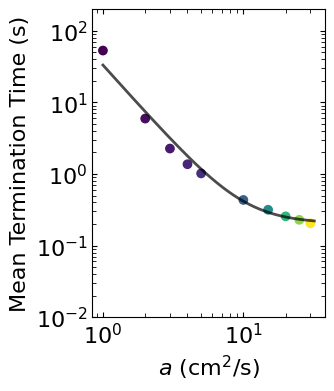

In [149]:

# x=df_results_master['alinear'].values.copy()
# y=df_results_master['tau'].values.copy()#**0.5,#**2,#
# c=df_results_master['alinear'].values
# tauinfty=y.min()
# print(f"tau_infty: {tauinfty:.4f} seconds")
# # y-=tauinfty
# dict_fit = print_fit_power_law(x,y-tauinfty)
 
# y-=y.max()
# y*=-1


figsize=(4,4)
figsize=(3,4)
#DONE: plot predicted prob. of term from master eqns instead of the pdf of the gamma fit.
fig,ax=plt.subplots(figsize=figsize)
# alinear_lst_selected = [30, 25, 20, 15, 10, 5, 4, 3, 2, 1]
# for alinear in alinear_lst_selected:
#     dg = df_results_master[df_results_master['alinear']==alinear]
#     tau = float(dg['tau'])
#     print(f"{alinear=:.4f} cm^2/s yieled {tau=:.4f} s")
# ax.scatter(x=1/df_results_master['alinear'].values,
ax.scatter(x=x,
           y=y+tauinfty,#**0.5,#**2,#
           c=c)

#plot powerlaw fit at low alinear values
xv = np.arange(1,32,0.01)
yv = dict_fit['M']*xv**dict_fit['m']
ax.plot(xv, yv+tauinfty,'k-', lw=2, alpha=alpha, label='Master')

# format_plot(ax=ax,xlabel=r'$a$ (cm$^2/$s)',ylabel=r'MTT (s)',fontsize=18)
# format_plot(ax=ax,xlabel=r'$a$ (cm$^2/$s)',ylabel=r'$\tau$  (seconds)',fontsize=16)
# format_plot(ax=ax,xlabel=r'$a$ (cm$^2/$s)',ylabel=r'$\tau$  (s)',fontsize=16)
# format_plot(ax=ax,xlabel=r'$a$ (cm$^2/$s)',ylabel=r'$\mathbb{E}\;[\tau]$  (s)',fontsize=16)
format_plot(ax=ax,xlabel=r'$a$ (cm$^2/$s)',ylabel=r'Mean Termination Time (s)',fontsize=16)
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_yticks([1e0,1e1,1e2,1e3,1e4,1e5])
ax.tick_params(top=True, right=True,direction='in',which='both')
ax.tick_params(top=True, right=True,direction='in',which='minor',length=3)
# ax.set_xlim([1,30])
ax.set_ylim([1e-2,200])
# ax.set_ylim([1e-2,100])
plt.show()

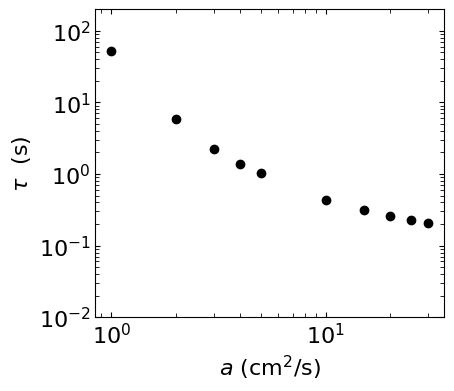

In [150]:

# x=df_results_master['alinear'].values.copy()
# y=df_results_master['tau'].values.copy()#**0.5,#**2,#
# c=df_results_master['alinear'].values
# tauinfty=y.min()
# print(f"tau_infty: {tauinfty:.4f} seconds")
# # y-=tauinfty
# dict_fit = print_fit_power_law(x,y-tauinfty)
 
# y-=y.max()
# y*=-1

figsize=(4,4)
figsize=(3,4)
figsize=(4.5,4)
#DONE: plot predicted prob. of term from master eqns instead of the pdf of the gamma fit.
fig,ax=plt.subplots(figsize=figsize)
# alinear_lst_selected = [30, 25, 20, 15, 10, 5, 4, 3, 2, 1]
# for alinear in alinear_lst_selected:
#     dg = df_results_master[df_results_master['alinear']==alinear]
#     tau = float(dg['tau'])
#     print(f"{alinear=:.4f} cm^2/s yieled {tau=:.4f} s")
# ax.scatter(x=1/df_results_master['alinear'].values,
ax.scatter(x=x,
           y=y+tauinfty,#**0.5,#**2,#
           c='k')
#            c=c)

# #plot powerlaw fit at low alinear values
# xv = np.arange(1,32,0.01)
# yv = dict_fit['M']*xv**dict_fit['m']
# ax.plot(xv, yv+tauinfty,'k-', lw=2, alpha=alpha, label='Master')

# format_plot(ax=ax,xlabel=r'$a$ (cm$^2/$s)',ylabel=r'MTT (s)',fontsize=18)
# format_plot(ax=ax,xlabel=r'$a$ (cm$^2/$s)',ylabel=r'$\tau$  (seconds)',fontsize=16)
format_plot(ax=ax,xlabel=r'$a$ (cm$^2/$s)',ylabel=r'$\tau$  (s)',fontsize=16)
# format_plot(ax=ax,xlabel=r'$a$ (cm$^2/$s)',ylabel=r'$\mathbb{E}\;[\tau]$  (s)',fontsize=16)
# format_plot(ax=ax,xlabel=r'$a$ (cm$^2/$s)',ylabel=r'Mean Termination Time (s)',fontsize=16)
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_yticks([1e0,1e1,1e2,1e3,1e4,1e5])
ax.tick_params(top=True, right=True,direction='in',which='both')
ax.tick_params(top=True, right=True,direction='in',which='minor',length=3)
# ax.set_xlim([1,30])
ax.set_ylim([1e-2,200])
# ax.set_ylim([1e-2,100])
plt.show()

In [151]:
#TODO: save ^these xy points


In [152]:
#num vs. a is in http://localhost:8891/notebooks/Generation%20of%20figure%203.ipynb

In [153]:
#TODO: find PM's analysis re: when 1 is placed within range
#Q: does tau_infty: 0.09905308998441674seconds correspond to any of PM's values?
#directly, it seems not...
#option 1: suppose 1 is placed within range


In [154]:
#DONE: estimate MTT from the power law fits replacing Mm,num from fk with each alinear fit
#DONE: plot MTT versus alinear
#DONE: dev estimate of probability of termination time in terms of MTT
#HINT: what is the mean value of the gamma distribution i'm using?


# plot the termination times of both full models on the same panel for increasing $a$

In [155]:
6.5*1e7*25.9

1683500000.0

In [156]:
1683500000.0-1.6835*1e9

0.0

In [157]:
0.51*1.6*1e2

81.60000000000001

In [158]:
wjr=recall_powerlaw_fits_to_full_models()
#DONE: get token inputs prepared
dict_fit_death_lr = dict(wjr['lr_pbc'])
dict_fit_death_fk = dict(wjr['fk_pbc'])
Mp = dict_fit_birth_fk['M']
nup = dict_fit_birth_fk['m']
Mm = dict_fit_death_fk['M']
num = dict_fit_death_fk['m']
model_name='Fenton-Karma'

# Mp = dict_fit_birth_lr['M']
# nup = dict_fit_birth_lr['m']
# Mm = dict_fit_death_lr['M']
# num = dict_fit_death_lr['m']
# model_name='Luo-Rudy'


#estimate the quasistatic distribution
L=5 #cm
A=L**2
num_iter=20
comp_Wp = get_comp_W(A,nup,Mp)
comp_Wm = get_comp_W(A,num,Mm)
# n_qs,prob_qs = comp_quasistatic_distrib_paired_bdrates(comp_Wm,comp_Wp,num_iter=num_iter,freq_prev=1.)
n_qs,prob_qs = comp_quasistatic_distrib_paired_bdrates(comp_Wm,comp_Wp,num_iter=num_iter,freq_prev=100.)

In [159]:
amax=9999

In [160]:
## DONE: recall annihilation rates for variable alinear0: print a collection of powerlaw fits for various a values, as before
# load  annihilation rates versus aliner from example in figure 3
death_rate_versus_alinear_dir=f'{nb_dir}/data/full_results/data_fig4_tymura_increasing_alinear_run_36_LR.pkl'
data_death_rate_versus_alinear = load_from_pickle(death_rate_versus_alinear_dir)
df_death_rate_versus_alinear = data_death_rate_versus_alinear['df_death_rate_versus_alinear']
print(*data_death_rate_versus_alinear)

model_name='Luo-Rudy'
Mp = dict_fit_birth_lr['M']
nup = dict_fit_birth_lr['m']
Mm = dict_fit_death_lr['M']
num = dict_fit_death_lr['m']

#format data for extraction
# input size of computational domain with pbc
L=5 #cm
A=L**2 #cm^2
num_iter=20 # max num particles to consider divided by two.
# alinear_lst = [30, 25, 20, 15, 10, 5, 4, 3, 2, 1, 0]
# alinear_lst = [30, 25, 20, 15, 10, 5, 4, 3, 2, 1]
alinear_lst = list(df_death_rate_versus_alinear.alinear.drop_duplicates().values)
printing=True
dict_results_master_lst=[]
for alinear in alinear_lst:
    dg = df_death_rate_versus_alinear [ df_death_rate_versus_alinear['alinear'] == alinear ]
    num = float(dg['nu_minus'])
    Delta_num = float(dg['Delta_nu_minus'])
    Mm = float(dg['M_minus'])
    Delta_Mm = float(dg['Delta_M_minus'])
    ################################
    # estimate mtt 
    ################################
    #implement model
    comp_Wp = get_comp_W(A,nup,Mp)
    comp_Wm = get_comp_W(A,num,Mm)
    phi = get_phi(comp_Wm,comp_Wp)
    eval_tau= get_eval_tau(eval_tau_expression)
    #estimate the quasistatic distribution
    n_qs,prob_qs = comp_quasistatic_distrib_paired_bdrates(comp_Wm,comp_Wp,num_iter=num_iter)
    #estimate the mean termination time
    tau = eval_tau(n_qs, prob_qs, phi, comp_Wm, comp_Wp, maxinf_num_inner_sum=num_iter, printing=False)#,**kwargs)
    
    #not used elsewhere
    # tscale=1e-3
    # tau*=tscale
    
    #estimate the mean number of particles
    nbar = np.sum(prob_qs*n_qs)
    nsqbar = np.sum(prob_qs*(n_qs**2))
    xv = np.arange(0.02, 1,0.001)
    qstar,wstar = comp_powerlaw_intersection(Mp,nup,Mm,num,xv=xv)
    #record
    dict_results_master_ = dict(
        model=model_name,
        alinear=alinear,
        tau=tau,
        nbar=nbar,
        qstarA=qstar*A,
        A=A,
        Mp=Mp,nup=nup,
        Mm=Mm,num=num,
        qstar=qstar,wstar=wstar,
        num_iter=num_iter,
        nsqbar=nsqbar)
    #print summary
    if printing:
        print(f"{model_name} ({A=:.0f} cm^2) with {alinear=:.4f} cm^2/s:")
        print(f"- mean termination time (correct qs distr): {tau:.4f} s")    
        print(f"- mean num particles (correct qs distr): {nbar:.4f}")
        print(f"- mean num particles (qstar*A): {qstar*A:.4f}") 
    #record
    dict_results_master_lst.append(dict_results_master_)

df_results_master = pd.DataFrame(dict_results_master_lst)
df_results_master

#extract xy
df_results_master.sort_values(by='alinear',inplace=True)
boo = (df_results_master['alinear']<=amax)&(df_results_master['alinear']>0)
xlr=df_results_master['alinear'].values[boo]
ylr=df_results_master['tau'].values[boo]


df_death_rate_versus_alinear df_increasing_alinear
Luo-Rudy (A=25 cm^2) with alinear=80.0000 cm^2/s:
- mean termination time (correct qs distr): 0.0797 s
- mean num particles (correct qs distr): 7.9825
- mean num particles (qstar*A): 0.8250
Luo-Rudy (A=25 cm^2) with alinear=70.0000 cm^2/s:
- mean termination time (correct qs distr): 0.0856 s
- mean num particles (correct qs distr): 7.8859
- mean num particles (qstar*A): 0.9250
Luo-Rudy (A=25 cm^2) with alinear=1.0000 cm^2/s:
- mean termination time (correct qs distr): 211.1064 s
- mean num particles (correct qs distr): 11.3404
- mean num particles (qstar*A): 12.7250
Luo-Rudy (A=25 cm^2) with alinear=60.0000 cm^2/s:
- mean termination time (correct qs distr): 0.0905 s
- mean num particles (correct qs distr): 7.9201
- mean num particles (qstar*A): 0.9750
Luo-Rudy (A=25 cm^2) with alinear=8.0000 cm^2/s:
- mean termination time (correct qs distr): 0.4884 s
- mean num particles (correct qs distr): 6.7802
- mean num particles (qstar*A): 4.52

In [161]:
## DONE: recall annihilation rates for variable alinear0: print a collection of powerlaw fits for various a values, as before
# load  annihilation rates versus aliner from example in figure 3
death_rate_versus_alinear_dir=f'{nb_dir}/data/full_results/data_fig4_tymura_increasing_alinear_run_36_FK.pkl'
data_death_rate_versus_alinear = load_from_pickle(death_rate_versus_alinear_dir)
df_death_rate_versus_alinear = data_death_rate_versus_alinear['df_death_rate_versus_alinear']
print(*data_death_rate_versus_alinear)

model_name='Fenton-Karma'
Mp = dict_fit_birth_fk['M']
nup = dict_fit_birth_fk['m']
Mm = dict_fit_death_fk['M']
num = dict_fit_death_fk['m']

#format data for extraction
# input size of computational domain with pbc
L=5 #cm
A=L**2 #cm^2
num_iter=20 # max num particles to consider divided by two.
# alinear_lst = [30, 25, 20, 15, 10, 5, 4, 3, 2, 1, 0]
# alinear_lst = [30, 25, 20, 15, 10, 5, 4, 3, 2, 1]
alinear_lst = list(df_death_rate_versus_alinear.alinear.drop_duplicates().values)
printing=True
dict_results_master_lst=[]
for alinear in alinear_lst:
    dg = df_death_rate_versus_alinear [ df_death_rate_versus_alinear['alinear'] == alinear ]
    num = float(dg['nu_minus'])
    Delta_num = float(dg['Delta_nu_minus'])
    Mm = float(dg['M_minus'])
    Delta_Mm = float(dg['Delta_M_minus'])
    ################################
    # estimate mtt 
    ################################
    #implement model
    comp_Wp = get_comp_W(A,nup,Mp)
    comp_Wm = get_comp_W(A,num,Mm)
    phi = get_phi(comp_Wm,comp_Wp)
    eval_tau= get_eval_tau(eval_tau_expression)
    #estimate the quasistatic distribution
    n_qs,prob_qs = comp_quasistatic_distrib_paired_bdrates(comp_Wm,comp_Wp,num_iter=num_iter)
    #estimate the mean termination time
    tau = eval_tau(n_qs, prob_qs, phi, comp_Wm, comp_Wp, maxinf_num_inner_sum=num_iter, printing=False)#,**kwargs)
    
    #not used elsewhere
    # tscale=1e-3
    # tau*=tscale
    
    #estimate the mean number of particles
    nbar = np.sum(prob_qs*n_qs)
    nsqbar = np.sum(prob_qs*(n_qs**2))
    xv = np.arange(0.02, 1,0.001)
    qstar,wstar = comp_powerlaw_intersection(Mp,nup,Mm,num,xv=xv)
    #record
    dict_results_master_ = dict(
        model=model_name,
        alinear=alinear,
        tau=tau,
        nbar=nbar,
        qstarA=qstar*A,
        A=A,
        Mp=Mp,nup=nup,
        Mm=Mm,num=num,
        qstar=qstar,wstar=wstar,
        num_iter=num_iter,
        nsqbar=nsqbar)
    #print summary
    if printing:
        print(f"{model_name} ({A=:.0f} cm^2) with {alinear=:.4f} cm^2/s:")
        print(f"- mean termination time (correct qs distr): {tau:.4f} s")    
        print(f"- mean num particles (correct qs distr): {nbar:.4f}")
        print(f"- mean num particles (qstar*A): {qstar*A:.4f}") 
    #record
    dict_results_master_lst.append(dict_results_master_)

df_results_master = pd.DataFrame(dict_results_master_lst)

#extract xy
df_results_master.sort_values(by='alinear',inplace=True)
boo = (df_results_master['alinear']<=amax)&(df_results_master['alinear']>0)
xfk=df_results_master['alinear'].values[boo]
yfk=df_results_master['tau'].values[boo]


df_death_rate_versus_alinear df_increasing_alinear
Fenton-Karma (A=25 cm^2) with alinear=80.0000 cm^2/s:
- mean termination time (correct qs distr): 0.1271 s
- mean num particles (correct qs distr): 7.8082
- mean num particles (qstar*A): 1.5750
Fenton-Karma (A=25 cm^2) with alinear=70.0000 cm^2/s:
- mean termination time (correct qs distr): 0.1379 s
- mean num particles (correct qs distr): 7.7415
- mean num particles (qstar*A): 1.6750
Fenton-Karma (A=25 cm^2) with alinear=1.0000 cm^2/s:
- mean termination time (correct qs distr): 52.8809 s
- mean num particles (correct qs distr): 8.7154
- mean num particles (qstar*A): 9.3750
Fenton-Karma (A=25 cm^2) with alinear=60.0000 cm^2/s:
- mean termination time (correct qs distr): 0.1486 s
- mean num particles (correct qs distr): 7.7653
- mean num particles (qstar*A): 1.7500
Fenton-Karma (A=25 cm^2) with alinear=8.0000 cm^2/s:
- mean termination time (correct qs distr): 0.5503 s
- mean num particles (correct qs distr): 6.8846
- mean num particle

In [162]:
aline_fk = 1.552
aline_lr = 9.3
tau_fk = yfk[xfk==aline_fk][0]
tau_lr = ylr[xlr==aline_lr][0]

In [163]:
# xlr,xfk

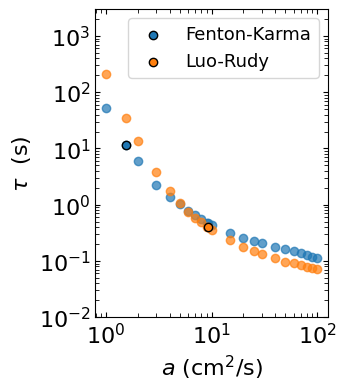

In [164]:
figsize=(3,4)
fontsize=15
alpha=0.7
# figsize=(9.2,4)
fig,ax=plt.subplots(figsize=figsize)
# ax.scatter(x=x,
#            y=y+tauinfty,#**0.5,#**2,#
#            c='k')
ax.scatter(xfk,yfk,c='C0',alpha=alpha)#,label='Fenton-Karma')
ax.scatter(xlr,ylr,c='C1',alpha=alpha)#,label='Luo-Rudy')
ax.scatter([aline_fk],[tau_fk],marker='o',edgecolor='k',c='C0',#'k',
           alpha=1,label='Fenton-Karma')
ax.scatter([aline_lr],[tau_lr],marker='o',edgecolor='k',c='C1',#c='k',
           alpha=1,label='Luo-Rudy')


format_plot(ax=ax,xlabel=r'$a$ (cm$^2/$s)',ylabel=r'$\tau$  (s)',fontsize=16)
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(top=True, right=True,direction='in',which='both')
ax.tick_params(top=True, right=True,direction='in',which='minor',length=3)
ax.set_ylim([1e-2,3000])
# AddLegend(ax=ax,xy=(-0.12,0.240),fontsize=fontsize-3)
leg = ax.legend(loc='upper right',fontsize=fontsize-2)#,frameon=False,ncol=1)
# leg = ax.legend(loc='lower right',fontsize=fontsize-3.,frameon=False,ncol=1)
for lh in leg.legendHandles: 
    lh.set_alpha(1)

# AddLegend(ax=ax,xy=(0.05,0.990),fontsize=fontsize-3)
# AddLegend(ax=ax,xy=(0.7,0.990),fontsize=fontsize-3)
# AddLegend(ax=ax,xy=(0.4,0.990),fontsize=fontsize-3)
# AddLegend(ax=ax,xy=(0.1,0.25),fontsize=fontsize-3)

plt.show()

# scatter plot amax versus A

In [ ]:
#src: wj
#DONE: recall amax versus A
dict_amax_lst_fk=[]
for model,	width,	amax,	amax_again, in [
    ('FK',	150,	1.6779,	1.6779),
    ('FK',	200,	1.7812,	1.7811),
    ('FK',	250,	1.8334,	1.8337)]:
    dict_amax_lst_fk.append(
        dict(model=model,width=width,amax=amax,amax_again=amax_again)
    )
    
#src: wj
dict_amax_lst_lr=[]
for model,	width,	amax,	amax_again, in [
    ('LR',	200,	10.147,	10.147),
    ('LR',	250,	10.5917,10.5941),
    ('LR',	300,	11.4431,11.442),
    ('LR',	350,	11.5883,11.5875),
    ('LR',	400,	11.606,	11.6056),]:
    dict_amax_lst_lr.append(
        dict(model=model,width=width,amax=amax,amax_again=amax_again)
    )
df_fk = pd.DataFrame(dict_amax_lst_fk)
df_lr = pd.DataFrame(dict_amax_lst_lr)

In [ ]:
D_fk = 0.05
D_lr = 0.05

In [ ]:
DS=0.025 #cm/px
#compute scatter plot xy values
df = df_fk
df['L']=df['width']*DS
df['A']=df['L']**2
df['Delta_amax'] = np.abs(df['amax'] -df['amax_again'])
x_values_fk = df['A'].values
# y_values_fk = df['amax'].values
y_values_fk = df['amax'].values - 2*D_fk
yerr_values_fk = df['Delta_amax'].values
print(f"{yerr_values_fk=}")

df = df_lr
df['L']=df['width']*DS
df['A']=df['L']**2
df['Delta_amax'] = np.abs(df['amax'] -df['amax_again'])
x_values_lr = df['A'].values
# y_values_lr = df['amax'].values 
y_values_lr = df['amax'].values  - 2*D_lr
yerr_values_lr = df['Delta_amax'].values
print(f"{yerr_values_lr=}")

In [ ]:
figsize=(4,4)
# figsize=(3,4)
#scatter plot amax versus A
fig,ax=plt.subplots(figsize=figsize)
fontsize=16
alpha=0.9
# xlim=[0,250]
# xlim=[0,100]
# xlim=[0,20]
xlim=[0,40]

# #plot line plot traces
ax.scatter(x_values_fk,y_values_fk,color='C0',alpha=alpha,label='Fenton-Karma',s=10)
ax.scatter(x_values_lr,y_values_lr,color='C1',alpha=alpha,label='Luo-Rudy',s=10)


# #plot line plot traces
# x = np.linspace(gamma.ppf(0.01, shpe_fk,loc=loc_fk,scale=scale_fk),
#                 gamma.ppf(0.99, shpe_fk,loc=loc_fk,scale=scale_fk), 100)
# # x = np.arange(0.1,40,0.4)
# ax.plot(x, gamma.pdf(x, shpe_fk,loc=loc_fk,scale=scale_fk),
#        'k-', lw=2, alpha=alpha, label='_MLE Fit')
# ax.plot(x, gamma.pdf(x, shpe_lr,loc=loc_lr,scale=scale_lr),
#        'k-', lw=2, alpha=alpha, label='MLE')


#format_plot
format_plot(ax=ax,xlabel=r'$A$ (cm$^2$)',ylabel=r'$a$ (cm$^2$/s)',fontsize=fontsize)
# format_plot(ax=ax,xlabel=r'$A$ (cm$^2$)',ylabel=r'$a+2D$ (cm$^2$/s)',fontsize=fontsize)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlim(xlim)
# ax.set_ylim((11*1.0178650359332904e-05, 80))
# ax.set_ylim((11*1.0178650359332904e-05, 8))
ax.set_ylim((0,16))
ax.tick_params(top=True, right=True,direction='in',which='both')
ax.legend(fontsize=fontsize-2,frameon=False,loc='upper left')
# ax.legend(fontsize=fontsize-2,frameon=True)
plt.show()

In [ ]:
#print the max percent change in a for increasing A
percent_change_amax = 1.*(df_fk['amax'].max() - df_fk['amax'].min())/df_fk['amax'].min()
percent_change_A = 1.*(df_fk['A'].max() - df_fk['A'].min())/df_fk['A'].min()
# percent_change_A = 1.*(df_fk['A'].max() - 25)/df_fk['A'].min()
print(f"For FK model, increasing $A$ by {percent_change_A:.7%} increased $a$ by {percent_change_amax:.7%}.")
# print(f"For the FK model, increasing $A$ by {percent_change_A:.0%} increased $a$ by {percent_change_amax:.0%}.")

#print the max percent change in a for increasing A
percent_change_amax = 1.*(df_lr['amax'].max() - df_lr['amax'].min())/df_lr['amax'].min()
percent_change_A = 1.*(df_lr['A'].max() - df_lr['A'].min())/df_lr['A'].min()
print(f"For LR model, increasing $A$ by {percent_change_A:.7%} increased $a$ by {percent_change_amax:.7%}.")
# print(f"For the LR model, increasing $A$ by {percent_change_A:.0%} increased $a$ by {percent_change_amax:.0%}.")

In [ ]:
#print the max percent change in a for increasing A
percent_change_amax = 1.*(df_fk['amax'].max() - df_fk['amax'].min())/df_fk['amax'].min()
percent_change_A = 1.*(df_fk['A'].max() - df_fk['A'].min())/df_fk['A'].min()
# percent_change_A = 1.*(df_fk['A'].max() - 25)/df_fk['A'].min()
# print(f"For FK model, increasing $A$ by {percent_change_A:.7%} increased $a$ by {percent_change_amax:.7%}.")
print(f"For the FK model, increasing $A$ by {percent_change_A:.0%} increased $a$ by {percent_change_amax:.0%}.")

#print the max percent change in a for increasing A
percent_change_amax = 1.*(df_lr['amax'].max() - df_lr['amax'].min())/df_lr['amax'].min()
percent_change_A = 1.*(df_lr['A'].max() - df_lr['A'].min())/df_lr['A'].min()
# print(f"For LR model, increasing $A$ by {percent_change_A:.7%} increased $a$ by {percent_change_amax:.7%}.")
print(f"For the LR model, increasing $A$ by {percent_change_A:.0%} increased $a$ by {percent_change_amax:.0%}.")

# (deprecated) Generation of figure 4
Tim Tyree<br>
1.3.2022

In [230]:
#recall results from tables in the main mansucript
wjr=recall_powerlaw_fits_to_full_models()

input_fn=f"{nb_dir}/data/osg_output/run_17_all_powerlaw_fits.csv"
input_fn_dict={'vectorsummed':input_fn,'neighboronly':input_fn}

interp=recall_particle_model_interp(input_fn_dict=input_fn_dict)
a_hat_FK, D_hat_FK, a_hat_FK_long, a_hat_FK_vlong, a_hat_LR, D_hat_LR, a_hat_LR_long=recall_particle_parameter_measurements()

estimated runtime is ~20 seconds for 17988 training samples...
number of training examples is 17988....
training complete!


## DONE: fit annihilation rates of the interacting inverse-powerlaw particle model to those of the full models
- method of fit: minimization of mean squared error of the powerlaw fits of the particle model to those of the full models
- method of minimization: Nelder-Mead minimization

`
(deprecated) NOTE: for latest version of the manuscript's MSR versus tdeath plot, goto 
http://localhost:8889/notebooks/Analysis%20of%20model%20for%20time-reversed%20oscillatory%20particle%20model.ipynb
`

In [231]:
#fit the particle model to the luo-rudy model
dict_out_lr=PlotParticlModelAnnihilationRateFit(a=a_hat_LR,D=D_hat_LR,wjr=wjr,interp=interp,
    ax=None,model_name='lr_pbc',c='C1')

a=9.60637, D=0.586055, r=0.12334599275920105, kappa=429.28076333754547, rmse=0.035064357470705694


In [232]:
#fit the particle model to the fenton-karma model
dict_out_fk=PlotParticlModelAnnihilationRateFit(a=a_hat_FK_vlong,D=D_hat_FK,wjr=wjr,interp=interp,
    ax=None,model_name='fk_pbc',c='C0')

a=1.604153, D=0.365238, r=0.06045942685825395, kappa=495.2654122924846, rmse=0.006797231616047614


In [233]:
print(f"amax: {9.60637 + 2*0.586055}")
print(f"amax: {1.604153 + 2*0.365238}")

amax: 10.77848
amax: 2.334629


In [234]:
#recall ^these fits from lib
a,D,r,kappa,rmse=recall_particle_parameter_fits('luorudy')
print(f"a={a},    D={D}, r={r}, kappa={kappa},  rmse={rmse}")
a,D,r,kappa,rmse=recall_particle_parameter_fits('fentonkarma')
print(f"a={a}, D={D}, r={r}, kappa={kappa}, rmse={rmse}")

a=8.595,    D=0.586055, r=0.10413888309470609, kappa=559.500160485693,  rmse=0.028075538795257697
a=1.604153, D=0.365238, r=0.06045948522530842, kappa=495.2658318951493, rmse=0.006797222653889483


## DONE(Fig. 3.A): quick mockup of barchart 
quick mockup of barchart showing durations (and bootstrapped 95% CI) of (i) mean period estimates and (ii) mean lifetime estimates for (blue) the Fenton-Karma model and (orange) the Luo-Rudy model

In [235]:
#reset matplotlib
mpl.rcParams.update(matplotlib.rcParamsDefault)

In [236]:
#TODO: compute the kinematic periods from the full models
meanT_dir_lr='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/luorudy_mean_kinematic_periods.npz'
meanT_dir_fk='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/fentonkarma_mean_kinematic_periods.npz'
# np.mean(meanT_values)

In [237]:
#TODO: copy & paste barcharts from neurophysics
#TODO: copy lifetimes from .xlsx
#TODO: estimate periods from plot and give reasonable 95% CI estimates
#TODO: copy & paste ^that to .odg as a re-first-draft of Fig. 3.A
#TODO: move on to my sketch of Fig. 3.B
# TODO(later): measure the period precisely
mean_lst=[90,100,310.057,82.7333]
Delta_mean_lst=[10,10,3.5354,0.9154]
# Nobs_lst=[43306,10362,43306,10362]#GUESSED PERIOD SAMPLE SIZES
Nobs_lst=[4330,1036,4330,1036]#GUESSED PERIOD SAMPLE SIZES
# Nobs_lst=[??,??,43306,10362]

In [238]:
#perform student t-tests for significantly different average values

In [239]:
stat,p=stats.ttest_ind_from_stats(mean1=mean_lst[2], std1=Delta_mean_lst[2]/1.96*np.sqrt(Nobs_lst[2]), nobs1=Nobs_lst[2],
                           mean2=mean_lst[3], std2=Delta_mean_lst[3]/1.96*np.sqrt(Nobs_lst[3]), nobs2=Nobs_lst[3])
print(f"a students t-test comparing the mean lifetimes from the Fenton-Karma model to those of the Luo-Rudy model yielded p={p}.")

a students t-test comparing the mean lifetimes from the Fenton-Karma model to those of the Luo-Rudy model yielded p=0.0.


In [240]:
stat,p=stats.ttest_ind_from_stats(mean1=mean_lst[0], std1=Delta_mean_lst[0]/1.96*np.sqrt(Nobs_lst[0]), nobs1=Nobs_lst[0],
                           mean2=mean_lst[1], std2=Delta_mean_lst[1]/1.96*np.sqrt(Nobs_lst[1]), nobs2=Nobs_lst[1])
print(f"a students t-test comparing the mean lifetimes from the Fenton-Karma model to those of the Luo-Rudy model yielded p={p}.")

a students t-test comparing the mean lifetimes from the Fenton-Karma model to those of the Luo-Rudy model yielded p=0.35119444375871434.


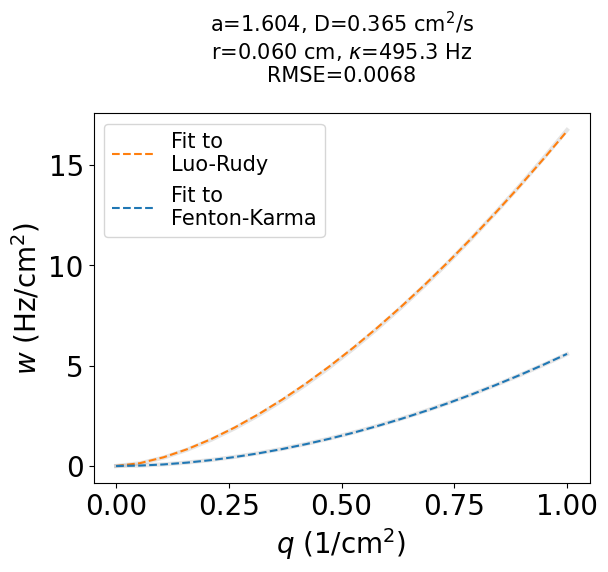

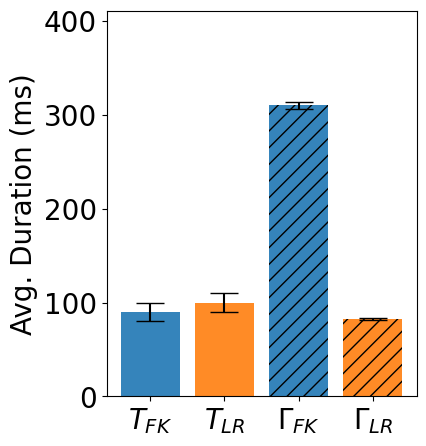

In [241]:
bar_height_values=np.array(mean_lst)
Delta_bar_height_values=np.array(Delta_mean_lst)
color_lst=['C0','C1','C0','C1']
bar_label_lst=[r'$T_{FK}$',r'$T_{LR}$',r'$\Gamma_{FK}$',r'$\Gamma_{LR}$']
# hatch: {'/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*'}
hatch_values=np.array(['','','//','//'])
# bar_label_lst=['Audio-Only\n\n\n','Match\n\n\n','Mismatch\n\n\n','Video-Only\n\n\n']
ylabel='Avg. Duration (ms)'#\nwith Preferred Modality'
fig,ax=plt.subplots(figsize=(4,5))
ax.bar(bar_label_lst,bar_height_values,hatch=hatch_values,yerr=Delta_bar_height_values,alpha=0.9,color=color_lst,capsize=10)
# ax.errorbar(bar_label_lst[0],bar_height_values[0],Delta_bar_height_values[0],alpha=0.9,color=color_lst[0])
format_plot(ax=ax,xlabel='',ylabel=ylabel)
# title=''
# ax.set_title(title,fontsize=18)
# plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylim([0,410])
# plt.xticks(rotation=90)
# plt.xticks(rotation=0)
# plt.xticks(rotation=-90)
plt.show()

## analytic fit to MSR

$$
\text{MSR}_\text{Osc.}(t')=4at'+\frac{8D}{\omega}\Big(sin(\omega t' + \phi_f) - sin(\phi_f)\Big)
$$

In [242]:
msr_dir_lr=f'{nb_dir}/data/full_results/msr_lr_boostrapped_tavg2_14.0_n_2083_a_8.6.csv'
# msr_dir_lr='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/msr_lr_boostrapped_tavg2_14.0_n_2083_a_8.6.csv'
# a_LR = 8.5950#+/-0.3771 cm^2/s
# tavg2=14 ms, num_samples=2083
msr_dir_fk=f'{nb_dir}/data/full_results/msr_fk_boostrapped_tavg2_14.0_n_19087_a_1.6_tmax_300.csv'
# msr_dir_fk='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/msr_fk_boostrapped_tavg2_14.0_n_19087_a_1.6_tmax_300.csv'
# a_FK = 1.604153#+/-0.040173 cm^2/s
# tavg2=14 ms, num_samples=19087, tmin=0, tmax=300 ms

df_msd_lr=pd.read_csv(msr_dir_lr)
x_values_LR=df_msd_lr['tdeath_avg'].values
y_values_LR=df_msd_lr['MSR'].values
yerr_values_LR=df_msd_lr['Delta_MSR'].values
df_msd_fk=pd.read_csv(msr_dir_fk)
x_values_FK=df_msd_fk['tdeath_avg'].values
y_values_FK=df_msd_fk['MSR'].values
yerr_values_FK=df_msd_fk['Delta_MSR'].values

tmax=300#ms
x_values=x_values_FK.copy()
y_values=y_values_FK.copy()
boo=x_values<tmax #ms
dict_a_SR=compute_95CI_ols(x_values[boo],y_values[boo])
a_SR=dict_a_SR['m']/4*1e3
Delta_a_SR=dict_a_SR['Delta_m']/4*1e3
print(f"a_hat_FK = {a_SR:.6f}+/-{Delta_a_SR:.6f} cm^2/s, tmax={tmax}")
a_hat_FK=a_SR

tmax=8#ms
x_values=x_values_LR.copy()
y_values=y_values_LR.copy()
boo=x_values<tmax #ms
dict_a_SR=compute_95CI_ols(x_values[boo],y_values[boo])
a_SR=dict_a_SR['m']/4*1e3
Delta_a_SR=dict_a_SR['Delta_m']/4*1e3
print(f"a_hat_LR = {a_SR:.6f}+/-{Delta_a_SR:.6f} cm^2/s, tmax={tmax}")
a_hat_LR=a_SR

a_hat_FK = 1.604153+/-0.040173 cm^2/s, tmax=300
a_hat_LR = 8.595018+/-0.377114 cm^2/s, tmax=8


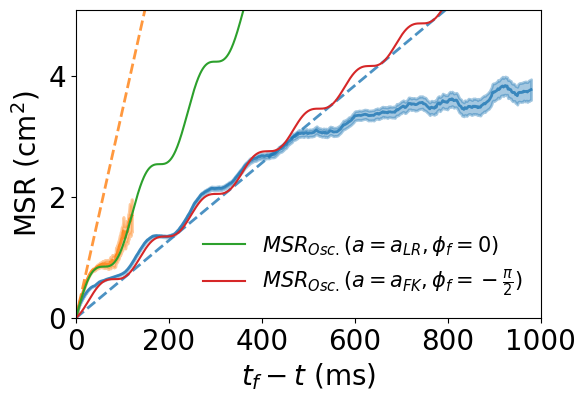

In [243]:
fontsize=15
fig,ax=plt.subplots(figsize=(6,4))
### plot expected
fontsize=20

xv=np.linspace(0,1e3,200)
ax.plot(xv,4*a_hat_LR*1e-3*xv,'--',lw=2,alpha=0.8,c='C1')
ax.plot(xv,4*a_hat_FK*1e-3*xv,'--',lw=2,alpha=0.8,c='C0')
#plot data
ax.plot(x_values_FK,y_values_FK,lw=2,alpha=0.8,c='C0')
ax.fill_between(x_values_FK,y_values_FK-yerr_values_FK,y_values_FK+yerr_values_FK,lw=2,alpha=0.4,color='C0')
ax.plot(x_values_LR,y_values_LR,lw=2,alpha=0.8,c='C1')
ax.fill_between(x_values_LR,y_values_LR-yerr_values_LR,y_values_LR+yerr_values_LR,lw=2,alpha=0.4,color='C1')

# MSR(t)=at + (2D/\omega) \sin(\omega t + \phi_f),
# DONE: plot ^this model for MSR for fitty parameter settings (LR)
# a=3.535902;D=a/2;phi_f=0.;period=0.1 #s
a=3.535902;D=a/2;
phi_f=0.;
# phi_f=-np.pi/2;
period=0.12 #s
omega=2*np.pi/period
constant=-8*D*np.sin(phi_f)/omega#0.15
t_values=np.linspace(0,1,1000)
MSR_values_oscillatory=4*(a*t_values+(2*D/omega)*np.sin(omega*t_values+phi_f))+constant
ax.plot(t_values*1e3,MSR_values_oscillatory,c='C2',
        label='$MSR_{Osc.} (a=a_{LR},\phi_f=0$)')
#         label=r'Oscillatory Solution ($a=a_{LR}$, $\phi_f=0$)')

#what param setting to use for the FK model?
phi_f=-np.pi/2;
a=1.604153;
period=0.11 #s
D=a/2;
# constant=0.15
omega=2*np.pi/period
constant=-8*D*np.sin(phi_f)/omega#0.15
t_values=np.linspace(0,1,1000)
MSR_values_oscillatory=4*(a*t_values+(2*D/omega)*np.sin(omega*t_values+phi_f))+constant
ax.plot(t_values*1e3,MSR_values_oscillatory,c='C3',
                label=r'$MSR_{Osc.} (a=a_{FK}, \phi_f=-\frac{\pi}{2})$')
#         label='$MSR_{Osc.} (a=a_{FK}, \phi_f=-\frac{\pi}{2})$')
#         label='Oscillatory Solution ($a=a_{FK}$, $\phi_f=-\pi/2$)')

# #what param setting to use for the FK model?
# phi_f=0#-np.pi/2;
# # a=1.604153;
# # period=0.11 #s
# # D=a/2;
# # constant=0.15
# omega=2*np.pi/period
# constant=-8*D*np.sin(phi_f)/omega#0.15
# t_values=np.linspace(0,1,1000)
# MSR_values_oscillatory=4*(a*t_values+(2*D/omega)*np.sin(omega*t_values+phi_f))+constant
# plt.plot(t_values*1e3,MSR_values_oscillatory,c='gray',label='Oscillatory Solution ($a=a_{FK}$, $\phi_f=0$)')

#format plot
format_plot(ax=ax,xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)',fontsize=fontsize)
plt.xlim([0,1000])
plt.ylim([0,5.1])
plt.legend(loc='lower right',fontsize=fontsize-5,frameon=False)
plt.show()
# print(f"tavg2={tavg2} ms, num_samples={max_num_groups}")

## generate MSR for the oscillatory model

In [244]:
include_earliest=False#True#broken?

In [245]:
#heretim
ahat_long=a_hat_FK_vlong#a_hat_LR_long
#Fenton-Karma
#GOAL: add a reasonable fit MSR from the reversed-time oscillatory particle model (dotted)
#DONE: select either of the xy values form the full model (OR copy & paste ^that to new ipynb)
#DONE: initialize the particle model for the FK model
a=2.4; #2.5?
D=1.2; T=120; phif=0.0003; Rf=1e-02; Ntrials=1000
# x_values,y_values=x_values_FK,y_values_FK
# #DONE: initialize the particle model for the LR model
# a=3.8; D=1.9; T=120; phif=0.0002; Rf=1e-02; Ntrials=1000
# x_values,y_values=x_values_LR,y_values_LR
T=100#110#140#100#120#180#90#240
D=0.365238#	0.004171	101774+/-103689,0.6,1.5,0.98 # from particle properties spreadsheet
a=1.6
D=ahat_long/2#/1 #/4#/4
a=ahat_long#/2
#TODO: recall my time reversed function that maps parameters of the oscillatory model to MSR
# gener_positions_oscillatory_reversed

# initial_phase_orientation=phif
# initial_phase_orientation-=np.pi/2-np.pi# worse/4#/2
initial_phase_orientation+=np.pi/2

num_pairs=10000#1min 30sec: 10+1#400#2min 22sec: 
#before, long runtime
dict_out,position_array = gener_positions_oscillatory_reversed(
            a=a, D=D, printing=False,num_pairs=num_pairs,initial_phase_orientation=initial_phase_orientation,
            include_earliest=include_earliest,
            period_of_oscillation=T)
print(*dict_out)
positions_out=position_array

#estimated run time: <1 minute
# positions_out=dict_out['positions_out']
Dt=1e-5
rstart=1e-4
title=f"a={a:.4f}, D={D:.4f},\n"+r"$\phi_0$"+f"={initial_phase_orientation:.4f}, "+r"R$_0$"+f"={rstart:.4f}, "+r" N$_{trials}$"+f"={num_pairs}\n"
print(f"positions_out.shape={positions_out.shape}")
#compute the distance between each pair of particles after aligning by annihilation (unshifted)
x1_values=positions_out[:,0]
y1_values=positions_out[:,1]
x2_values=positions_out[:,2]
y2_values=positions_out[:,3]
dx_values=(x2_values-x1_values)
dy_values=(y2_values-y1_values)
Rsq_values=dx_values**2+dy_values**2
#compute the ensemble averaged values
MSR_values=np.mean(Rsq_values,axis=1)
aligned_coordinates_values=np.mean(positions_out,axis=-1)
# maxt=Dt*MSR_values.shape[0]
t_values=np.arange(MSR_values.shape[0])*Dt

t_values_fk_osc=t_values.copy()
MSR_values_fk_osc=MSR_values.copy()
beep(5)

KeyboardInterrupt: 

In [ ]:
#heretim
ahat_long=a_hat_LR_long#a_hat_FK_vlong#
#Luo-Rudy
#runtime was ~40 seconds
#recompute the Luo-Rudy model's fitty for the MSR of the oscillatory model 
#GOAL: add a reasonable fit MSR from the reversed-time oscillatory particle model (dotted)
#DONE: select either of the xy values form the full model (OR copy & paste ^that to new ipynb)
#DONE: initialize the particle model for the FK model
a=2.5; D=1.2; T=120; phif=0.0003; Rf=1e-02; Ntrials=1000
# x_values,y_values=x_values_FK,y_values_FK
#DONE: initialize the particle model for the LR model
a=3.8; D=1.9; T=120; phif=0.0002; Rf=1e-02; Ntrials=1000
# x_values,y_values=x_values_LR,y_values_LR

#TODO: try to get a reasonable a for LR given D=D_LR
D=0.586055#	0.087553	1871+/-520,0,0.55*,0.89#from particle properties spreadsheet
a=5#too big 8.5#tad small...9#4.5#discontinuous... 5#too small... 3.8
T=120#100#240#120
D=ahat_long/2#/1 #/4
a=ahat_long
#TODO: recall my time reversed function that maps parameters of the oscillatory model to MSR
# gener_positions_oscillatory_reversed

initial_phase_orientation=phif
num_pairs=10000#1min 30sec: 10+1#400#2min 22sec: 
#before, long runtime
dict_out,position_array = gener_positions_oscillatory_reversed(
            a=a, D=D, printing=False,num_pairs=num_pairs,initial_phase_orientation=initial_phase_orientation,
            include_earliest=include_earliest,
            period_of_oscillation=T)

print(*dict_out)
positions_out=position_array

#estimated run time: <1 minute
# positions_out=dict_out['positions_out']
Dt=1e-5
rstart=1e-4
title=f"a={a:.4f}, D={D:.4f},\n"+r"$\phi_0$"+f"={initial_phase_orientation:.4f}, "+r"R$_0$"+f"={rstart:.4f}, "+r" N$_{trials}$"+f"={num_pairs}\n"
print(f"positions_out.shape={positions_out.shape}")
#compute the distance between each pair of particles after aligning by annihilation (unshifted)
x1_values=positions_out[:,0]
y1_values=positions_out[:,1]
x2_values=positions_out[:,2]
y2_values=positions_out[:,3]
dx_values=(x2_values-x1_values)
dy_values=(y2_values-y1_values)
Rsq_values=dx_values**2+dy_values**2
#compute the ensemble averaged values
MSR_values=np.mean(Rsq_values,axis=1)
aligned_coordinates_values=np.mean(positions_out,axis=-1)
# maxt=Dt*MSR_values.shape[0]
t_values=np.arange(MSR_values.shape[0])*Dt

t_values_lr_osc=t_values.copy()
MSR_values_lr_osc=MSR_values.copy()
beep(5)

In [ ]:
!pwd

In [ ]:
#DONE: save dotted as .npz
msr_osc_fn=f"msr_osc_full.npz"
np.savez_compressed(msr_osc_fn,
                   t_values_fk_osc=t_values_fk_osc,
                   MSR_values_fk_osc=MSR_values_fk_osc,
                   t_values_lr_osc=t_values_lr_osc,
                   MSR_values_lr_osc=MSR_values_lr_osc)
print(f"msr_osc_fn='{os.path.abspath(msr_osc_fn)}'")
assert os.path.exists(msr_osc_fn)

In [ ]:
assert not np.isnan(Rsq_values).all()

## plot the results

In [ ]:
#estimate a_sr expected for this value with a sliding window
msr_dir_lr='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/msr_lr_boostrapped_tavg2_14.0_n_2083_a_8.6.csv'
# a_LR = 8.5950#+/-0.3771 cm^2/s
# tavg2=14 ms, num_samples=2083

msr_dir_fk='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/msr_fk_boostrapped_tavg2_14.0_n_19087_a_1.6_tmax_300.csv'
# a_FK = 1.604153#+/-0.040173 cm^2/s
# tavg2=14 ms, num_samples=19087, tmin=0, tmax=300 ms

In [ ]:
df_msd_lr=pd.read_csv(msr_dir_lr)
x_values_LR=df_msd_lr['tdeath_avg'].values
y_values_LR=df_msd_lr['MSR'].values
yerr_values_LR=df_msd_lr['Delta_MSR'].values
df_msd_fk=pd.read_csv(msr_dir_fk)
x_values_FK=df_msd_fk['tdeath_avg'].values
y_values_FK=df_msd_fk['MSR'].values
yerr_values_FK=df_msd_fk['Delta_MSR'].values

In [ ]:
tmax=300#8#ms
x_values=x_values_FK.copy()
y_values=y_values_FK.copy()
boo=x_values<tmax #ms
dict_a_SR=compute_95CI_ols(x_values[boo],y_values[boo])
a_SR=dict_a_SR['m']/4*1e3
Delta_a_SR=dict_a_SR['Delta_m']/4*1e3
print(f"a_hat_FK = {a_SR:.6f}+/-{Delta_a_SR:.6f} cm^2/s, tmax={tmax}")
a_hat_FK=a_SR

tmax=8#ms
x_values=x_values_LR.copy()
y_values=y_values_LR.copy()
boo=x_values<tmax #ms
dict_a_SR=compute_95CI_ols(x_values[boo],y_values[boo])
a_SR=dict_a_SR['m']/4*1e3
Delta_a_SR=dict_a_SR['Delta_m']/4*1e3
print(f"a_hat_LR = {a_SR:.6f}+/-{Delta_a_SR:.6f} cm^2/s, tmax={tmax}")
a_hat_LR=a_SR

In [ ]:
#heretim
#plot expected
xv=np.linspace(0,1e3,200)
plt.plot(xv,4*a_hat_LR*1e-3*xv,'--',lw=2,alpha=0.8,c='C1')
plt.plot(xv,4*a_hat_FK*1e-3*xv,'--',lw=2,alpha=0.8,c='C0')
#plot fitty
plt.plot(t_values_fk_osc*1e3,MSR_values_fk_osc,':',lw=2,alpha=0.5,c='C0')
plt.plot(t_values_lr_osc*1e3,MSR_values_lr_osc,':',lw=2,alpha=0.5,c='C1')
#plot data
plt.plot(x_values_FK,y_values_FK,lw=2,alpha=0.8,c='C0')
plt.fill_between(x_values_FK,y_values_FK-yerr_values_FK,y_values_FK+yerr_values_FK,lw=2,alpha=0.4,color='C0')
plt.plot(x_values_LR,y_values_LR,lw=2,alpha=0.8,c='C1')
plt.fill_between(x_values_LR,y_values_LR-yerr_values_LR,y_values_LR+yerr_values_LR,lw=2,alpha=0.4,color='C1')
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
plt.xlim([0,180])
plt.ylim([0,3.1])
title=f"a={a:.4f}, D={D:.4f},\n"+r"$\phi_0$"+f"={initial_phase_orientation:.4f}, "+r"R$_0$"+f"={rstart:.4f}, "+r" N$_{trials}$"+f"={num_pairs}\n"
plt.title(title)
plt.show()
# print(f"tavg2={tavg2} ms, num_samples={max_num_groups}")

In [ ]:
#plot expected
xv=np.linspace(0,1e3,200)
plt.plot(xv,4*a_hat_LR*1e-3*xv,'--',lw=2,alpha=0.8,c='C1')
plt.plot(xv,4*a_hat_FK*1e-3*xv,'--',lw=2,alpha=0.8,c='C0')
#plot data
plt.plot(x_values_FK,y_values_FK,lw=2,alpha=0.8,c='C0')
plt.fill_between(x_values_FK,y_values_FK-yerr_values_FK,y_values_FK+yerr_values_FK,lw=2,alpha=0.4,color='C0')
plt.plot(x_values_LR,y_values_LR,lw=2,alpha=0.8,c='C1')
plt.fill_between(x_values_LR,y_values_LR-yerr_values_LR,y_values_LR+yerr_values_LR,lw=2,alpha=0.4,color='C1')

plt.plot(t_values_fk_osc*1e3,MSR_values_fk_osc,':',lw=2,alpha=0.5,c='C0')
plt.plot(t_values_lr_osc*1e3,MSR_values_lr_osc,':',lw=2,alpha=0.5,c='C1')

#this FAILS to let me change the text displayed...  i must make a triangle and a text box to make the slope's label "4a_FK"
# #mark the slope of ^that line with slope = 4*1.6 (FK) and slope = 4*8.6 (LR)
# x1 = 700
# y1 = 4
# ax=plt.gca()
# annotation.slope_marker(origin=(x1, y1),
#                         slope=4*1.6e-3,#(1.6,1),#1.6,
# #                         invert=True,
# #                         text_kwargs={'color': 'black','fontsize':16, 'alpha':0.7, "text":'4a'},
#                         text_kwargs={'color': 'black','fontsize':16, 'alpha':0.7},
#                         poly_kwargs={'facecolor': (0.5, 0.5, 0.5), 'alpha':0.5},#TODO: replace with purple
#                         ax=ax)

#format plot
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
plt.xlim([0,1000])
plt.ylim([0,5.1])
# plt.ylim([0,4.1])

plt.show()

In [ ]:
#TODO(later?): add a legend that identifies the 3 different classes of curves with black legend markers
# (solid) full model, 
# (dashed) interacting inverse-powerlaw particle model,
# (dotted) oscillatory particle model,

In [ ]:
#GOAL: highlight ^this with slopes indicating how ahat is computed 
# #TODO: change label to 4*a
# annotation.slope_marker? #LAME
# matplotlib.text.Text? #object oriented
# matplotlib.patches.Polygon? #object oriented
# #HINT: use ^these two mpl handles to add slopes to indicate 

In [ ]:
1.604153/2

In [ ]:
Tavg_expected_lr=1e-03/0.095638665 #seconds #N=10, L=5
print(f"Tavg_expected_lr={Tavg_expected_lr} when N=10, L=5")
Tavg_expected_lr=1e-03/0.18501388 #seconds N=16, L=5
print(f"Tavg_expected_lr={Tavg_expected_lr} when N=16, L=5")
# src: src: full_results/data_fig4_vidmar_lr_tt.csv

## (ignore) (example msr traces from oscillatory) generate traces of MSR from the oscilatory model that are reasonable guesses for the full models
DONT dev nelder-mead least square fits of the oscillatory model to the MSR of the full models

In [ ]:
#GOAL: add a best fit MSR from the reversed-time oscillatory particle model (dotted)
#DONE: select either of the xy values form the full model (OR copy & paste ^that to new ipynb)


#DONE: initialize the particle model for the FK model
a=2.5; D=1.2; T=120; phif=0.0003; Rf=1e-02; Ntrials=1000
x_values,y_values=x_values_FK,y_values_FK
#DONE: initialize the particle model for the LR model
a=3.8; D=1.9; T=120; phif=0.0002; Rf=1e-02; Ntrials=1000
x_values,y_values=x_values_LR,y_values_LR

#TODO: recall my time reversed function that maps parameters of the oscillatory model to MSR
# gener_positions_oscillatory_reversed

In [ ]:
#     #2 min. runtime?
testing=True
initial_phase_orientation=phif
num_pairs=50#1min 30sec: 10+1#400#2min 22sec: 
if testing:
    #before, long runtime
    dict_out,position_array = gener_positions_oscillatory_reversed(
                a=a, D=D, printing=False,num_pairs=num_pairs,initial_phase_orientation=initial_phase_orientation)
    print(*dict_out)
    positions_out=position_array
    print(f"positions_out.shape={positions_out.shape}")
    beep(5)

In [ ]:
#GOAL: add a reasonable fit MSR from the reversed-time oscillatory particle model (dotted)
#DONE: select either of the xy values form the full model (OR copy & paste ^that to new ipynb)
#DONE: initialize the particle model for the FK model
a=2.5; D=1.2; T=120; phif=0.0003; Rf=1e-02; Ntrials=1000
x_values,y_values=x_values_FK,y_values_FK
#DONE: initialize the particle model for the LR model
a=3.8; D=1.9; T=120; phif=0.0002; Rf=1e-02; Ntrials=1000
x_values,y_values=x_values_LR,y_values_LR

#TODO: recall my time reversed function that maps parameters of the oscillatory model to MSR
# gener_positions_oscillatory_reversed

initial_phase_orientation=phif
num_pairs=1000#1min 30sec: 10+1#400#2min 22sec: 
#before, long runtime
dict_out,position_array = gener_positions_oscillatory_reversed(
            a=a, D=D, printing=False,num_pairs=num_pairs,initial_phase_orientation=initial_phase_orientation)
print(*dict_out)
positions_out=position_array

#estimated run time: <1 minute
# positions_out=dict_out['positions_out']
Dt=1e-5
rstart=1e-4
title=f"a={a:.4f}, D={D:.4f},\n"+r"$\phi_0$"+f"={initial_phase_orientation:.4f}, "+r"R$_0$"+f"={rstart:.4f}, "+r" N$_{trials}$"+f"={num_pairs}\n"
print(f"positions_out.shape={positions_out.shape}")
#compute the distance between each pair of particles after aligning by annihilation (unshifted)
x1_values=positions_out[:,0]
y1_values=positions_out[:,1]
x2_values=positions_out[:,2]
y2_values=positions_out[:,3]
dx_values=(x2_values-x1_values)
dy_values=(y2_values-y1_values)
Rsq_values=dx_values**2+dy_values**2
#compute the ensemble averaged values
MSR_values=np.mean(Rsq_values,axis=1)
aligned_coordinates_values=np.mean(positions_out,axis=-1)
# maxt=Dt*MSR_values.shape[0]
t_values=np.arange(MSR_values.shape[0])*Dt

t_values_lr_osc=t_values.copy()
MSR_values_lr_osc=MSR_values.copy()
beep(5)

In [ ]:
#     #2 min. runtime?
testing=True
initial_phase_orientation=phif
num_pairs=200#1min 30sec: 10+1#400#2min 22sec: 
if testing:
    #before, long runtime
    dict_out,position_array = gener_positions_oscillatory_reversed(
                a=a, D=D, printing=False,num_pairs=num_pairs,initial_phase_orientation=initial_phase_orientation)
    print(*dict_out)
    positions_out=position_array
    print(f"positions_out.shape={positions_out.shape}")
    beep(5)

In [ ]:
#     #2 min. runtime?
testing=True
initial_phase_orientation=phif
num_pairs=100#1min 30sec: 10+1#400#2min 22sec: 
if testing:
    #before, long runtime
    dict_out,position_array = gener_positions_oscillatory_reversed(
                a=a, D=D, printing=False,num_pairs=num_pairs,initial_phase_orientation=initial_phase_orientation)
    print(*dict_out)
    positions_out=position_array
    print(f"positions_out.shape={positions_out.shape}")
    beep(5)

In [ ]:
#TODO: average ^that N=1000 run.
print(f"positions_out.shape={positions_out.shape}")
#compute the distance between each pair of particles after aligning by annihilation (unshifted)
x1_values=positions_out[:,0]
y1_values=positions_out[:,1]
x2_values=positions_out[:,2]
y2_values=positions_out[:,3]
dx_values=(x2_values-x1_values)
dy_values=(y2_values-y1_values)
Rsq_values=dx_values**2+dy_values**2
#compute the ensemble averaged values
MSR_values=np.mean(Rsq_values,axis=1)

In [ ]:
plt.plot(MSR_values)

In [ ]:
MSR_values_high_res=MSR_values.copy()
MSR_values_high_res.shape

In [ ]:
#estimated run time: 11 minutes


# positions_out=dict_out['positions_out']
Dt=1e-5
rstart=1e-4
title=f"a={a:.4f}, D={D:.4f},\n"+r"$\phi_0$"+f"={initial_phase_orientation:.4f}, "+r"R$_0$"+f"={rstart:.4f}, "+r" N$_{trials}$"+f"={num_pairs}\n"



print(f"positions_out.shape={positions_out.shape}")
#compute the distance between each pair of particles after aligning by annihilation (unshifted)
x1_values=positions_out[:,0]
y1_values=positions_out[:,1]
x2_values=positions_out[:,2]
y2_values=positions_out[:,3]
dx_values=(x2_values-x1_values)
dy_values=(y2_values-y1_values)
Rsq_values=dx_values**2+dy_values**2
#compute the ensemble averaged values
MSR_values=np.mean(Rsq_values,axis=1)
aligned_coordinates_values=np.mean(positions_out,axis=-1)
# maxt=Dt*MSR_values.shape[0]
t_values=np.arange(MSR_values.shape[0])*Dt
# x_values=aligned_mean_values[:,0]
# plt.plot(aligned_mean_values[:,1])
# plt.plot(aligned_mean_values[:,2])
# plt.plot(aligned_mean_values[:,3])

xmin,xmax=0,0.1
ymin,ymax=0,0.6
xv=np.linspace(xmin,xmax,100)
plt.plot(xv,4*a*xv,'k--',label=r'$4a(t_f-t)$')
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])
plt.plot(t_values,MSR_values,c='C5',label=r"Simulation")
# plt.plot(t_values,aligned_mean_values[::-1,0]**2)
plt.plot(t_values,t_values*0.,'--',c='gray',alpha=0.5)
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (sec)',ylabel=r'MSR (cm$^2$)')
plt.title(title,fontsize=16)
plt.legend(fontsize=16)
plt.show()




In [ ]:

boo=~(np.isnan(t_values)|np.isnan(MSR_values))
dict_fit=compute_95CI_ols(t_values[boo],MSR_values[boo])
print_dict(dict_fit)
print(f"num_samples={positions_out.shape[-1]}")
print(f"num_timepoints={t_values.shape[0]}")
print(f"ahat = {dict_fit['m']/4:.4f}+/-{dict_fit['Delta_m']/4:.4f}")

In [ ]:
#TODO: recall my Nelder-Mead least-squares minimization routine
#TODO: merge ^those two routines
#TODO: plot the MSR of the resulting fit (if Nelder-Mead is sufficiently awesome)

In [ ]:
meanT_dir_lr='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/luorudy_mean_kinematic_periods.npz'
meanT_dir_fk='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/fentonkarma_mean_kinematic_periods.npz'
np.mean(meanT_values)

## generate figure for the mslim consistency argument

In [ ]:
a_hat_FK, D_hat_FK, a_hat_FK_long, a_hat_FK_vlong, a_hat_LR, D_hat_LR, a_hat_LR_long=recall_particle_parameter_measurements()
# note: a_ratio_lr=a_hat_FK_vlong/a_hat_FK_vlong=1
ahat_fk_observed=a_hat_FK_vlong
D_hat_fk_observed=D_hat_FK
ahat_lr_observed=a_hat_LR
D_hat_lr_observed=D_hat_LR
a_lr_observed=a_hat_LR_long
a_fk_observed=a_hat_FK_vlong

In [ ]:
# # TODO: visualize ahat/a by summing the three terms of the attraction coefficient estimator
#plot solutions for the estimators
slope=-1
phi_f=-np.pi*0.5#-np.pi/4
alpha=0.2
xlabel=r'$\bar\Gamma / T$'#
ylabel=r'$\hat a ^2/a^2$'#
use_loglog=True
# fig,ax=plt.subplots(figsize=(5,3))
fig,ax=plt.subplots(figsize=(6,4))
z_values=np.logspace(-2,2,100)
x_values=z_values/(2.*np.pi)

# #plot observed ahat values as horizontal dashed lines
# y=ahat_fk_observed/a_fk_observed
# ax.plot(x_values,0.*x_values+y,'C0--',lw=2,alpha=0.9,label='Fenton-Karma Model')
# y=ahat_lr_observed/a_lr_observed
# ax.plot(x_values,0.*x_values+y,'C1--',lw=2,alpha=0.9,label='Luo-Rudy Model')

# #plot observed ahat,Gamma/T values as horizontal dashed lines
# #Fenton-Karma
# x=3
# Delta_x=.5 #poorly estimated uncertainty
# y=ahat_fk_observed/a_fk_observed
# Delta_y=.04 #well estimated uncertainty
#plot observed ahat,Gamma/T values as horizontal dashed lines
#Fenton-Karma
# GammaBar_observed: 387.0374+/-31.3052/2 milliseconds
# T:110 +/- ?? ms
a=197.3891#ms
Delta_GammaBar_observed=35.600166 #ms
# a=387.0374#ms
# Delta_GammaBar_observed=15.6526#ms
b=110#ms
Delta_T_estimated=10
Delta_a=Delta_GammaBar_observed
Delta_b=Delta_T_estimated
x=a/b
Delta_x=np.sqrt(Delta_a**2/(b**2) + a**2*Delta_b**2/(b**4)) #well estimated uncertainty
y=(ahat_fk_observed/a_fk_observed)
Delta_y=.04 #well estimated uncertainty for ahat/a
ax.errorbar(x, y, xerr=Delta_x, yerr=Delta_y, fmt='o',markersize=8,capsize=4,lw=2,
            color='C0')#,label='Fenton-Karma')
# #Luo-Rudy
# x=0.1
# Delta_x=.05 #poorly estimated uncertainty
# y=ahat_lr_observed/a_lr_observed
# Delta_y=.08 #well estimated uncertainty
#Luo-Rudy
# GammaBar_observed: 41.9756+/-4.4809/2 milliseconds
# T:120 +/- ?? mc
# a=41.9756#ms
# Delta_GammaBar_observed=15.6526
a=15.5618 #ms
Delta_GammaBar_observed=1.867684
Delta_T_estimated=20
b=120#ms
Delta_a=Delta_GammaBar_observed
Delta_b=Delta_T_estimated
x=a/b
Delta_x=np.sqrt(Delta_a**2/(b**2) + a**2*Delta_b**2/(b**4)) #well estimated uncertainty
y=(ahat_lr_observed/a_lr_observed)
Delta_y=.08 #well estimated uncertainty for ahat/a
ax.errorbar(x, y, xerr=Delta_x, yerr=Delta_y, fmt='o',markersize=8,capsize=4,lw=2,
            color='C1')#,label='Luo-Rudy')


#MSLIM
#plot predictions for phi=-np.pi/2
phi=phi_f
a=1 #same plot for any a
y_values= comp_ahat_mslim(z_values,a,D=a/2.,phi=phi)/a
ax.plot(x_values,y_values,lw=2,alpha=0.4,color='green',
                label=r'mslim')
#         label=r'$g(\bar\Gamma/T,\phi_f=-\frac{\pi}{2})$')
squared_ahat_values =correction_diffusion(z_values,a=a,D=a/2.,phi=phi)
squared_ahat_values+=correction_cross(z_values,a=a,D=a/2.,phi=phi)
squared_ahat_values+=a**2
y_values=np.sqrt(squared_ahat_values/a**2)
ax.plot(x_values,y_values,lw=2,alpha=0.8,color='green',
        label=r'squared mslim')
#         label=r'$g(\bar\Gamma/T,\phi_f=-\frac{\pi}{2})$')
#         label=r'g($\phi_f=$'+f"{phi_f:.4f})")
#         label=r'Solution ($\phi_f=-\frac{\pi}{2}$)')
# #plot predictions for phi=0
# phi=0
a=1 #same plot for any a
y_values= comp_ahat_mslim(z_values,a,D=a/2.,phi=0)/a
ax.plot(x_values,y_values,lw=2,alpha=0.4,color='grey',
                label=r'mslim')

y_values= comp_ahat_mslim(z_values,a,D=a/2.,phi=phi)/a
ax.plot(x_values,y_values,lw=2,alpha=0.4,color='green',
                label=r'mslim')
#         label=r'$g(\bar\Gamma/T,\phi_f=-\frac{\pi}{2})$')
squared_ahat_values =correction_diffusion(z_values,a=a,D=a/2.,phi=0)
squared_ahat_values+=correction_cross(z_values,a=a,D=a/2.,phi=0)
squared_ahat_values+=a**2
y_values=np.sqrt(squared_ahat_values/a**2)
ax.plot(x_values,y_values,lw=2,alpha=0.8,color='gray',
        label=r'squared mslim')
#         label=r'$g(\bar\Gamma/T,\phi_f=-\frac{\pi}{2})$')

#SMSLIM
# #plot predictions for phi=-np.pi/2
# phi=phi_f
# squared_ahat_values =correction_diffusion(z_values,a=a,D=a/2.,phi=phi)
# squared_ahat_values+=correction_cross(z_values,a=a,D=a/2.,phi=phi)
# squared_ahat_values+=a**2
# y_values=np.sqrt(squared_ahat_values/a**2)
# ax.plot(x_values,y_values,lw=2,alpha=0.8,color='green',
#         label=r'$g(\bar\Gamma/T,\phi_f=-\frac{\pi}{2})$')
# #         label=r'g($\phi_f=$'+f"{phi_f:.4f})")
# #         label=r'Solution ($\phi_f=-\frac{\pi}{2}$)')
# #plot predictions for phi=0
# phi=0
# squared_ahat_values =correction_diffusion(z_values,a=a,D=a/2.,phi=phi)
# squared_ahat_values+=correction_cross(z_values,a=a,D=a/2.,phi=phi)
# squared_ahat_values+=a**2
# x_values=z_values/(2.*np.pi)
# y_values=np.sqrt(squared_ahat_values/a**2)
# ax.plot(x_values,y_values,lw=2,alpha=0.8,color='gray',
#         label=r'$g(\bar\Gamma/T,\phi_f=0)$')
# #         label=r'g($\phi_f=0$)')
# #         label=r'Solution ($\phi_f=0$)')



#DONE: copy estimates from .odg
#DONE: add error bar estimates
#TODO(later): consider improving x,Delta_x estimates
#TODO: plot the diffusion correction divided by the cross correction
# ax.plot(x_values,0.*x_values+y,'C0--',lw=2,alpha=0.9,label='Fenton-Karma Model')
# y=ahat_lr_observed/a_lr_observed
# ax.plot(x_values,0.*x_values+y,'C1--',lw=2,alpha=0.9,label='Luo-Rudy Model')
fontsize=20

#format_plot
# plt.title(r' $\phi_f=-\frac{\pi}{2}$',fontsize=18, x=0.8, y=0.9)
plt.ylim([8e-1,1.3e2])
ax.legend(loc='upper right',fontsize=fontsize-3,frameon=False)
format_plot(ax=plt.gca(), xlabel=xlabel, ylabel=ylabel, use_loglog=use_loglog, fontsize=fontsize)#, **kwargs)
plt.tick_params(axis='y', which='minor',left=True)
plt.tick_params(axis='x', which='minor',bottom=True)
# ax.set_yticks([1e-4,1e-3,1e-2,1e-1,1e0,1e1])
ax.set_yscale('log')
plt.tick_params(axis='y', which='minor')
## ax.tick_params(axis='y',reset=False, left=True,right=False, which='minor',
##               direction='out', length=6, width=2, colors='k')
# mark_slope(ax=ax,x1=1e-2,y1=2e1,slope=(-1,1),invert=True)
mark_slope(ax=ax,x1=.8e-2,y1=1.5e1,slope=(-1,1),invert=True)
plt.show()

In [ ]:
#reset matplotlib
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

In [ ]:
# #(DEPRECATED # comp_ahat_mslim
# # dasum=np.exp(1j*phi)/(1-1j*z)
# # dasum-=np.exp(-1j*phi)/(1+1j*z)
# # dasum-=np.sin(phi)
# # ahat=a+2*D/z*dasum.astype('float')
# # return ahat
# comp_alinear?

In [ ]:
# # #heretim
# comp_alinear
# #TODO: modify this to give the correct universal relation
# def comp_alinear(z,a,D,phi):
# #     """
# #     correction_mslim returns the real correction value
# #     that evaluates the expected attraction coefficient
# #     in terms of the parameters of the oscilatory model
# #     relative to the lifetime of the particle.

# #     here, the lifetime of the particle has been taken
# #     to be exponentially distributed
# #     with an expected value
# #     proportional to z.

# #     Note that z is also
# #     inversely proportional
# #     to the dynamic period of oscillation.
# #     """
# #     dasum=np.exp(1j*phi)/(1-1j*z)
# #     dasum-=np.exp(-1j*phi)/(1+1j*z)
# #     dasum-=np.sin(phi)
# #     ahat=a+2*D/z*dasum.astype('float')
# #     return ahat

In [ ]:
# # TODO: visualize ahat/a by summing the three terms of the attraction coefficient estimator
#plot solutions for the estimators
slope=-1
fontsize=20
phi_f=-np.pi*0.5#-np.pi/4
alpha=0.2
xlabel=r'$\bar\Gamma / T$'#
ylabel=r'$\hat a ^2/a^2$'#
use_loglog=True
# fig,ax=plt.subplots(figsize=(5,3))
fig,ax=plt.subplots(figsize=(6,4))
z_values=np.logspace(-2,2,100)
x_values=z_values/(2.*np.pi)

alinear = comp_alinear(a0=dict_osc_fit_fk['a0'],
                       a1=dict_osc_fit_fk['a1'],
                       period=dict_osc_fit_fk['period'],
                       Gamma=dict_osc_fit_fk['a0'],
                       phase=dict_osc_fit_fk['a0'],)

In [ ]:
dict_osc_fit_fk['a0']

In [ ]:
# # TODO: visualize ahat/a by summing the three terms of the attraction coefficient estimator
#plot solutions for the estimators
slope=-1
fontsize=20
phi_f=-np.pi*0.5#-np.pi/4
alpha=0.2
xlabel=r'$\bar\Gamma / T$'#
ylabel=r'$\hat a ^2/a^2$'#
use_loglog=True
# fig,ax=plt.subplots(figsize=(5,3))
fig,ax=plt.subplots(figsize=(6,4))
z_values=np.logspace(-2,2,100)
x_values=z_values/(2.*np.pi)

# #plot observed ahat values as horizontal dashed lines
# y=ahat_fk_observed/a_fk_observed
# ax.plot(x_values,0.*x_values+y,'C0--',lw=2,alpha=0.9,label='Fenton-Karma Model')
# y=ahat_lr_observed/a_lr_observed
# ax.plot(x_values,0.*x_values+y,'C1--',lw=2,alpha=0.9,label='Luo-Rudy Model')

# #plot observed ahat,Gamma/T values as horizontal dashed lines
# #Fenton-Karma
# x=3
# Delta_x=.5 #poorly estimated uncertainty
# y=ahat_fk_observed/a_fk_observed
# Delta_y=.04 #well estimated uncertainty
#plot observed ahat,Gamma/T values as horizontal dashed lines
#Fenton-Karma
# GammaBar_observed: 387.0374+/-31.3052/2 milliseconds
# T:110 +/- ?? ms
a=197.3891#ms
Delta_GammaBar_observed=35.600166 #ms
# a=387.0374#ms
# Delta_GammaBar_observed=15.6526#ms
b=110#ms
Delta_T_estimated=10
Delta_a=Delta_GammaBar_observed
Delta_b=Delta_T_estimated
x=a/b
Delta_x=np.sqrt(Delta_a**2/(b**2) + a**2*Delta_b**2/(b**4)) #well estimated uncertainty
y=(ahat_fk_observed/a_fk_observed)
Delta_y=.04 #well estimated uncertainty for ahat/a
ax.errorbar(x, y, xerr=Delta_x, yerr=Delta_y, fmt='o',markersize=8,capsize=4,lw=3,
            color='C0')#,label='Fenton-Karma')
# #Luo-Rudy
# x=0.1
# Delta_x=.05 #poorly estimated uncertainty
# y=ahat_lr_observed/a_lr_observed
# Delta_y=.08 #well estimated uncertainty
#Luo-Rudy
# GammaBar_observed: 41.9756+/-4.4809/2 milliseconds
# T:120 +/- ?? mc
# a=41.9756#ms
# Delta_GammaBar_observed=15.6526
a=15.5618 #ms
Delta_GammaBar_observed=1.867684
Delta_T_estimated=20
b=120#ms
Delta_a=Delta_GammaBar_observed
Delta_b=Delta_T_estimated
x=a/b
Delta_x=np.sqrt(Delta_a**2/(b**2) + a**2*Delta_b**2/(b**4)) #well estimated uncertainty
y=(ahat_lr_observed/a_lr_observed)
Delta_y=.08 #well estimated uncertainty for ahat/a
ax.errorbar(x, y, xerr=Delta_x, yerr=Delta_y, fmt='o',markersize=8,capsize=4,lw=3,
            color='C1')#,label='Luo-Rudy')


#MSLIM
#plot predictions for phi=-np.pi/2
phi=phi_f
a=1 #same plot for any a
# y_values= comp_ahat_mslim(z_values,a,D=a/2.,phi=phi)/a
# ax.plot(x_values,y_values,lw=2,alpha=0.4,color='green',
#                 label=r'mslim')
# #         label=r'$g(\bar\Gamma/T,\phi_f=-\frac{\pi}{2})$')
# squared_ahat_values =correction_diffusion(z_values,a=a,D=a/2.,phi=phi)
# squared_ahat_values+=correction_cross(z_values,a=a,D=a/2.,phi=phi)
# squared_ahat_values+=a**2
# y_values=np.sqrt(squared_ahat_values/a**2)
# ax.plot(x_values,y_values,lw=2,alpha=0.8,color='green',
#         label=r'squared mslim')
#         label=r'$g(\bar\Gamma/T,\phi_f=-\frac{\pi}{2})$')
#         label=r'g($\phi_f=$'+f"{phi_f:.4f})")
#         label=r'Solution ($\phi_f=-\frac{\pi}{2}$)')
# #plot predictions for phi=0
# phi=0
# squared_ahat_values =correction_diffusion(z_values,a=a,D=a/2.,phi=phi)
# squared_ahat_values+=correction_cross(z_values,a=a,D=a/2.,phi=phi)
# squared_ahat_values+=a**2
# x_values=z_values/(2.*np.pi)
# y_values=np.sqrt(squared_ahat_values/a**2)
# ax.plot(x_values,y_values,lw=2,alpha=0.8,color='gray',
#         label=r'$g(\bar\Gamma/T,\phi_f=0)$')
# #         label=r'g($\phi_f=0$)')
# #         label=r'Solution ($\phi_f=0$)')

# SMSLIM
#plot predictions for phi=-np.pi/2
phi=phi_f
squared_ahat_values =correction_diffusion(z_values,a=a,D=a/2.,phi=phi)
squared_ahat_values+=correction_cross(z_values,a=a,D=a/2.,phi=phi)
squared_ahat_values+=a**2
y_values=np.sqrt(squared_ahat_values/a**2)
ax.plot(x_values,y_values,lw=2,alpha=0.8,color='green',
        label=r'$g(\bar\Gamma/T,\phi_f=-\frac{\pi}{2})$')
#         label=r'g($\phi_f=$'+f"{phi_f:.4f})")
#         label=r'Solution ($\phi_f=-\frac{\pi}{2}$)')
#plot predictions for phi=0
phi=0
squared_ahat_values =correction_diffusion(z_values,a=a,D=a/2.,phi=phi)
squared_ahat_values+=correction_cross(z_values,a=a,D=a/2.,phi=phi)
squared_ahat_values+=a**2
x_values=z_values/(2.*np.pi)
y_values=np.sqrt(squared_ahat_values/a**2)
ax.plot(x_values,y_values,lw=2,alpha=0.8,color='gray',
        label=r'$g(\bar\Gamma/T,\phi_f=0)$')
#         label=r'g($\phi_f=0$)')
#         label=r'Solution ($\phi_f=0$)')



#DONE: copy estimates from .odg
#DONE: add error bar estimates
#TODO(later): consider improving x,Delta_x estimates
#TODO: plot the diffusion correction divided by the cross correction
# ax.plot(x_values,0.*x_values+y,'C0--',lw=2,alpha=0.9,label='Fenton-Karma Model')
# y=ahat_lr_observed/a_lr_observed
# ax.plot(x_values,0.*x_values+y,'C1--',lw=2,alpha=0.9,label='Luo-Rudy Model')

#format_plot
# plt.title(r' $\phi_f=-\frac{\pi}{2}$',fontsize=18, x=0.8, y=0.9)
plt.ylim([8e-1,1.3e2])
ax.legend(loc='upper right',fontsize=fontsize-3,frameon=False)
format_plot(ax=plt.gca(), xlabel=xlabel, ylabel=ylabel, use_loglog=use_loglog, fontsize=fontsize)#, **kwargs)
plt.tick_params(axis='y', which='minor',left=True)
plt.tick_params(axis='x', which='minor',bottom=True)
# ax.set_yticks([1e-4,1e-3,1e-2,1e-1,1e0,1e1])
ax.set_yscale('log')
plt.tick_params(axis='y', which='minor')
## ax.tick_params(axis='y',reset=False, left=True,right=False, which='minor',
##               direction='out', length=6, width=2, colors='k')
mark_slope(ax=ax,x1=1e-2,y1=2e1,slope=(-1,1),invert=True)
# mark_slope(ax=ax,x1=.8e-2,y1=1.5e1,slope=(-1,1),invert=True)
plt.show()

In [ ]:
#src
# http://localhost:8888/notebooks/python/Notes%20on%20fitting%20the%20oscillatory%20particle%20model%20to%20the%20linear%20particle%20model.ipynb


 # generation of lifetimes histogram
 TODO: copy src from care in 
    `http://localhost:8889/notebooks/Lifetimes%20of%20Spiral%20Tips.ipynb`

In [ ]:
#DONE: save results as pkl
import pickle

# dict_lifetimes = {'lr': {'tbins':bins, 'pdf_bar_heights':bar_heights_lr},
#      'fk': {'tbins':bins, 'pdf_bar_heights':bar_heights_fk}
#     }

lifetime_pdf_dir="/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/lifetimes.pkl"

with open(lifetime_pdf_dir, 'rb') as handle:
    dict_lifetimes = pickle.load(handle)

In [ ]:
alpha=0.8
# bins=300
# bins='doane'
# bins='rice'
# bins='sqrt'
bins=np.arange(0,4e3,60)
# 'auto', 'fd', 'doane',
#     'scott', 'stone', 'rice', 'sturges', or 'sqrt'.

#figure panel style histogram of lifetimes
fig,ax=plt.subplots(figsize=(6,5))
bar_heights_fk,bins,_=plt.hist(lifetime_values_FK,bins=bins,log=True,color='C0',density=True,alpha=alpha, label='Fenton-Karma Model')
bar_heights_lr,_,_=plt.hist(lifetime_values_LR,bins=bins,log=True,color='C1',density=True,alpha=alpha, label='Luo-Rudy Model')
plt.legend(fontsize=16)
format_plot(ax=plt.gca(),xlabel='Lifetime (ms)',ylabel='PDF')
plt.show()

In [ ]:
beep(7)